In [1]:
# General
import sys
import os
import os.path as op
import glob
from copy import deepcopy
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import warnings
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal
from scipy.io import loadmat
import h5py

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA
import scikits.bootstrap as boot

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
from fooof import FOOOF, FOOOFGroup
from fooof.objs.utils import combine_fooofs
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from unit_activity_and_hpc_theta import phase_locking as phlock
from time_cells import spike_sorting, spike_preproc, eeg_preproc, events_preproc, events_proc, spectral_analysis, time_bin_analysis
from phase_locking import eeg_preproc, spectral_analysis, unit_lfp_comparison

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


# Load data

In [2]:
# Load spikes.
fr_thresh = 0.2
nspike_thresh = 0
n_rois = 6
expmts = ['ycab', 'goldmine']

# ----------------------
spikes = []
for expmt in expmts:
    print(expmt)
    spikes.append(unit_lfp_comparison.load_all_unit_spikes(fr_thresh=fr_thresh,
                                                           nspike_thresh=nspike_thresh,
                                                           n_rois=n_rois,
                                                           expmt=expmt))
    spikes[-1].insert(0, 'expmt', expmt)
spikes = pd.concat(spikes, axis=0).reset_index(drop=True)

if 'subj_sess_unit' not in spikes:
    spikes.insert(1, 'subj_sess_unit', spikes.apply(lambda x: '{}-{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))
    
n_rois = 8
roi_map = spike_preproc.roi_mapping(n_rois)
spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])

print('spikes:', spikes.shape)

ycab
spikes: (1633, 10)
Ran in 44.5s
goldmine
10 subjects, 12 sessions
spikes: (448, 10)
Ran in 31.7s
spikes: (2081, 12)


In [3]:
expmts = ['ycab', 'goldmine']
data_dir = {'ycab': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab/phase_locking/10000perm',
            'goldmine': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/phase_locking/10000perm'}
freqs = np.arange(1, 31)
n_rois = 8
min_spikes = 50
alpha = 0.05
verbose = False

# -----------------------
timer = Timer()

output_file = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/dataframes',
                      'pl_mrls-28subjs_55sessions_1651neurons.pkl')
if op.exists(output_file):
    pl_mrls = dio.open_pickle(output_file)
else:
    try:
        mask_idx = dio.open_pickle(glob(op.join(data_dir['goldmine'], '*.pkl'))[0]).columns.tolist().index('mask')
    except ValueError:
        mask_idx = 13

    pl_files = []
    pl_mrls = []
    for expmt in expmts:
        pl_files.append(glob(op.join(data_dir[expmt], '*.pkl')))
        pl_mrls.append(pd.concat([dio.open_pickle(f) for f in pl_files[-1]])                     
                         .sort_values(['subj_sess', 'unit', 'lfp_roi_gen'])
                         .reset_index(drop=True))
        pl_mrls[-1].insert(0, 'expmt', expmt)
        if 'mask' not in pl_mrls[-1]:
            pl_mrls[-1].insert(mask_idx, 'mask', 'all')

    pl_mrls = pd.concat(pl_mrls).reset_index(drop=True)
    pl_mrls.insert(1,
                   'subj_sess_unit',
                   pl_mrls.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['unit']), axis=1))
    pl_mrls.insert(pl_mrls.columns.tolist().index('edge')+1,
                   'is_local',
                   pl_mrls['unit_hemroi'] == pl_mrls['lfp_hemroi'])
    pl_mrls.insert(pl_mrls.columns.tolist().index('n_spikes_mask')+1,
                   'max_n_spikes_mask',
                   pl_mrls['n_spikes_mask'].apply(lambda x: np.nanmax(x)))
    pl_mrls.insert(pl_mrls.columns.tolist().index('n_spikes_mask_null')+1,
                   'max_n_spikes_mask_null',
                   pl_mrls['n_spikes_mask_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
    pl_mrls.insert(pl_mrls.columns.tolist().index('mrls')+1,
                   'max_mrl',
                   pl_mrls['mrls'].apply(lambda x: np.nanmax(x)))
    pl_mrls.insert(pl_mrls.columns.tolist().index('mrls')+2,
                   'max_mrl_freq',
                   pl_mrls['mrls'].apply(lambda x: freqs[np.nanargmax(x)]))
    pl_mrls.insert(pl_mrls.columns.tolist().index('mrls_null')+1,
                   'max_mrl_null',
                   pl_mrls['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
    pl_mrls.insert(pl_mrls.columns.tolist().index('mrls_null')+2,
                   'max_mrl_freq_null',
                   pl_mrls['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(x, axis=1), nan_policy='omit').mode[0]]))
    pl_mrls.insert(pl_mrls.columns.tolist().index('pref_phases')+1,
                   'max_pref_phase',
                   pl_mrls.apply(lambda x: x['pref_phases'][np.nanargmax(x['mrls'])], axis=1))
    pl_mrls.insert(pl_mrls.columns.tolist().index('pref_phases')+2,
                   'max_z_pref_phase',
                   pl_mrls.apply(lambda x: x['pref_phases'][np.nanargmax(x['z_mrls'])], axis=1))
    pl_mrls.insert(pl_mrls.columns.tolist().index('max_z_mrl_freq')+1,
                   'max_z_mrl_null',
                   pl_mrls['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1))))
    pl_mrls.insert(pl_mrls.columns.tolist().index('max_z_mrl_freq')+2,
                   'max_z_mrl_freq_null',
                   pl_mrls['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1), nan_policy='omit').mode[0]]))
    pl_mrls.drop(columns=['n_spikes_mask_null', 'mrls_null'], inplace=True)

    # Reformat regions.
    roi_map = spike_preproc.roi_mapping(n_rois)
    spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])
    for cxn in ['unit', 'lfp']:
        pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: roi_map[x[1:]])

    # Drop unwanted regions.
    drop_idx = pl_mrls.loc[np.isin(pl_mrls['unit_roi_gen'], 'Other') | np.isin(pl_mrls['lfp_roi_gen'], 'Other')].index
    pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

    drop_rois = ['MC', 'PC', 'TP']
    hpc_rois = ['AH', 'MH', 'PH']
    mtl_rois = ['A', 'EC']
    gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
    gen_rois2 = ['HPC', 'MTL', 'CTX']
    for cxn in ['unit', 'lfp']:
        pl_mrls.insert(pl_mrls.columns.tolist().index('{}_hemroi'.format(cxn))+1,
                       '{}_roi'.format(cxn),
                       pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]))
        pl_mrls = pl_mrls.query("({}_roi!={})".format(cxn, drop_rois)).reset_index(drop=True)

        pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(str)
        pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='CC', '{}_roi_gen'.format(cxn)] = 'ACC'
        pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='LTC', '{}_roi_gen'.format(cxn)] = 'STG'
        pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(pd.CategoricalDtype(gen_rois, ordered=True))

        pl_mrls.insert(pl_mrls.columns.tolist().index('{}_roi_gen'.format(cxn))+1, '{}_roi_gen2'.format(cxn), '')
        pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois), '{}_roi_gen2'.format(cxn)] = 'HPC'
        pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), mtl_rois), '{}_roi_gen2'.format(cxn)] = 'MTL'
        pl_mrls.loc[~np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois + mtl_rois), '{}_roi_gen2'.format(cxn)] = 'CTX'
        pl_mrls['{}_roi_gen2'.format(cxn)] = pl_mrls['{}_roi_gen2'.format(cxn)].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

    pl_mrls.insert(pl_mrls.columns.tolist().index('lfp_hemroi')+1, 'lfp_hpc_div', '')
    pl_mrls.loc[np.isin(pl_mrls['lfp_hemroi'], ['LAH', 'RAH']), 'lfp_hpc_div'] = 'ant'
    pl_mrls.loc[np.isin(pl_mrls['lfp_hemroi'], ['LMH', 'LPH', 'RMH', 'RPH']), 'lfp_hpc_div'] = 'post'

    # Drop repeat connections .
    mult_edge_neurons = (pl_mrls
                         .query("(edge==['ctx-hpc', 'hpc-hpc'])")
                         .groupby(['mask', 'subj_sess_unit', 'lfp_roi_gen'])
                         .size()
                         .reset_index()
                         .rename(columns={0: 'n_edges'})
                         .query("(n_edges>1)")['subj_sess_unit']
                         .unique()
                         .tolist())
    qry = "(edge==['ctx-hpc', 'hpc-hpc']) & (subj_sess_unit=={})".format(mult_edge_neurons)
    drop_idx = np.concatenate([unit_lfp_comparison.axe_connections(df)
                               for (idx, df) in pl_mrls.query(qry).groupby('subj_sess_unit')])
    pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

    # Drop contralateral connections.
    pl_mrls = pl_mrls.query("(same_hem==True)").reset_index(drop=True)

    # Drop neurons with too few spikes.
    pl_mrls = pl_mrls.query("(max_n_spikes_mask>={})".format(min_spikes)).reset_index(drop=True)

    # Drop nonlocal connections within the same general region.
    drop_idx = pl_mrls.query("(same_roi_gen==True) & (is_local==False)").index.tolist()
    pl_mrls.drop(index=drop_idx, inplace=True)

    # # Keep only local connections and connections to hippocampal LFPs.
    # pl_mrls = pl_mrls.query("(is_local==True) | (lfp_roi_gen=='HPC')").reset_index(drop=True)

    # FDR correct p-values, separately within each unit-to-LFP region pair.
    pl_mrls.drop(columns=[col for col in list(set(['pval_fdr', 'sig_fdr']) & set(pl_mrls.columns))], inplace=True)
    pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+1, 'pval_fdr', np.nan)
    pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+2, 'sig_fdr', np.nan)

    grp_cols = ['mask', 'is_local', 'unit_roi_gen', 'lfp_roi_gen']
    for (mask, is_local, unit_roi_gen, lfp_roi_gen), df in pl_mrls.groupby(grp_cols, observed=True):
        if mask == 'all_matched':
            idx = (pl_mrls
                   .query("(is_local=={}) & (unit_roi_gen=='{}') & (lfp_roi_gen=='{}')"
                          .format(is_local, unit_roi_gen, lfp_roi_gen))
                   .query("((expmt=='goldmine') & (mask=='all_matched')) | ((expmt=='ycab') & (mask=='all'))")
                   .index)
        else:
            idx = df.index
        sig_fdr, pval_fdr, *_ = sm.stats.multipletests(pl_mrls.loc[idx, 'pval'],
                                                       alpha=alpha,
                                                       method='fdr_tsbky')
        pl_mrls.loc[idx, 'pval_fdr'] = pval_fdr
        pl_mrls.loc[idx, 'sig_fdr'] = sig_fdr

        if verbose:
            print('{:>11}, {:>3}, {:>3}: {:>3} neurons'.format(mask, unit_roi_gen, lfp_roi_gen, len(idx)))
    
    print('{} saved files'.format(np.sum([len(x) for x in pl_files])))
    
print('pl_mrls: {}'.format(pl_mrls.shape))
print('{} subjects, {} sessions, {} neurons'
      .format(pl_mrls['subj'].unique().size,
              pl_mrls['subj_sess'].unique().size,
              pl_mrls['subj_sess_unit'].unique().size))
print(timer)

pl_mrls: (2755, 48)
28 subjects, 55 sessions, 1651 neurons
Ran in 0.1s


In [4]:
expmts = ['ycab', 'goldmine']
data_dir = {
    'ycab': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab/phase_locking/osc2mask_matched_10000perm',
    'goldmine': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/phase_locking/osc2mask_matched_10000perm'
}
freqs = np.arange(1, 31)
n_rois = 8
min_spikes = 50
alpha = 0.05

# -----------------------
timer = Timer()

output_file = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/dataframes',
                      'pl_osc2-28subjs_55sessions_869neurons.pkl')
if op.exists(output_file):
    pl_osc2 = dio.open_pickle(output_file)
    pl_osc2.columns = pd.MultiIndex.from_tuples([(col[-4:], col[:-5])
                                                 if ('_osc' in col)
                                                 else ('info', col)
                                                 for col in pl_osc2.columns],
                                                names=['mask', 'name'])
    pl_osc2_flat = pd.concat((pd.concat((pl_osc2['info'], pl_osc2['osc1']), axis=1),
                              pd.concat((pl_osc2['info'], pl_osc2['osc2']), axis=1)),
                             axis=0).reset_index(drop=True)
else:

    pl_files = []
    pl_osc2 = []
    for expmt in expmts:
        pl_files.append(glob(op.join(data_dir[expmt], '*.pkl')))
        pl_osc2.append(pd.concat([dio.open_pickle(f) for f in pl_files[-1]])
                         .sort_values(['subj_sess', 'unit', 'lfp_roi_gen'])
                         .reset_index(drop=True))
        pl_osc2[-1].insert(0, 'expmt', expmt)
    pl_osc2 = pd.concat(pl_osc2).reset_index(drop=True)
    pl_osc2.insert(1,
                   'subj_sess_unit',
                   pl_osc2.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['unit']), axis=1))
    pl_osc2.insert(pl_osc2.columns.tolist().index('edge')+1,
                   'is_local',
                   pl_osc2['unit_hemroi'] == pl_osc2['lfp_hemroi'])

    # Drop neurons with too few spikes.
    pl_osc2.insert(pl_osc2.columns.tolist().index('n_spikes_mask')+1,
                   'max_n_spikes_mask',
                   pl_osc2['n_spikes_mask'].apply(lambda x: np.nanmax(x)))
    pl_osc2 = pl_osc2.query("(max_n_spikes_mask>={})".format(min_spikes)).reset_index(drop=True)

    pl_osc2.insert(pl_osc2.columns.tolist().index('n_spikes_mask_null')+1,
                   'max_n_spikes_mask_null',
                   pl_osc2['n_spikes_mask_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
    pl_osc2.insert(pl_osc2.columns.tolist().index('mrls')+1,
                   'max_mrl',
                   pl_osc2['mrls'].apply(lambda x: np.nanmax(x)))
    pl_osc2.insert(pl_osc2.columns.tolist().index('mrls')+2,
                   'max_mrl_freq',
                   pl_osc2['mrls'].apply(lambda x: freqs[np.nanargmax(x)]))
    pl_osc2.insert(pl_osc2.columns.tolist().index('mrls_null')+1,
                   'max_mrl_null',
                   pl_osc2['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
    pl_osc2.insert(pl_osc2.columns.tolist().index('mrls_null')+2,
                   'max_mrl_freq_null',
                   pl_osc2['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(x, axis=1), nan_policy='omit').mode[0]]))
    pl_osc2.insert(pl_osc2.columns.tolist().index('pref_phases')+1,
                   'max_pref_phase',
                   pl_osc2.apply(lambda x: x['pref_phases'][np.nanargmax(x['mrls'])], axis=1))
    pl_osc2.insert(pl_osc2.columns.tolist().index('pref_phases')+2,
                   'max_z_pref_phase',
                   pl_osc2.apply(lambda x: x['pref_phases'][np.nanargmax(x['z_mrls'])], axis=1))
    pl_osc2.insert(pl_osc2.columns.tolist().index('max_z_mrl_freq')+1,
                   'max_z_mrl_null',
                   pl_osc2['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1))))
    pl_osc2.insert(pl_osc2.columns.tolist().index('max_z_mrl_freq')+2,
                   'max_z_mrl_freq_null',
                   pl_osc2['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1), nan_policy='omit').mode[0]]))
    pl_osc2.drop(columns=['n_spikes_mask_null', 'mrls_null'], inplace=True)

    # Reformat regions.
    roi_map = spike_preproc.roi_mapping(n_rois)
    spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])
    for cxn in ['unit', 'lfp']:
        pl_osc2['{}_roi_gen'.format(cxn)] = pl_osc2['{}_hemroi'.format(cxn)].apply(lambda x: roi_map[x[1:]])
    drop_idx = pl_osc2.loc[np.isin(pl_osc2['unit_roi_gen'], 'Other') | np.isin(pl_osc2['lfp_roi_gen'], 'Other')].index
    pl_osc2 = pl_osc2.drop(index=drop_idx).reset_index(drop=True)

    drop_rois = ['MC', 'PC', 'TP']
    hpc_rois = ['AH', 'MH', 'PH']
    mtl_rois = ['A', 'EC']
    gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
    gen_rois2 = ['HPC', 'MTL', 'CTX']
    for cxn in ['unit', 'lfp']:
        pl_osc2.insert(pl_osc2.columns.tolist().index('{}_hemroi'.format(cxn))+1,
                       '{}_roi'.format(cxn),
                       pl_osc2['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]))
        pl_osc2 = pl_osc2.query("({}_roi!={})".format(cxn, drop_rois)).reset_index(drop=True)

        pl_osc2['{}_roi_gen'.format(cxn)] = pl_osc2['{}_roi_gen'.format(cxn)].astype(str)
        pl_osc2.loc[pl_osc2['{}_roi_gen'.format(cxn)]=='CC', '{}_roi_gen'.format(cxn)] = 'ACC'
        pl_osc2.loc[pl_osc2['{}_roi_gen'.format(cxn)]=='LTC', '{}_roi_gen'.format(cxn)] = 'STG'
        pl_osc2['{}_roi_gen'.format(cxn)] = pl_osc2['{}_roi_gen'.format(cxn)].astype(pd.CategoricalDtype(gen_rois, ordered=True))

        pl_osc2.insert(pl_osc2.columns.tolist().index('{}_roi_gen'.format(cxn))+1, '{}_roi_gen2'.format(cxn), '')
        pl_osc2.loc[np.isin(pl_osc2['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois), '{}_roi_gen2'.format(cxn)] = 'HPC'
        pl_osc2.loc[np.isin(pl_osc2['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), mtl_rois), '{}_roi_gen2'.format(cxn)] = 'MTL'
        pl_osc2.loc[~np.isin(pl_osc2['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois + mtl_rois), '{}_roi_gen2'.format(cxn)] = 'CTX'
        pl_osc2['{}_roi_gen2'.format(cxn)] = pl_osc2['{}_roi_gen2'.format(cxn)].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

    pl_osc2.insert(pl_osc2.columns.tolist().index('lfp_hemroi')+1, 'lfp_hpc_div', '')
    pl_osc2.loc[np.isin(pl_osc2['lfp_hemroi'], ['LAH', 'RAH']), 'lfp_hpc_div'] = 'ant'
    pl_osc2.loc[np.isin(pl_osc2['lfp_hemroi'], ['LMH', 'LPH', 'RMH', 'RPH']), 'lfp_hpc_div'] = 'post'

    # Drop repeat connections.
    mult_edge_neurons = (pl_osc2
                         .query("(edge==['ctx-hpc', 'hpc-hpc'])")
                         .groupby(['mask', 'same_hem', 'subj_sess_unit'])
                         .size()
                         .reset_index()
                         .rename(columns={0: 'n_edges'})
                         .query("(n_edges>1)")['subj_sess_unit']
                         .unique()
                         .tolist())
    qry = "(edge==['ctx-hpc', 'hpc-hpc']) & (subj_sess_unit=={})".format(mult_edge_neurons)
    drop_idx = np.concatenate([unit_lfp_comparison.axe_connections(df)
                               for (idx, df) in pl_osc2.query(qry).groupby('subj_sess_unit')])
    pl_osc2 = pl_osc2.drop(index=drop_idx).reset_index(drop=True)

    # Drop contralateral connections.
    pl_osc2 = pl_osc2.query("(same_hem==True)").reset_index(drop=True)

    # Drop nonlocal connections within the same general region.
    drop_idx = pl_osc2.query("(same_roi_gen==True) & (is_local==False)").index.tolist()
    pl_osc2.drop(index=drop_idx, inplace=True)

    # # Keep only local connections and connections to hippocampal LFPs.
    # pl_osc2 = pl_osc2.query("(is_local==True) | (lfp_roi_gen=='HPC')").reset_index(drop=True)

    # FDR correct p-values, separately within each unit-to-LFP region pair.
    pl_osc2.drop(columns=[col for col in list(set(['pval_fdr', 'sig_fdr']) & set(pl_osc2.columns))], inplace=True)
    pl_osc2.insert(pl_osc2.columns.tolist().index('sig')+1, 'pval_fdr', np.nan)
    pl_osc2.insert(pl_osc2.columns.tolist().index('sig')+2, 'sig_fdr', np.nan)

    for (mask, unit_roi_gen, lfp_roi_gen), df in pl_osc2.groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'], observed=True):
        sig_fdr, pval_fdr, *_ = sm.stats.multipletests(df['pval'], alpha=alpha, method='fdr_tsbky')
        pl_osc2.loc[df.index, 'pval_fdr'] = pval_fdr
        pl_osc2.loc[df.index, 'sig_fdr'] = sig_fdr

    # Group the masks.
    grp_cols = ['expmt', 'subj_sess_unit', 'subj', 'subj_sess', 'unit', 'unit_hemroi',
                'unit_roi', 'unit_roi_gen', 'unit_roi_gen2', 'n_spikes', 'fr',
                'lfp_hemroi', 'lfp_hpc_div', 'lfp_roi', 'lfp_roi_gen', 'lfp_roi_gen2',
                'edge', 'is_local', 'same_hem', 'same_roi_gen']
    pl_osc2 = pd.merge(pl_osc2.query("(mask=='target_and_comp')"),
                        pl_osc2.query("(mask=='target_not_comp')"),
                        how='inner',
                        on=grp_cols,
                        suffixes=('_osc2', '_osc1'))
    pl_osc2 = (pl_osc2
               .rename(columns={'lfp_chans_osc2': 'lfp_chans'})
               .drop(columns=['lfp_chans_osc1']))
    print('{} saved files'.format(np.sum([len(x) for x in pl_files])))
    
print('pl_osc2: {}'.format(pl_osc2.shape))
print('{} subjects, {} sessions, {} neurons'
      .format(pl_osc2[('info', 'subj')].unique().size,
              pl_osc2[('info', 'subj_sess')].unique().size,
              pl_osc2[('info', 'subj_sess_unit')].unique().size))
print(timer)

pl_osc2: (1581, 79)
28 subjects, 55 sessions, 869 neurons
Ran in 0.1s


In [26]:
# Save the pl_osc2 dataframe.
save_output = 0
overwrite = 0

if save_output:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/dataframes',
                       'pl_osc2-{}subjs_{}sessions_{}neurons.pkl'
                       .format(pl_osc2['subj'].unique().size,
                               pl_osc2['subj_sess'].unique().size,
                               pl_osc2['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        dio.save_pickle(pl_osc2, filename)

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/dataframes/pl_osc2-28subjs_55sessions_869neurons.pkl


In [25]:
(pl_osc2
 .groupby(['unit_roi_gen', 'is_local'])
 .agg({'subj_sess_unit': lambda x: np.unique(x).size,
       'subj': lambda x: np.unique(x).size}))

subj_sess_unit  subj
unit_roi_gen is_local                      
HPC          False                NaN   NaN
             True                 NaN   NaN
EC           False              206.0  17.0
             True               180.0  15.0
AMY          False              230.0  21.0
             True               229.0  20.0
PHG          False              102.0  14.0
             True                94.0  14.0
STG          False               92.0   5.0
             True                80.0   5.0
OFC          False              105.0  13.0
             True               111.0  13.0
ACC          False               71.0   7.0
             True                81.0   7.0

# How many neurons?

In [5]:
print('{} subjects, {} sessions, {} neurons'
      .format(pl_mrls['subj'].unique().size,
              pl_mrls['subj_sess'].unique().size,
              pl_mrls['subj_sess_unit'].unique().size))

9 subjects, 14 sessions, 331 neurons


In [6]:
# How many neuron-LFP connections do we have between each pair of regions?
(pl_mrls
 .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'])
 .size()
 .unstack('lfp_roi_gen'))

lfp_roi_gen                HPC  EC  AMY  OFC  PHG  ACC  STG
mask         unit_roi_gen                                  
lfp_and_unit HPC             0  49   43   18   29   11   26
             EC             65   0   51   39   18   39   12
             AMY            60  47    0   21   25   19   34
             OFC            16  11    9    0    5    3    7
             PHG            34  24   32   12    0    0    6
             ACC             4   5    4    4    0    0    2
             STG            37   4   35    7    0    7    0
lfp_not_unit HPC             0  49   43   18   29   11   26
             EC             65   0   51   39   18   39   12
             AMY            60  47    0   21   25   19   34
             OFC            16  11    9    0    5    3    7
             PHG            34  24   32   12    0    0    6
             ACC             4   5    4    4    0    0    2
             STG            37   4   35    7    0    7    0

In [8]:
# How many subjects have neuron-LFP connections between each pair of regions?
(pl_mrls
 .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'])
 ['subj'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen                HPC  EC  AMY  OFC  PHG  ACC  STG
mask         unit_roi_gen                                  
lfp_and_unit HPC             0   5    7    4    4    1    4
             EC              5   0    4    2    3    1    1
             AMY             6   6    0    3    4    2    3
             OFC             3   3    2    0    1    1    1
             PHG             3   2    3    1    0    0    1
             ACC             1   2    2    1    0    0    1
             STG             2   1    2    1    0    1    0
lfp_not_unit HPC             0   5    7    4    4    1    4
             EC              5   0    4    2    3    1    1
             AMY             6   6    0    3    4    2    3
             OFC             3   3    2    0    1    1    1
             PHG             3   2    3    1    0    0    1
             ACC             1   2    2    1    0    0    1
             STG             2   1    2    1    0    1    0

# Phase-locking significance

In [75]:
(pl_osc2
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 .agg({'sig': count_pct,
       'sig_osc1': count_pct,
       'sig_osc2': count_pct,
       'sig_fdr': count_pct,
       'sig_fdr_osc1': count_pct,
       'sig_fdr_osc2': count_pct})
 .unstack(['unit_roi_gen']))

sig                                                 \
unit_roi_gen             HPC              EC             AMY            OFC   
lfp_roi_gen                                                                   
HPC                      NaN  91/191 (47.6%)  92/204 (45.1%)  12/94 (12.8%)   
EC            49/119 (41.2%)             NaN  53/164 (32.3%)    5/63 (7.9%)   
AMY           54/123 (43.9%)  42/126 (33.3%)             NaN    8/83 (9.6%)   
OFC            18/84 (21.4%)  22/110 (20.0%)  30/105 (28.6%)            NaN   
PHG            33/89 (37.1%)    9/74 (12.2%)   30/86 (34.9%)  12/19 (63.2%)   
ACC              4/51 (7.8%)   14/76 (18.4%)     6/93 (6.5%)   3/28 (10.7%)   
STG             7/40 (17.5%)     6/65 (9.2%)    6/39 (15.4%)   3/13 (23.1%)   

                                                                sig_osc1  \
unit_roi_gen            PHG           ACC            STG             HPC   
lfp_roi_gen                                                                
HPC           16/95 (16.8%)   4/58 (6.9%)  10/81 (12.3%)             NaN   
EC              3/64 (4.7%)  6/54 (11.1%)    2/23 (8.7%)  15/119 (12.6%)   
AMY             6/85 (7.1%)  4/35 (11.4%)   7/39 (17.9%)  19/123 (15.4%)   
OFC             0/23 (0.0%)   5/51 (9.8%)    0/15 (0.0%)     4/84 (4.8%)   
PHG                     NaN    0/1 (0.0%)    3/33 (9.1%)   10/89 (11.2%)   
ACC             1/2 (50.0%)           NaN    1/8 (12.5%)     0/51 (0.0%)   
STG            3/15 (20.0%)   1/2 (50.0%)            NaN    5/40 (12.5%)   

                                                                          \
unit_roi_gen              EC             AMY           OFC           PHG   
lfp_roi_gen                                                                
HPC           41/191 (21.5%)  48/204 (23.5%)   4/94 (4.3%)   6/95 (6.3%)   
EC                       NaN  24/164 (14.6%)   2/63 (3.2%)   4/64 (6.2%)   
AMY            11/126 (8.7%)             NaN   2/83 (2.4%)   5/85 (5.9%)   
OFC           13/110 (11.8%)    9/105 (8.6%)           NaN   1/23 (4.3%)   
PHG              5/74 (6.8%)   14/86 (16.3%)  4/19 (21.1%)           NaN   
ACC            10/76 (13.2%)     0/93 (0.0%)   2/28 (7.1%)    0/2 (0.0%)   
STG              6/65 (9.2%)    7/39 (17.9%)   0/13 (0.0%)  2/15 (13.3%)   

                                               sig_osc2                  \
unit_roi_gen          ACC           STG             HPC              EC   
lfp_roi_gen                                                               
HPC           4/58 (6.9%)   3/81 (3.7%)             NaN  82/191 (42.9%)   
EC            4/54 (7.4%)  3/23 (13.0%)  42/119 (35.3%)             NaN   
AMY           2/35 (5.7%)   1/39 (2.6%)  44/123 (35.8%)  35/126 (27.8%)   
OFC           1/51 (2.0%)   0/15 (0.0%)     8/84 (9.5%)    9/110 (8.2%)   
PHG            0/1 (0.0%)  4/33 (12.1%)   33/89 (37.1%)   10/74 (13.5%)   
ACC                   NaN   2/8 (25.0%)     1/51 (2.0%)   10/76 (13.2%)   
STG            0/2 (0.0%)           NaN    6/40 (15.0%)    8/65 (12.3%)   

                                                                         \
unit_roi_gen             AMY            OFC           PHG           ACC   
lfp_roi_gen                                                               
HPC           63/204 (30.9%)    8/94 (8.5%)   7/95 (7.4%)  9/58 (15.5%)   
EC            42/164 (25.6%)  10/63 (15.9%)   4/64 (6.2%)   3/54 (5.6%)   
AMY                      NaN    6/83 (7.2%)   6/85 (7.1%)   2/35 (5.7%)   
OFC           29/105 (27.6%)            NaN   2/23 (8.7%)   3/51 (5.9%)   
PHG            25/86 (29.1%)   9/19 (47.4%)           NaN    0/1 (0.0%)   
ACC              5/93 (5.4%)   4/28 (14.3%)    0/2 (0.0%)           NaN   
STG            10/39 (25.6%)    0/13 (0.0%)  2/15 (13.3%)    0/2 (0.0%)   

                                    sig_fdr                                  \
unit_roi_gen            STG             HPC              EC             AMY   
lfp_roi_gen                                         

In [38]:
(pl_osc2
 .groupby(['is_local', 'unit_roi_gen'], observed=True)
 .agg({'sig_osc1': count_pct,
       'sig_fdr_osc1': count_pct,
       'sig_osc2': count_pct,
       'sig_fdr_osc2': count_pct,
       'max_z_mrl_osc1': mean_sem,
       'max_z_mrl_osc2': mean_sem})
#  .unstack(['is_local'])
)

sig_osc1    sig_fdr_osc1        sig_osc2  \
is_local unit_roi_gen                                                   
False    EC            43/206 (20.9%)  28/206 (13.6%)  91/206 (44.2%)   
         AMY           58/230 (25.2%)  35/230 (15.2%)  74/230 (32.2%)   
         PHG             9/102 (8.8%)    2/102 (2.0%)    7/102 (6.9%)   
         STG              5/92 (5.4%)     0/92 (0.0%)   16/92 (17.4%)   
         OFC             4/105 (3.8%)    1/105 (1.0%)    9/105 (8.6%)   
         ACC              2/71 (2.8%)     0/71 (0.0%)   10/71 (14.1%)   
True     EC            41/180 (22.8%)  26/180 (14.4%)  73/180 (40.6%)   
         AMY           81/229 (35.4%)  70/229 (30.6%)  89/229 (38.9%)   
         PHG            23/94 (24.5%)   17/94 (18.1%)   22/94 (23.4%)   
         STG            35/80 (43.8%)   30/80 (37.5%)   28/80 (35.0%)   
         OFC           13/111 (11.7%)    9/111 (8.1%)  12/111 (10.8%)   
         ACC            13/81 (16.0%)     6/81 (7.4%)     7/81 (8.6%)   

                         sig_fdr_osc2 max_z_mrl_osc1 max_z_mrl_osc2  
is_local unit_roi_gen                                                
False    EC            81/206 (39.3%)    2.96 ± 0.21    4.52 ± 0.30  
         AMY           64/230 (27.8%)    2.93 ± 0.18    3.69 ± 0.23  
         PHG             0/102 (0.0%)    2.16 ± 0.11    1.98 ± 0.10  
         STG              3/92 (3.3%)    1.99 ± 0.10    2.38 ± 0.13  
         OFC             7/105 (6.7%)    1.60 ± 0.09    2.13 ± 0.14  
         ACC              2/71 (2.8%)    1.92 ± 0.09    2.15 ± 0.13  
True     EC            56/180 (31.1%)    3.10 ± 0.29    4.00 ± 0.32  
         AMY           75/229 (32.8%)    3.30 ± 0.18    4.02 ± 0.24  
         PHG            17/94 (18.1%)    3.80 ± 0.49    3.33 ± 0.34  
         STG            25/80 (31.2%)    5.01 ± 0.79    4.03 ± 0.50  
         OFC            10/111 (9.0%)    2.94 ± 0.45    3.15 ± 0.49  
         ACC              5/81 (6.2%)    3.07 ± 0.65    2.56 ± 0.40

In [6]:
(pl_mrls
 .query("(same_hem==True) & (max_n_spikes_mask>={})".format(min_spikes))
 .groupby(['mask', 'edge', 'unit_roi_gen'], observed=True)
 .agg({'sig': count_pct})
 .unstack(['mask']))

sig                
mask                    lfp_and_unit    lfp_not_unit
edge    unit_roi_gen                                
ctx-hpc EC            99/241 (41.1%)  56/255 (22.0%)
        A             80/301 (26.6%)  78/313 (24.9%)
        PHG-FSG         9/140 (6.4%)  20/168 (11.9%)
        mPFC           25/256 (9.8%)   16/291 (5.5%)
        O             38/244 (15.6%)  34/286 (11.9%)

In [8]:
(pl_mrls
 .query("(sig==True) & (same_hem==True) & (max_n_spikes_mask>={})".format(min_spikes))
 .groupby(['mask', 'edge', 'unit_roi_gen'], observed=True)
 .agg({'unit': len,
       'max_n_spikes_mask': mean_sem,
       'max_z_mrl': mean_sem,
       'max_z_mrl_freq': gmean_sem})
 .unstack(['mask']))

unit              max_n_spikes_mask  \
mask                 lfp_and_unit lfp_not_unit      lfp_and_unit   
edge    unit_roi_gen                                               
ctx-hpc EC                     99           56   805.56 ± 167.06   
        A                      80           78    462.86 ± 59.59   
        PHG-FSG                 9           20    231.66 ± 54.12   
        mPFC                   25           16    259.01 ± 38.21   
        O                      38           34   625.64 ± 203.20   

                                         max_z_mrl               \
mask                     lfp_not_unit lfp_and_unit lfp_not_unit   
edge    unit_roi_gen                                              
ctx-hpc EC            831.56 ± 219.52  7.46 ± 0.50  6.54 ± 0.63   
        A              487.44 ± 66.74  7.10 ± 0.47  6.57 ± 0.49   
        PHG-FSG        347.16 ± 49.45  4.17 ± 0.12  4.25 ± 0.24   
        mPFC           277.24 ± 94.24  5.41 ± 0.52  4.31 ± 0.24   
        O             834.86 ± 288.47  4.64 ± 0.23  4.27 ± 0.15   

                     max_z_mrl_freq                
mask                   lfp_and_unit  lfp_not_unit  
edge    unit_roi_gen                               
ctx-hpc EC              5.59 ± 1.07   6.91 ± 1.08  
        A               3.83 ± 1.07   4.54 ± 1.09  
        PHG-FSG         6.15 ± 1.33  10.38 ± 1.18  
        mPFC            5.10 ± 1.16  11.80 ± 1.22  
        O               8.04 ± 1.12   6.84 ± 1.15

In [152]:
def _bootstrap(data,
               statistic=np.mean,
               n_resamples=10000,
               confidence_level=0.95,
               thresh=None):
    """Compute a two-sided bootstrap confidence interval of a statistic."""
    n_obs = len(data)
    sample_stats = np.array([statistic(np.random.choice(data, n_obs, replace=True))
                             for _ in range(n_resamples)])
    q = (0.5 - (confidence_level/2), 0.5 + (confidence_level/2))
    conf_int = np.quantile(sample_stats, q)
    
    if thresh is not None:
        pval = (1 + np.count_nonzero(~(sample_stats > thresh))) / (1 + n_resamples)
        return conf_int, pval
    
    return (conf_int,)

In [41]:
dat.groupby(['band', 'unit_roi_gen']).agg({'sig': lambda x: stats.ttest_1samp(x, popmean=5)[1] * 0.5})  # make it a one-sided test

sig
band       unit_roi_gen          
slow_theta EC            0.034449
           A             0.022039
           PHG-FSG       0.263594
           mPFC          0.045954
           O             0.144412
fast_theta EC            0.008346
           A             0.005468
           PHG-FSG       0.406810
           mPFC          0.174794
           O             0.475391
beta       EC            0.075426
           A             0.306597
           PHG-FSG       0.004594
           mPFC          0.490464
           O             0.102420

In [33]:
mean_dat[('sig', 'ci95')] = mean_dat.apply(lambda x: (x[('sig', 'mean')] - (1.96 * x[('sig', 'sem')]),
                                                      x[('sig', 'mean')] + (1.96 * x[('sig', 'sem')])),
                                          axis=1)

In [34]:
mean_dat

sig             \
                              mean        sem   
band       unit_roi_gen                         
slow_theta EC            19.728618   6.656759   
           A             25.451817   8.346145   
           PHG-FSG        6.326324   1.917530   
           mPFC           8.262468   1.671415   
           O             18.595798  11.846798   
fast_theta EC            27.329751   6.794907   
           A             20.518807   4.272486   
           PHG-FSG        5.605128   2.403422   
           mPFC           7.129142   2.099156   
           O              5.140408   2.181974   
beta       EC            15.043156   6.101329   
           A              6.203941   2.234841   
           PHG-FSG        8.119658   0.757508   
           mPFC           5.049139   1.983749   
           O              2.912484   1.467926   

                                                                    
                                                              ci95  
band       unit_roi_gen                                             
slow_theta EC               (6.681370503640869, 32.77586538216645)  
           A               (9.093372648373574, 41.810260755259826)  
           PHG-FSG        (2.5679657208771878, 10.084683057932581)  
           mPFC              (4.986495050237039, 11.5384403065456)  
           O               (-4.623925366185805, 41.81552218544219)  
fast_theta EC               (14.011733744026536, 40.6477675496211)  
           A               (12.14473500613816, 28.892879303590096)  
           PHG-FSG         (0.8944213930567395, 10.31583501719967)  
           mPFC             (3.014795944344539, 11.24348801440025)  
           O               (0.8637399371927801, 9.417076554803838)  
beta       EC             (3.0845516436168605, 27.001759560706766)  
           A               (1.8236522983656682, 10.58422872844119)  
           PHG-FSG          (6.634942408263242, 9.604373831052996)  
           mPFC            (1.1609908571585805, 8.937288111110492)  
           O             (0.035349305485131044, 5.789618519482692)

In [46]:
dat.groupby(['band', 'unit_roi_gen']).agg({'sig': lambda x: _bootstrap(x, np.mean)})

sig
band       unit_roi_gen                                             
slow_theta EC             ([9.878269878269878, 27.720069282569277],)
           A             ([21.035998209609325, 46.072995163272935],)
           PHG-FSG        ([4.749192562015059, 14.278555781474381],)
           mPFC           ([4.286401061895169, 11.008865040804315],)
           O              ([4.073984526112186, 36.321480765097775],)
fast_theta EC             ([16.829855289746884, 44.47199418066627],)
           A              ([11.52935769877299, 28.488666505907887],)
           PHG-FSG                  ([3.0448717948717947, 19.6875],)
           mPFC           ([2.2657450076804913, 9.168586789554531],)
           O             ([1.6483516483516485, 10.748140748140749],)
beta       EC             ([5.844155844155844, 22.862156289033738],)
           A              ([4.758590727260806, 21.042456726280253],)
           PHG-FSG          ([3.307692307692308, 8.76923076923077],)
           mPFC            ([1.034816247582205, 6.821582446087639],)
           O               ([0.900900900900901, 7.857857857857856],)

In [45]:
dat.groupby(['band', 'unit_roi_gen']).agg({'sig': lambda x: _bootstrap(x, np.mean, thresh=5)[1]})

sig
band       unit_roi_gen          
slow_theta EC            0.000500
           A             0.000100
           PHG-FSG       0.028597
           mPFC          0.065093
           O             0.061494
fast_theta EC            0.000100
           A             0.000200
           PHG-FSG       0.113389
           mPFC          0.377762
           O             0.384562
beta       EC            0.016298
           A             0.030697
           PHG-FSG       0.213779
           mPFC          0.808719
           O             0.677032

min = 0.0, max = 100.0


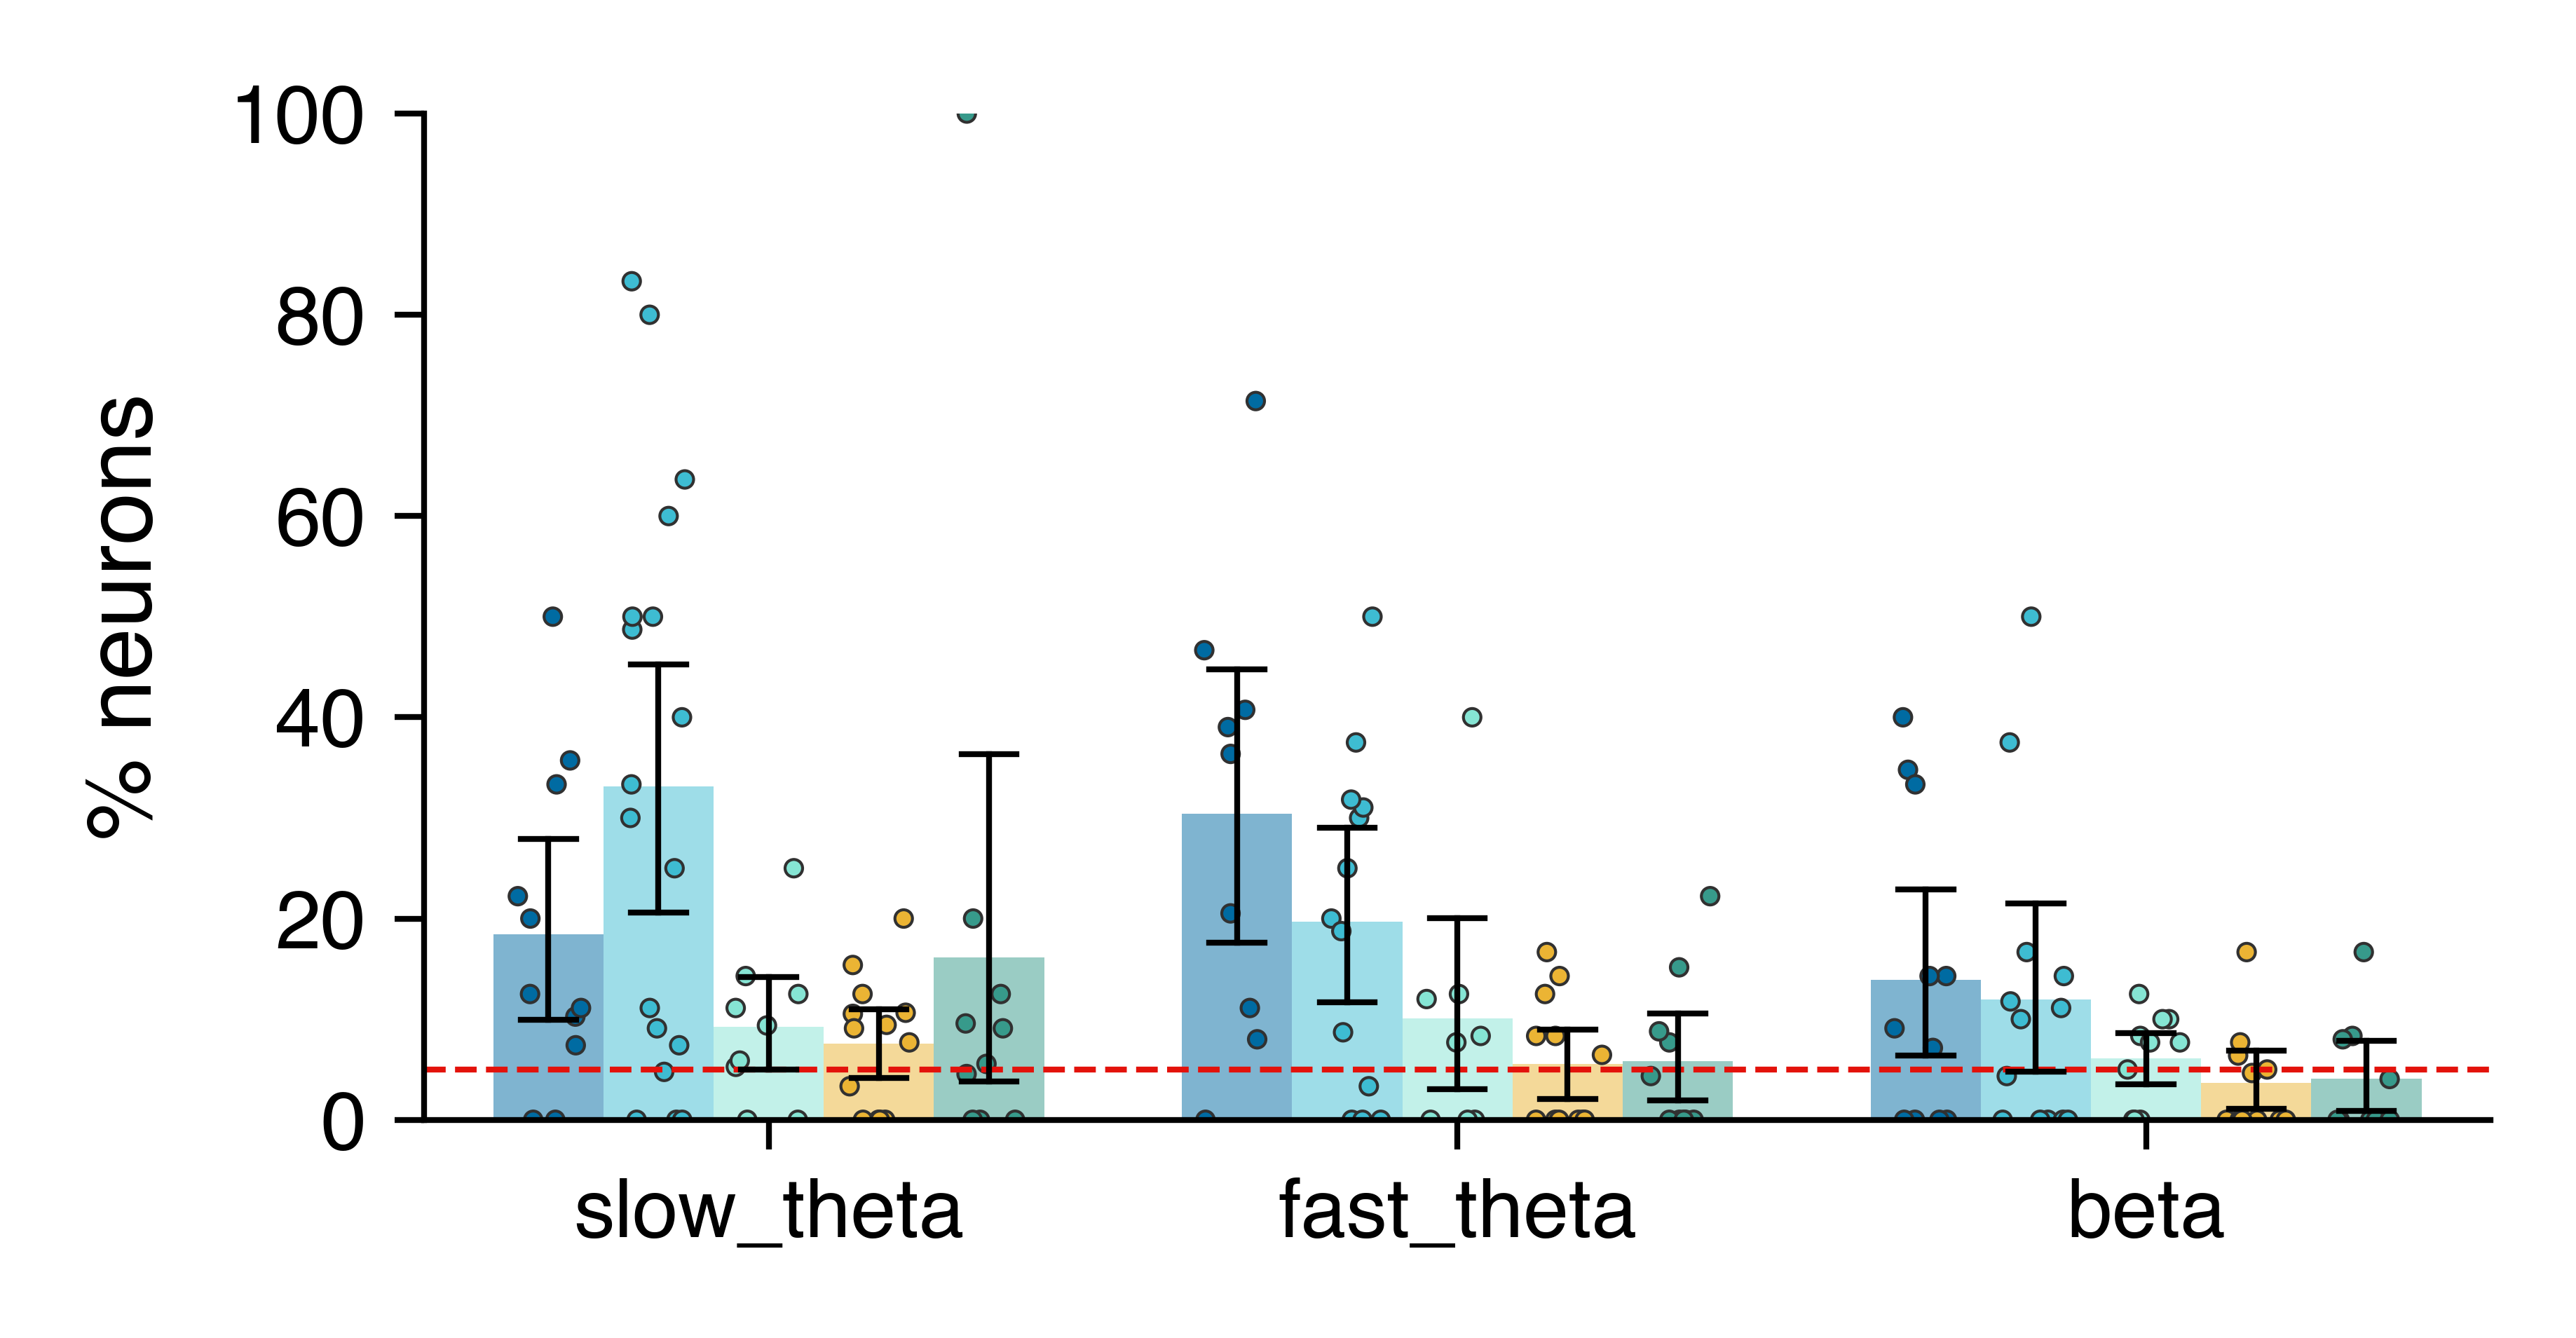

In [49]:
# Plot phase-locking percentage by band and region.
savefig = False
overwrite = False
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 100
yticks = [0, 20, 40, 60, 80, 100]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 0.5
stripsize = 1.5
jitter = 0.25
capsize = 2.5
palette = palettes['economist'][:5]
savefig = 0
overwrite = 0
keep_edges = ['ctx-hpc']
keep_bands = ['slow_theta', 'fast_theta', 'beta']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
band_sigs = []
for band in keep_bands:
    qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
           .format(keep_edges, band, min_spikes))
    band_sigs.append(pl_mrls
                     .query(qry)
                     .groupby(['subj', 'edge', 'unit_roi_gen'], observed=True)
                     .agg({'unit': len,
                           '{}_sig'.format(band): np.nanmean})
                     .query("(unit>={})".format(min_units))
                     .rename(columns={'{}_sig'.format(band): 'sig'}))
    band_sigs[-1].insert(0, 'band', band)
band_sigs = pd.concat(band_sigs, axis=0)
band_sigs = band_sigs.reset_index()
band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
mean_dat = (dat
            .groupby(['band', 'unit_roi_gen'])
            .agg({'sig': [np.mean, stats.sem]}))
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=co['r'], ls='--')
_ax = sns.barplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  ci=95, seed=1, errcolor='k', errwidth=spine_lw, capsize=0.08)
_ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                    palette=palette, size=stripsize, linewidth=spine_lw/2,
                    alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = (np.arange(len(keep_rois)) - (len(keep_rois)/2) + 0.5) * (0.8 / len(keep_rois))
# for iRoi, roi in enumerate(keep_rois):
#     _ax.errorbar(np.arange(len(keep_bands)) + xoffsets[iRoi],
#                  mean_dat.loc[(slice(None), roi), ('sig', 'mean')].values,
#                  yerr=mean_dat.loc[(slice(None), roi), ('sig', 'sem')].values * 1.96,
#                  ecolor='k', elinewidth=spine_lw, capsize=capsize,
#                  capthick=0.1, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_bands)))
_ax.set_xticklabels(keep_bands, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit-osc_pct-sig.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [52]:
qry

"(mask=='lfp_not_unit') & (edge==['ctx-hpc']) & (same_hem==True) & (beta_n_spikes_mask>=30)"

In [67]:
dat = (pl_mrls.query(qry).groupby(['edge', 'unit_roi_gen'], observed=True)
       .agg({'unit': len,
       '{}_sig'.format(band): [np.nanmean, lambda x: _bootstrap(x, np.nanmean, thresh=0.05)]}))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = np.array([r[0]])


In [68]:
# dat.columns = ['unit', '{}_sig'.format(band), 'bootstrap']
# dat['{}_sig_95ci'.format(band)] = dat['bootstrap'].apply(lambda x: tuple(x[0]))
# dat['{}_sig_pval'.format(band)] = dat['bootstrap'].apply(lambda x: x[1])
# dat.drop(columns=['bootstrap'], inplace=True)
dat

unit slow_theta_sig  \
                      len        nanmean   
edge    unit_roi_gen                       
ctx-hpc EC            224       0.196429   
        A             258       0.286822   
        PHG-FSG       153       0.084967   
        mPFC          266       0.082707   
        O             260       0.115385   

                                                                         
                                                             <lambda_0>  
edge    unit_roi_gen                                                     
ctx-hpc EC            ([0.14732142857142858, 0.25], 9.99900009999000...  
        A             ([0.23255813953488372, 0.34108527131782945], 9...  
        PHG-FSG       ([0.0457516339869281, 0.13071895424836602], 0....  
        mPFC          ([0.05263157894736842, 0.11654135338345864], 0...  
        O             ([0.07692307692307693, 0.15384615384615385], 0...

In [73]:
# type1_err = 0.05
# band_sigs = []
# for band in keep_bands:
#     qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
#            .format(keep_edges, band, min_spikes))
#     band_sigs.append(pl_mrls
#                      .query(qry)
#                      .groupby(['edge', 'unit_roi_gen'], observed=True)
#                      .agg({'unit': len,
#                            '{}_sig'.format(band): [np.nanmean,
#                                                    lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
#     band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
#     band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
#     band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
#     band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
#     band_sigs[-1].insert(0, 'band', band)
# band_sigs = pd.concat(band_sigs, axis=0)
# band_sigs = band_sigs.reset_index()
# band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
dat

,edge,unit_roi_gen,band,unit,sig,sig_95ci,sig_pval
0,ctx-hpc,EC,slow_theta,224,19.642857,"(14.732142857142858, 25.0)",0.000100
1,ctx-hpc,A,slow_theta,258,28.682171,"(23.25581395348837, 34.49612403100775)",0.000100
2,ctx-hpc,PHG-FSG,slow_theta,153,8.496732,"(4.57516339869281, 13.071895424836603)",0.047195
3,ctx-hpc,mPFC,slow_theta,266,8.270677,"(5.263157894736842, 11.654135338345863)",0.024198
4,ctx-hpc,O,slow_theta,260,11.538462,"(7.6923076923076925, 15.384615384615385)",0.000500
5,ctx-hpc,EC,fast_theta,206,29.126214,"(23.300970873786408, 35.43689320388349)",0.000100
6,ctx-hpc,A,fast_theta,206,19.417476,"(14.077669902912621, 24.75728155339806)",0.000100
7,ctx-hpc,PHG-FSG,fast_theta,123,10.569106,"(5.691056910569105, 16.260162601626014)",0.021798
8,ctx-hpc,mPFC,fast_theta,216,6.481481,"(3.7037037037037033, 10.185185185185185)",0.168883
9,ctx-hpc,O,fast_theta,227,7.488987,"(4.405286343612335, 11.013215859030836)",0.072693


In [87]:
dat.query("(unit_roi_gen=='{}')".format('EC'))

,edge,unit_roi_gen,band,unit,sig,sig_95ci,sig_pval
0,ctx-hpc,EC,slow_theta,224,19.642857,"(14.732142857142858, 25.0)",0.0001
5,ctx-hpc,EC,fast_theta,206,29.126214,"(23.300970873786408, 35.43689320388349)",0.0001
10,ctx-hpc,EC,beta,172,13.372093,"(8.720930232558139, 18.6046511627907)",0.0004


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = np.array([r[0]])


min = 5.5, max = 24.9


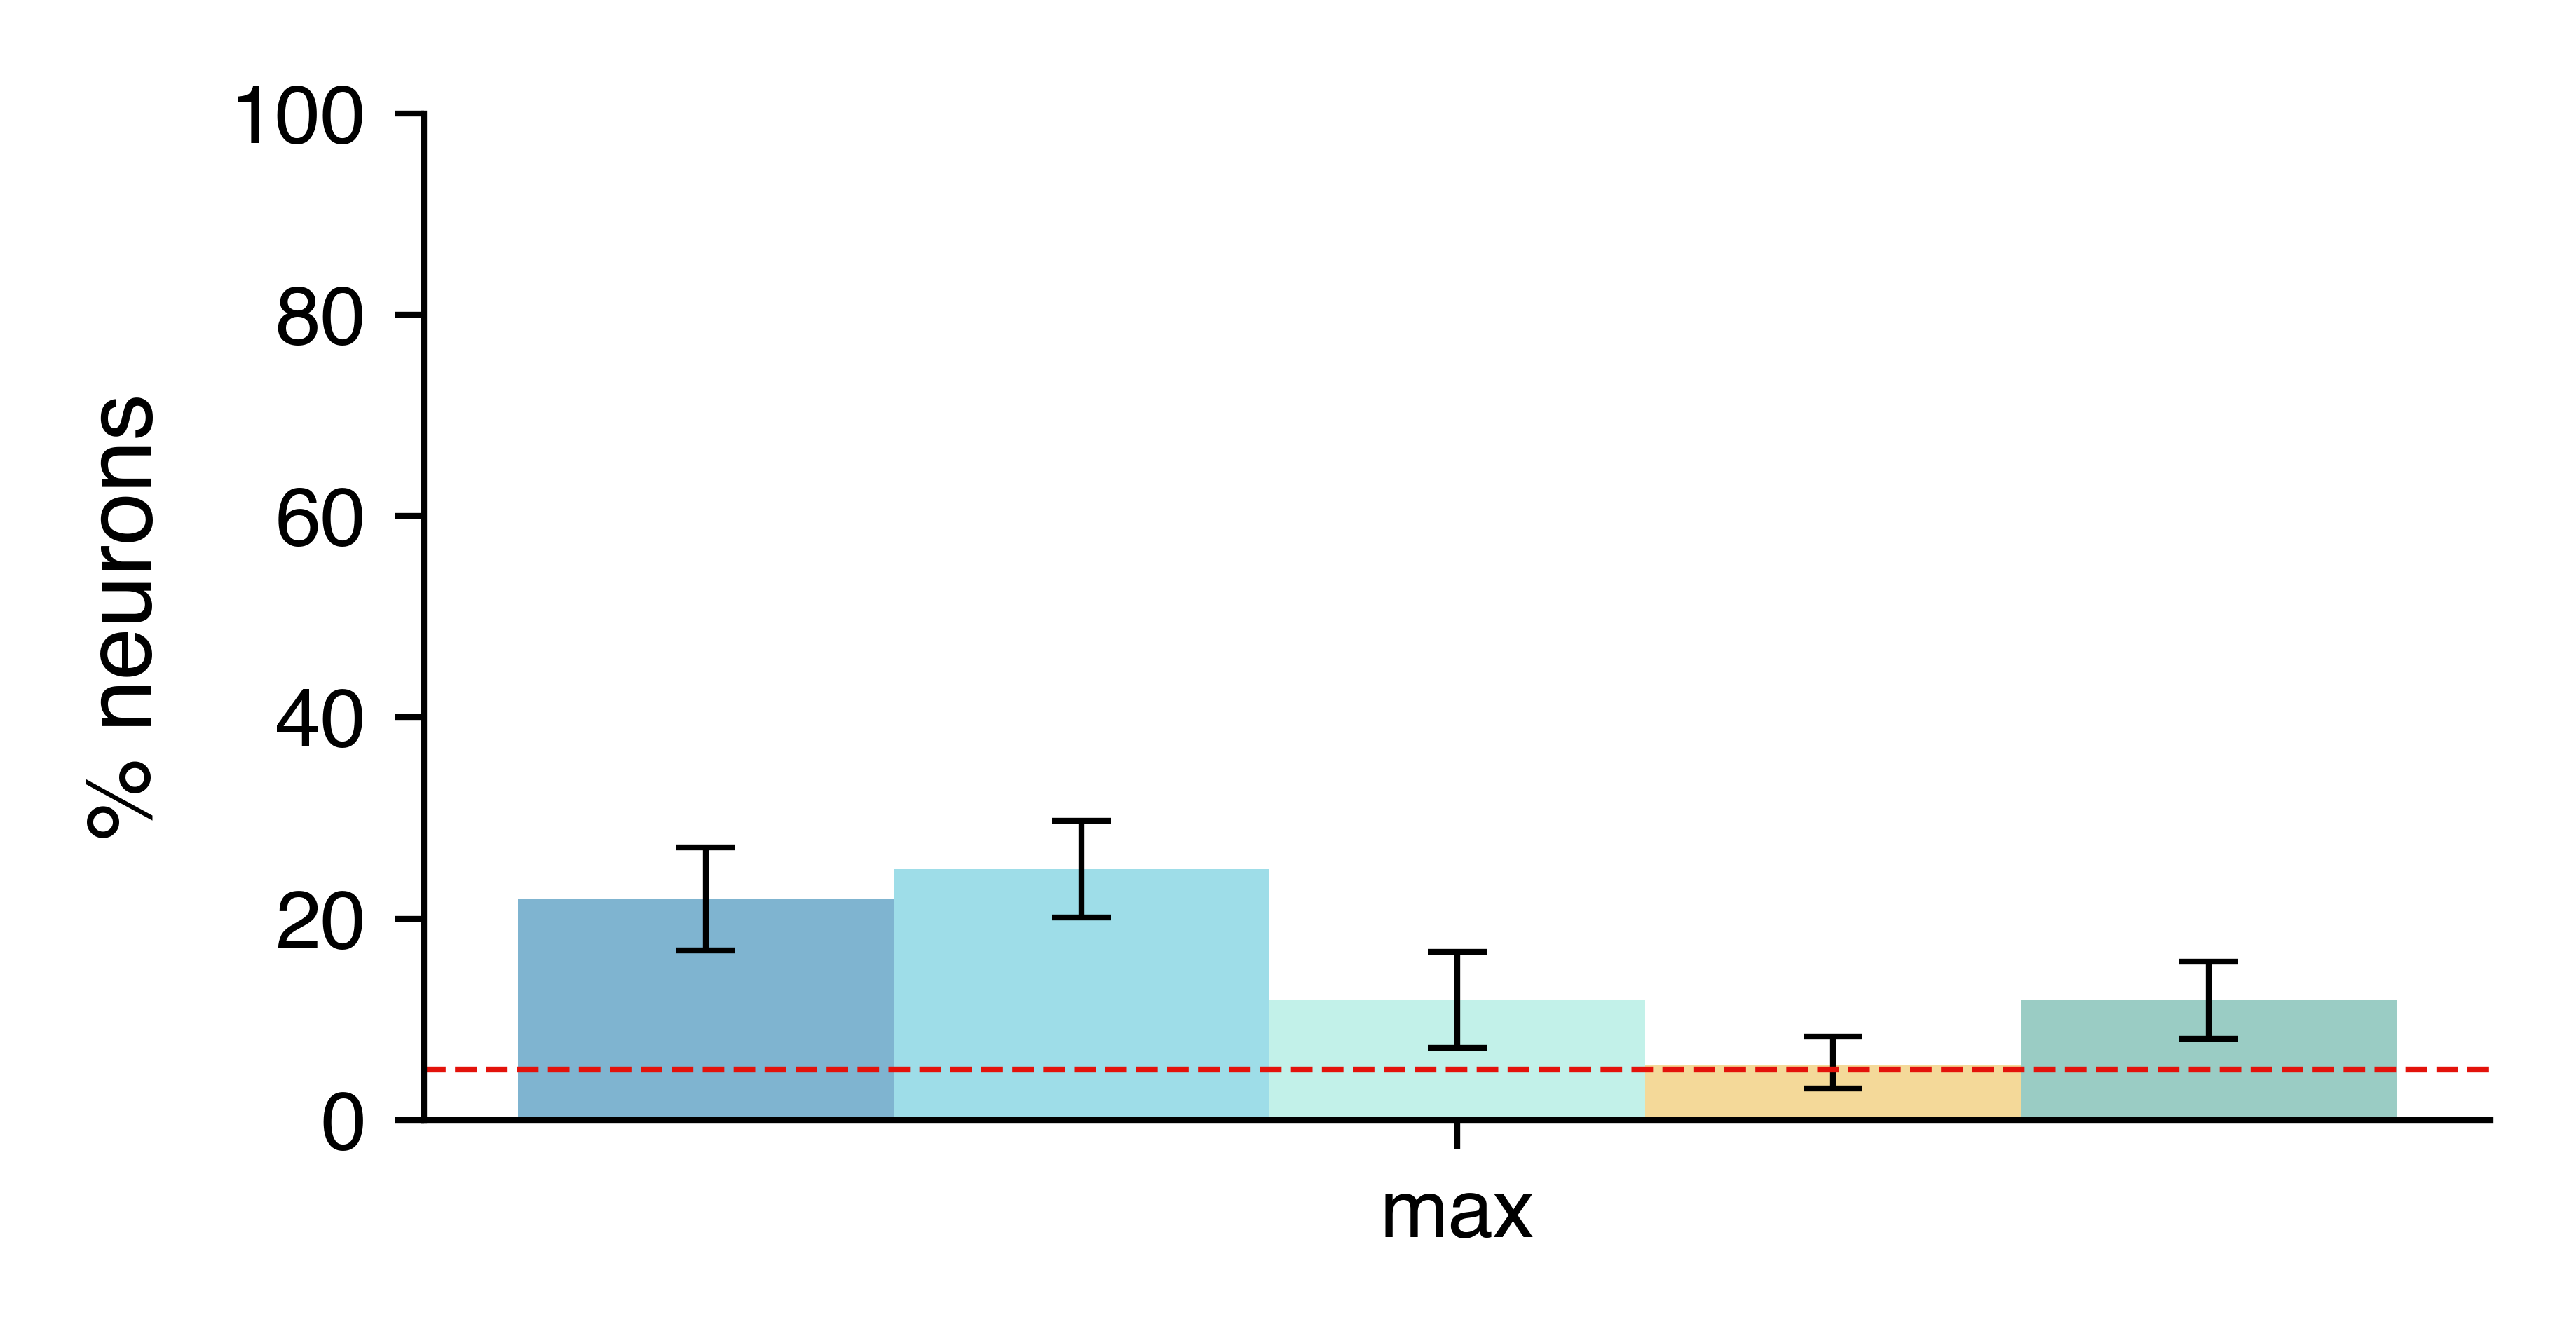

In [106]:
# Plot phase-locking percentage by band and region.
savefig = False
overwrite = False
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 100
yticks = [0, 20, 40, 60, 80, 100]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 0.5
stripsize = 1.5
jitter = 0.25
capsize = 2.5
palette = palettes['economist'][:5]
savefig = 0
overwrite = 0
keep_edges = ['ctx-hpc']
keep_bands = ['max']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
type1_err = 0.05
band_sigs = []
qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(keep_edges, min_spikes))
band_sigs.append(pl_mrls
                 .query(qry)
                 .groupby(['edge', 'unit_roi_gen'], observed=True)
                 .agg({'unit': len,
                       'sig': [np.nanmean, lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
band_sigs[-1].insert(0, 'band', 'max')
band_sigs = pd.concat(band_sigs, axis=0)
band_sigs = band_sigs.reset_index()
band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=co['r'], ls='--')
_ax = sns.barplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  ci=None)
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = (np.arange(len(keep_rois)) - (len(keep_rois)/2) + 0.5) * (0.8 / len(keep_rois))
for iRoi, roi in enumerate(keep_rois):
    _ax.errorbar(np.arange(len(keep_bands)) + xoffsets[iRoi],
                 dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values,
                 yerr=np.abs(dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values[None, :] - np.array(dat.query("(unit_roi_gen=='{}')".format(roi))['sig_95ci'].tolist()).T),
                 ecolor='k', elinewidth=spine_lw, capsize=capsize,
                 capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_bands)))
_ax.set_xticklabels(keep_bands, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit-osc_pct-sig.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

1219 neurons
min = 3.4, max = 29.1
CI: min = 1.0, max = 35.4
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/pct_sig/ctx-hpc_lfp-not-unit-osc_pct-sig_across-1219-neurons.pdf


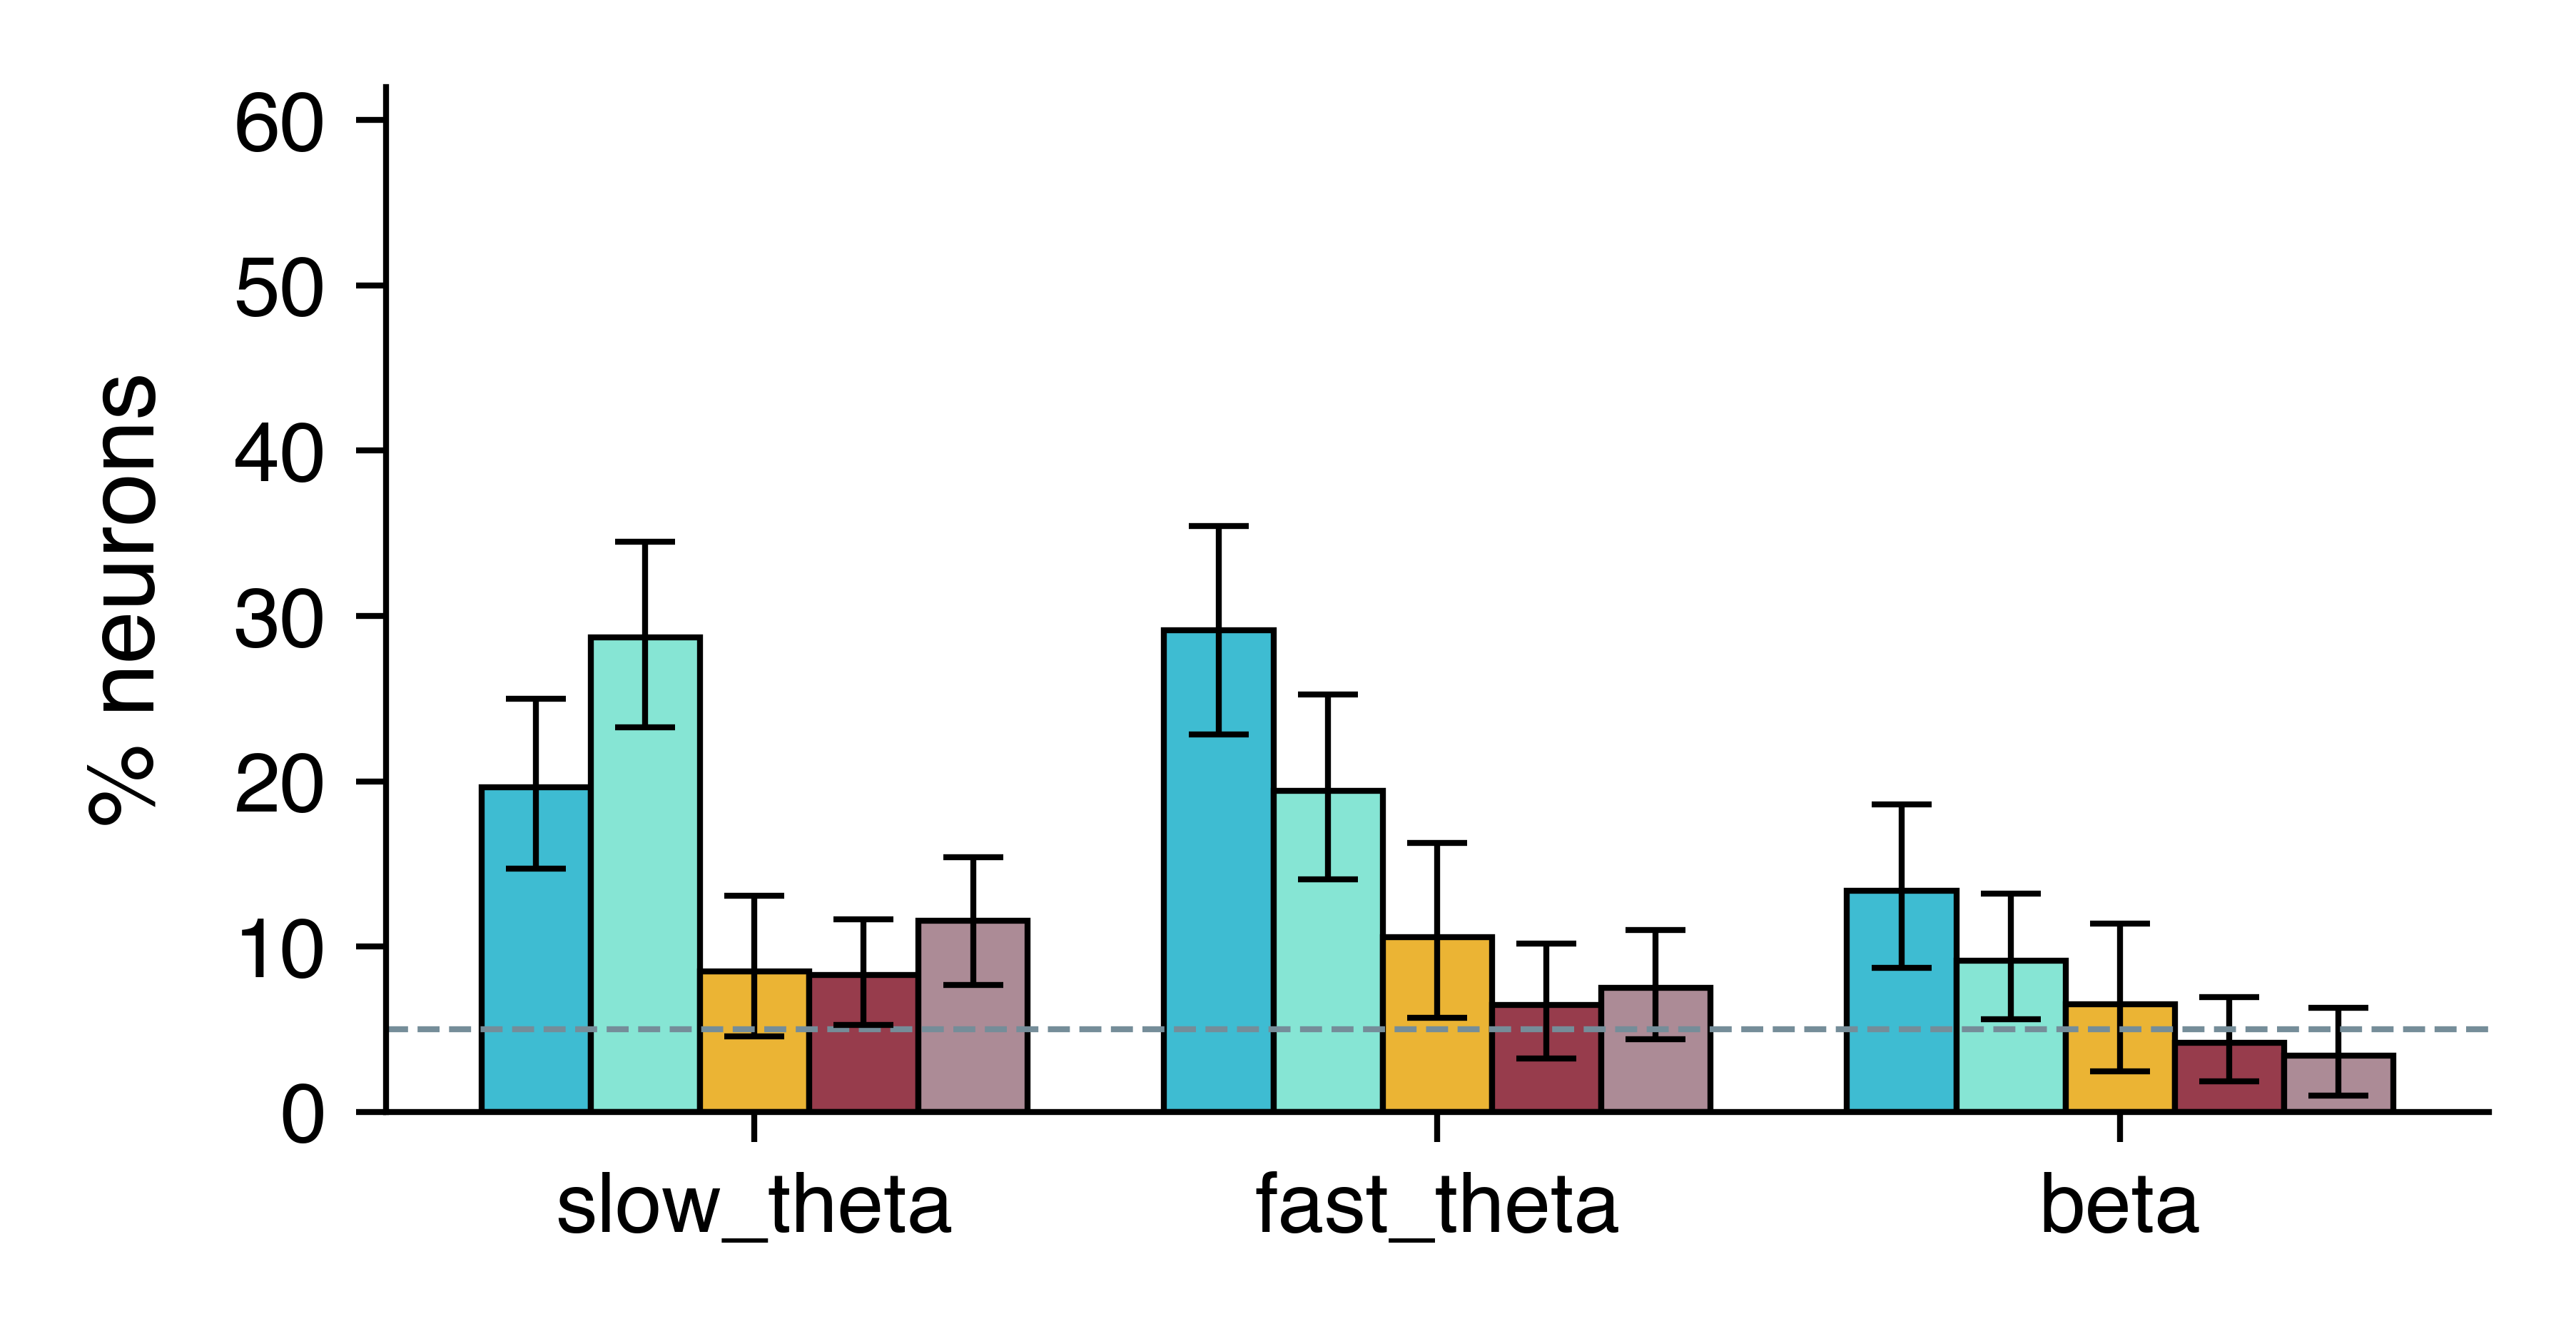

In [112]:
# Plot phase-locking percentage by band and region.
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 62
yticks = [0, 10, 20, 30, 40, 50, 60]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']
palette = [co['b'], co['c'], co['lg'], co['y'], co['m'], co['lm']][1:]
keep_edges = ['ctx-hpc']
keep_bands = ['slow_theta', 'fast_theta', 'beta']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
n_units = pd.concat([pl_mrls.query(("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
                            .format(keep_edges, band, min_spikes)))
                     for band in keep_bands])['subj_sess_unit'].unique().size
print('{} neurons'.format(n_units))

# type1_err = 0.05
# band_sigs = []
# for band in keep_bands:
#     qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
#            .format(keep_edges, band, min_spikes))
#     band_sigs.append(pl_mrls
#                      .query(qry)
#                      .groupby(['edge', 'unit_roi_gen'], observed=True)
#                      .agg({'unit': len,
#                            '{}_sig'.format(band): [np.nanmean,
#                                                    lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
#     band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
#     band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
#     band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
#     band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
#     band_sigs[-1].insert(0, 'band', band)
# band_sigs = pd.concat(band_sigs, axis=0)
# band_sigs = band_sigs.reset_index()
# band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))
print('CI: min = {:.1f}, max = {:.1f}'.format(dat['sig_95ci'].apply(lambda x: x[0]).min(), dat['sig_95ci'].apply(lambda x: x[1]).max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.barplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  lw=spine_lw, ec='k', ci=None)
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = (np.arange(len(keep_rois)) - (len(keep_rois)/2) + 0.5) * (0.8 / len(keep_rois))
for iRoi, roi in enumerate(keep_rois):
    _ax.errorbar(np.arange(len(keep_bands)) + xoffsets[iRoi],
                 dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values,
                 yerr=np.abs(dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values[None, :] - np.array(dat.query("(unit_roi_gen=='{}')".format(roi))['sig_95ci'].tolist()).T),
                 ecolor='k', elinewidth=spine_lw, capsize=capsize,
                 capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_bands)))
_ax.set_xticklabels(keep_bands, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit-osc_pct-sig_across-{}-neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [16]:
qry = ("(edge=={}) & (same_hem==True)".format(keep_edges, min_spikes))
pl_mrls.query(qry).groupby(['mask', 'edge', 'unit_roi_gen'], observed=True)['max_n_spikes_mask'].apply(median_q)

mask          edge     unit_roi_gen
lfp_and_unit  ctx-hpc  EC              123.38 (51.43, 318.88)
                       A                93.50 (34.25, 215.75)
                       PHG-FSG          67.93 (29.46, 167.68)
                       mPFC             85.00 (31.62, 195.50)
                       O               101.79 (35.66, 254.04)
lfp_not_unit  ctx-hpc  EC              188.88 (77.14, 473.71)
                       A               110.62 (40.00, 267.29)
                       PHG-FSG         165.09 (66.89, 421.26)
                       mPFC            157.29 (61.75, 375.88)
                       O               309.86 (78.34, 812.54)
Name: max_n_spikes_mask, dtype: object

In [19]:
alpha = 0.05
n_boot = 15000
method_boot = 'bca'
ci_output = 'lowhigh'
seed = None
keep_edges = ['ctx-hpc']
mask = 'lfp_not_unit'
sig_col = 'sig'

#  -------------------------
timer = Timer()

def _compfunc(sample_stat,
              alpha=0.05):
    return sample_stat <= alpha

print('min_spikes = {}, sig_col = {}'.format(min_spikes, sig_col), end='\n'*2)
qry = ("(mask=='{}') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(mask, keep_edges, min_spikes))
for (edge, unit_roi_gen), df in pl_mrls.query(qry).groupby(['edge', 'unit_roi_gen'], observed=True):
    n = len(df)
    n_sig  = df[sig_col].sum()
    mean_sig = df[sig_col].mean()
    if mean_sig > 0:
        ci, samp = boot.ci(df[sig_col].values.astype(bool),
                           statfunction=np.mean,
                           alpha=alpha,
                           n_samples=n_boot,
                           method=method_boot,
                           output=ci_output,                 
                           seed=seed,
                           return_dist=True,
                           use_numba=True)
        mean_samp = np.mean(samp)
        pval = boot.pval(df[sig_col].values.astype(bool),
                         statfunction=np.mean,
                         compfunction=_compfunc,
                         n_samples=n_boot,
                         seed=seed)
    else:
        ci = np.array((0.0, 0.0))
        mean_samp = 0.0
        pval = 1.0

    print('{}, {:>7}: sig = {}/{}, {:.1%} (samp_mean = {:.1%}, CI = {:.1%}-{:.1%}, P = {})'
          .format(edge, unit_roi_gen, n_sig, n, mean_sig, mean_samp, ci[0], ci[1], pval))
    
print()
print(timer)

min_spikes = 50, sig_col = sig

ctx-hpc,      EC: sig = 54/233, 23.2% (samp_mean = 23.2%, CI = 17.6%-28.3%, P = 0.0)
ctx-hpc,       A: sig = 73/263, 27.8% (samp_mean = 27.8%, CI = 22.1%-33.1%, P = 0.0)
ctx-hpc, PHG-FSG: sig = 19/151, 12.6% (samp_mean = 12.6%, CI = 7.3%-17.9%, P = 0.0011333333333333334)
ctx-hpc,    mPFC: sig = 15/265, 5.7% (samp_mean = 5.6%, CI = 3.0%-8.7%, P = 0.3526666666666667)
ctx-hpc,       O: sig = 32/260, 12.3% (samp_mean = 12.3%, CI = 8.5%-16.2%, P = 0.00013333333333333334)

Ran in 3.2s


In [20]:
alpha = 0.05
n_boot = 15000
method_boot = 'bca'
ci_output = 'lowhigh'
seed = None
keep_edges = ['ctx-hpc']
sig_col = 'sig_fdr'

#  -------------------------
timer = Timer()

def _compfunc(sample_stat,
              alpha=0.05):
    return sample_stat <= alpha

print('min_spikes = {}, sig_col = {}'.format(min_spikes, sig_col), end='\n'*2)
qry = ("(edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(keep_edges, min_spikes))
for (edge, unit_roi_gen), df in pl_mrls.query(qry).groupby(['edge', 'unit_roi_gen'], observed=True):
    n = len(df)
    n_sig  = df[sig_col].sum()
    mean_sig = df[sig_col].mean()
    if mean_sig > 0:
        ci, samp = boot.ci(df[sig_col].values.astype(bool),
                           statfunction=np.mean,
                           alpha=alpha,
                           n_samples=n_boot,
                           method=method_boot,
                           output=ci_output,                 
                           seed=seed,
                           return_dist=True,
                           use_numba=True)
        mean_samp = np.mean(samp)
        pval = boot.pval(df[sig_col].values.astype(bool),
                         statfunction=np.mean,
                         compfunction=_compfunc,
                         n_samples=n_boot,
                         seed=seed)
    else:
        ci = np.array((0.0, 0.0))
        mean_samp = 0.0
        pval = 1.0

    print('{}, {:>7}: sig = {}/{}, {:.1%} (samp_mean = {:.1%}, CI = {:.1%}-{:.1%}, P = {})'
          .format(edge, unit_roi_gen, n_sig, n, mean_sig, mean_samp, ci[0], ci[1], pval))
    
print()
print(timer)

min_spikes = 50, sig_col = sig_fdr

ctx-hpc,      EC: sig = 115/442, 26.0% (samp_mean = 26.0%, CI = 21.7%-30.1%, P = 0.0)
ctx-hpc,       A: sig = 125/523, 23.9% (samp_mean = 23.9%, CI = 20.3%-27.5%, P = 0.0)
ctx-hpc, PHG-FSG: sig = 0/256, 0.0% (samp_mean = 0.0%, CI = 0.0%-0.0%, P = 1.0)
ctx-hpc,    mPFC: sig = 10/482, 2.1% (samp_mean = 2.1%, CI = 0.8%-3.3%, P = 1.0)
ctx-hpc,       O: sig = 9/474, 1.9% (samp_mean = 1.9%, CI = 0.8%-3.2%, P = 1.0)

Ran in 2.5s


1313 neurons


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = np.array([r[0]])


min = 5.5, max = 24.9
CI: min = 3.1, max = 30.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/pct_sig/ctx-hpc_lfp-not-unit_max-freq_pct-sig_across-1313-neurons.pdf


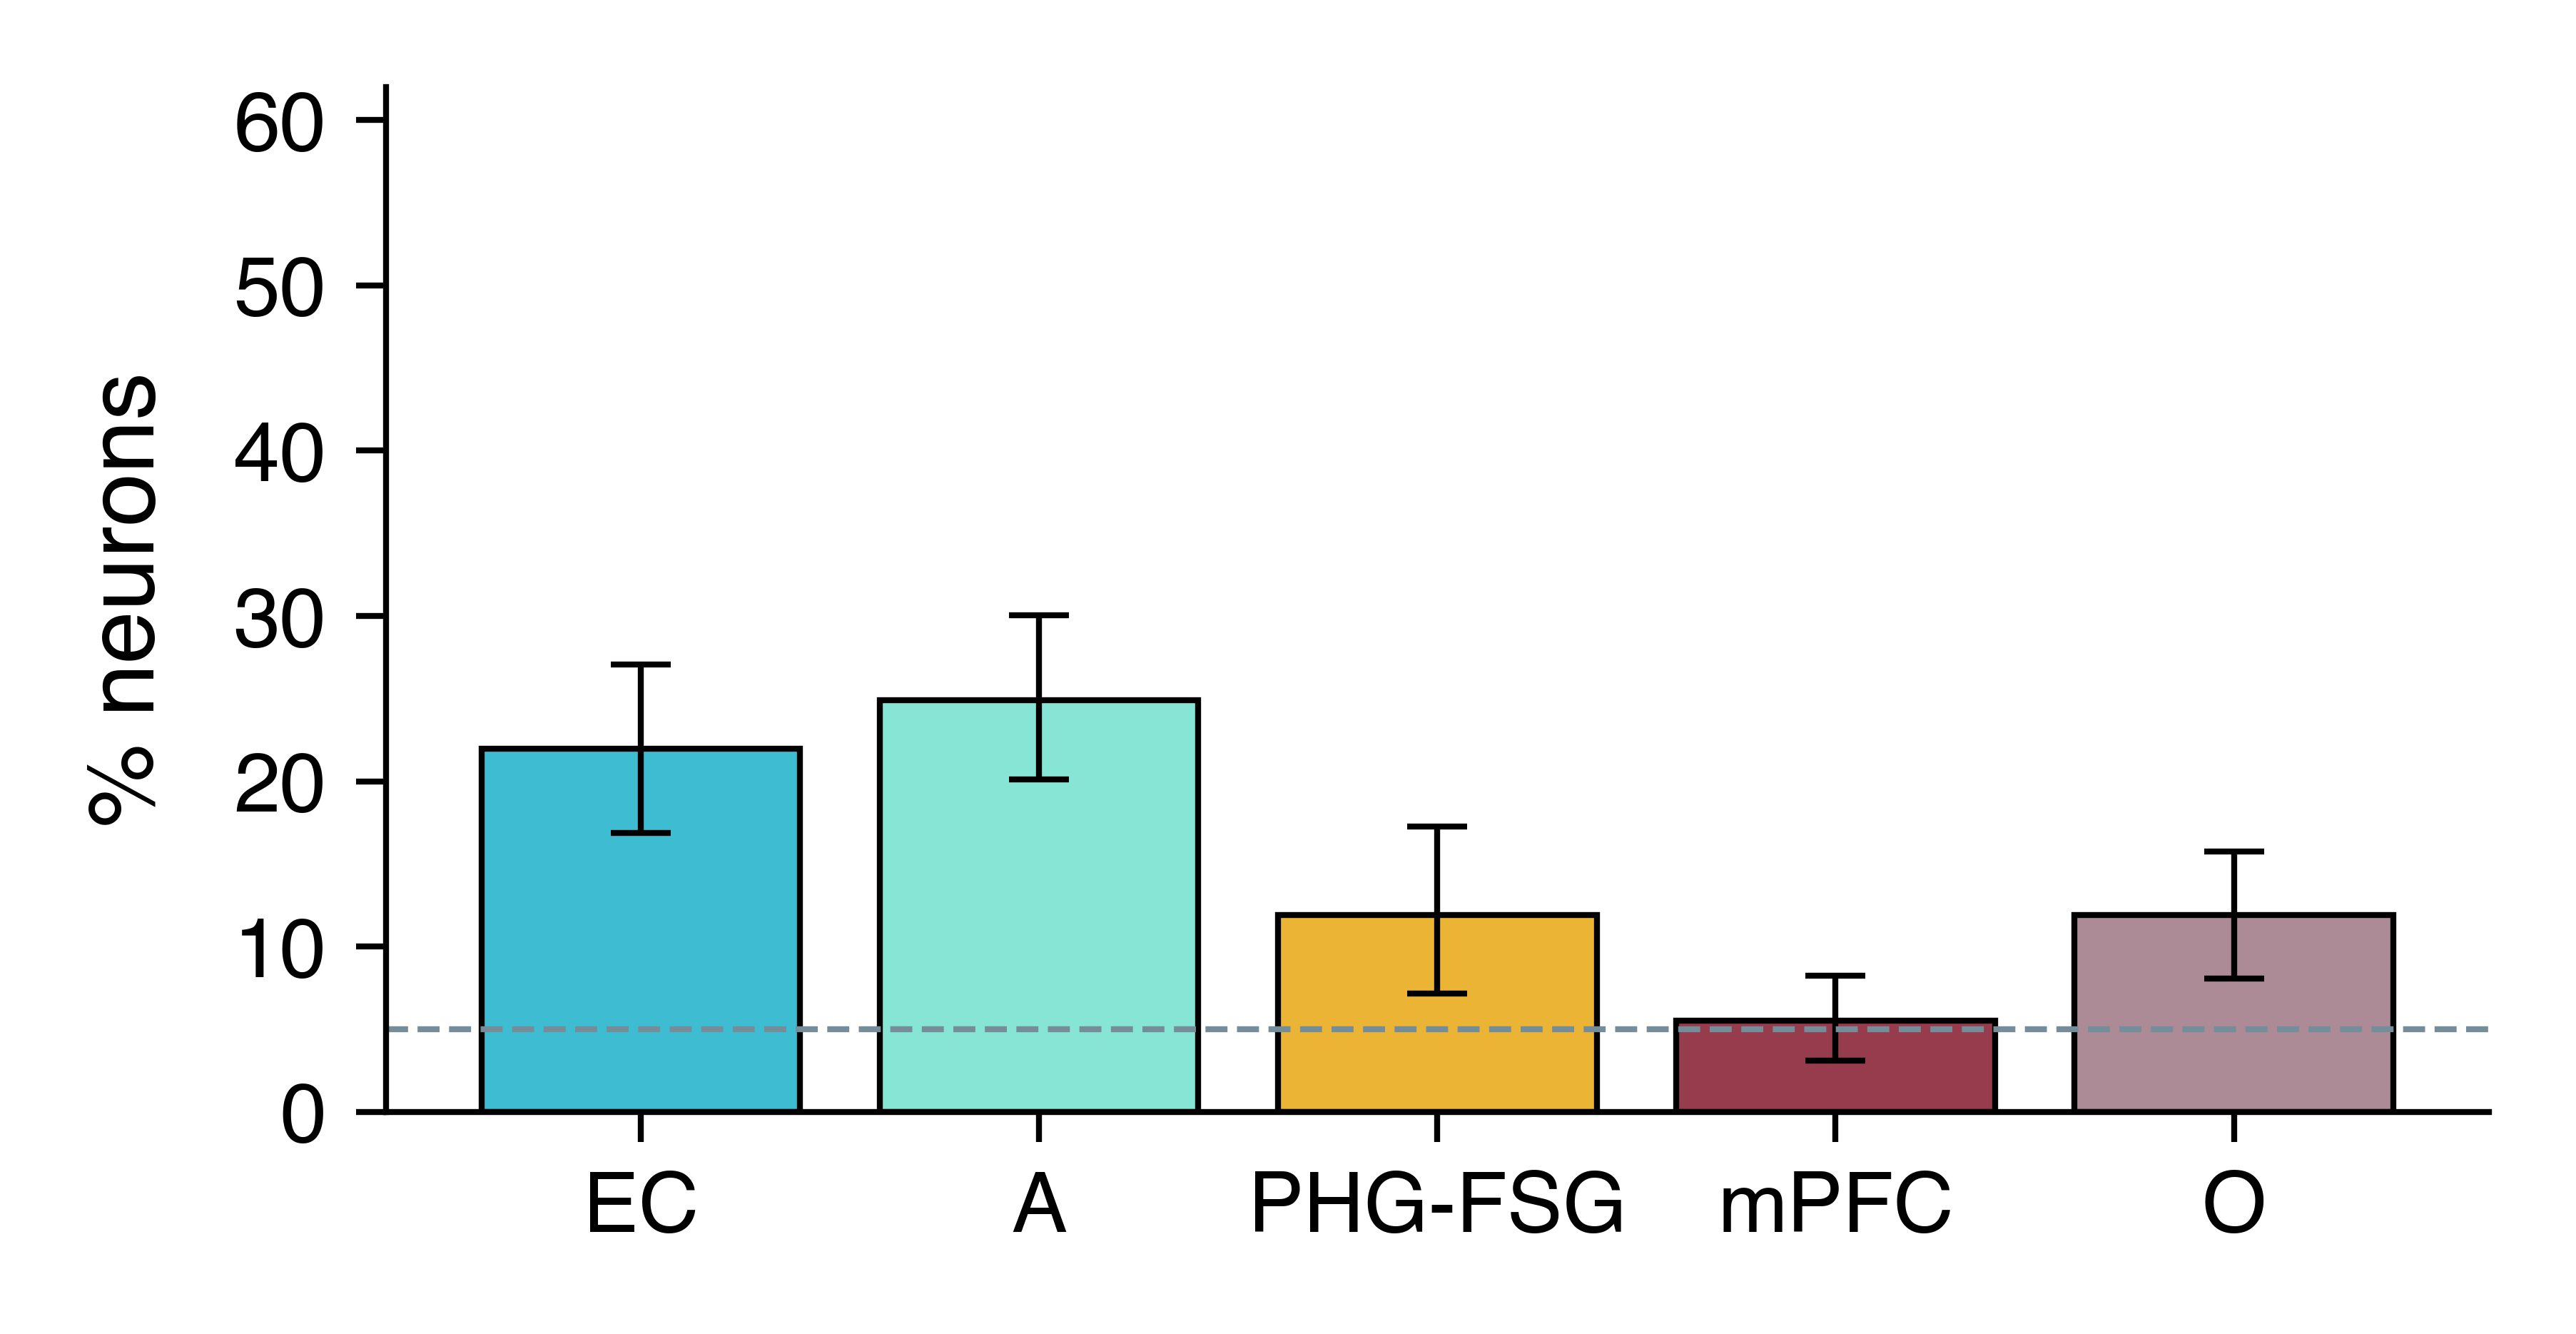

In [154]:
# Plot phase-locking percentage by region for the max phase-locking frequency.
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 62
yticks = [0, 10, 20, 30, 40, 50, 60]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']
palette = [co['b'], co['c'], co['lg'], co['y'], co['m'], co['lm']][1:]
keep_edges = ['ctx-hpc']
keep_bands = ['max']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
n_units = pl_mrls.query(("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
                         .format(keep_edges, min_spikes)))['subj_sess_unit'].unique().size
print('{} neurons'.format(n_units))

type1_err = 0.05
band_sigs = []
qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(keep_edges, min_spikes))
band_sigs.append(pl_mrls
                 .query(qry)
                 .groupby(['edge', 'unit_roi_gen'], observed=True)
                 .agg({'unit': len,
                       'sig': [np.nanmean, lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
band_sigs[-1].insert(0, 'band', 'max')
band_sigs = pd.concat(band_sigs, axis=0)
band_sigs = band_sigs.reset_index()
band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))
print('CI: min = {:.1f}, max = {:.1f}'.format(dat['sig_95ci'].apply(lambda x: x[0]).min(), dat['sig_95ci'].apply(lambda x: x[1]).max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.barplot(x='unit_roi_gen', y='sig', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  ci=None, lw=spine_lw, ec='k',)
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = np.arange(len(keep_rois))
yerr = np.abs(dat['sig'].values[None, :] - np.array(dat['sig_95ci'].tolist()).T)
_ax.errorbar(np.arange(len(keep_rois)),
             dat['sig'].values,
             yerr=yerr,
             ecolor='k', elinewidth=spine_lw, capsize=capsize,
             capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_rois)))
_ax.set_xticklabels(keep_rois, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit_max-freq_pct-sig_across-{}-neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# Phase-locking sig bars

In [95]:
def bootstrap_pvals_multcomp(pvals,
                             n_resamples=15000,
                             confidence_level=0.95,
                             alpha=0.05,
                             method='fdr_tsbky',
                             return_sample=False):
    """Percentile bootstrap the prop. of pvals < alpha after mult. comp. correction."""
    n_obs = len(pvals)
    sample_stats = np.array([
        np.mean(
            sm.stats.multipletests(
                np.random.choice(pvals, n_obs, replace=True),
                alpha=alpha,
                method=method
            )[0]
        )
        for _ in range(n_resamples)])

    q = 100 * np.array((0.5 - (confidence_level/2), 0.5 + (confidence_level/2)))
    conf_int = np.percentile(sample_stats, q)
    
    output = od([])
    output['ci'] = conf_int
    if return_sample:
        output['sample'] = sample_stats
        
    return output

In [10]:
timer = Timer()

roi_sigs = []
roi_sigs = (pl_osc2_flat
             .groupby(['mask', 'unit_roi_gen', 'is_local'], observed=True)
             .agg({'unit': len,
                   'sig_fdr': lambda x: 100 * np.mean(x),
                   'pval': stats.sem
#                    'pval': lambda x: list(100 * bootstrap_pvals_multcomp(x, n_resamples=15000)['ci'])
                  })
             .sort_values(['mask', 'unit_roi_gen', 'is_local'], ascending=[True, True, False])
             .rename(columns={'pval': 'ci'})
             .reset_index())
print(timer)

roi_sigs

Ran in 0.0s


,mask,unit_roi_gen,is_local,unit,sig_fdr,ci
0,target_and_comp,EC,True,180,31.111111,0.024361
1,target_and_comp,EC,False,206,39.320388,0.021917
2,target_and_comp,AMY,True,229,32.751092,0.022219
3,target_and_comp,AMY,False,230,27.826087,0.022236
4,target_and_comp,PHG,True,94,18.085106,0.035249
5,target_and_comp,PHG,False,102,0.000000,0.032426
6,target_and_comp,STG,True,80,31.250000,0.039763
7,target_and_comp,STG,False,92,3.260870,0.034267
8,target_and_comp,OFC,True,111,9.009009,0.031210
9,target_and_comp,OFC,False,105,6.666667,0.031085


806 neurons
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/pct_sig/ctx-hpc_osc1v2_max-freq_pct-sig-fdr_across-806-neurons.pdf


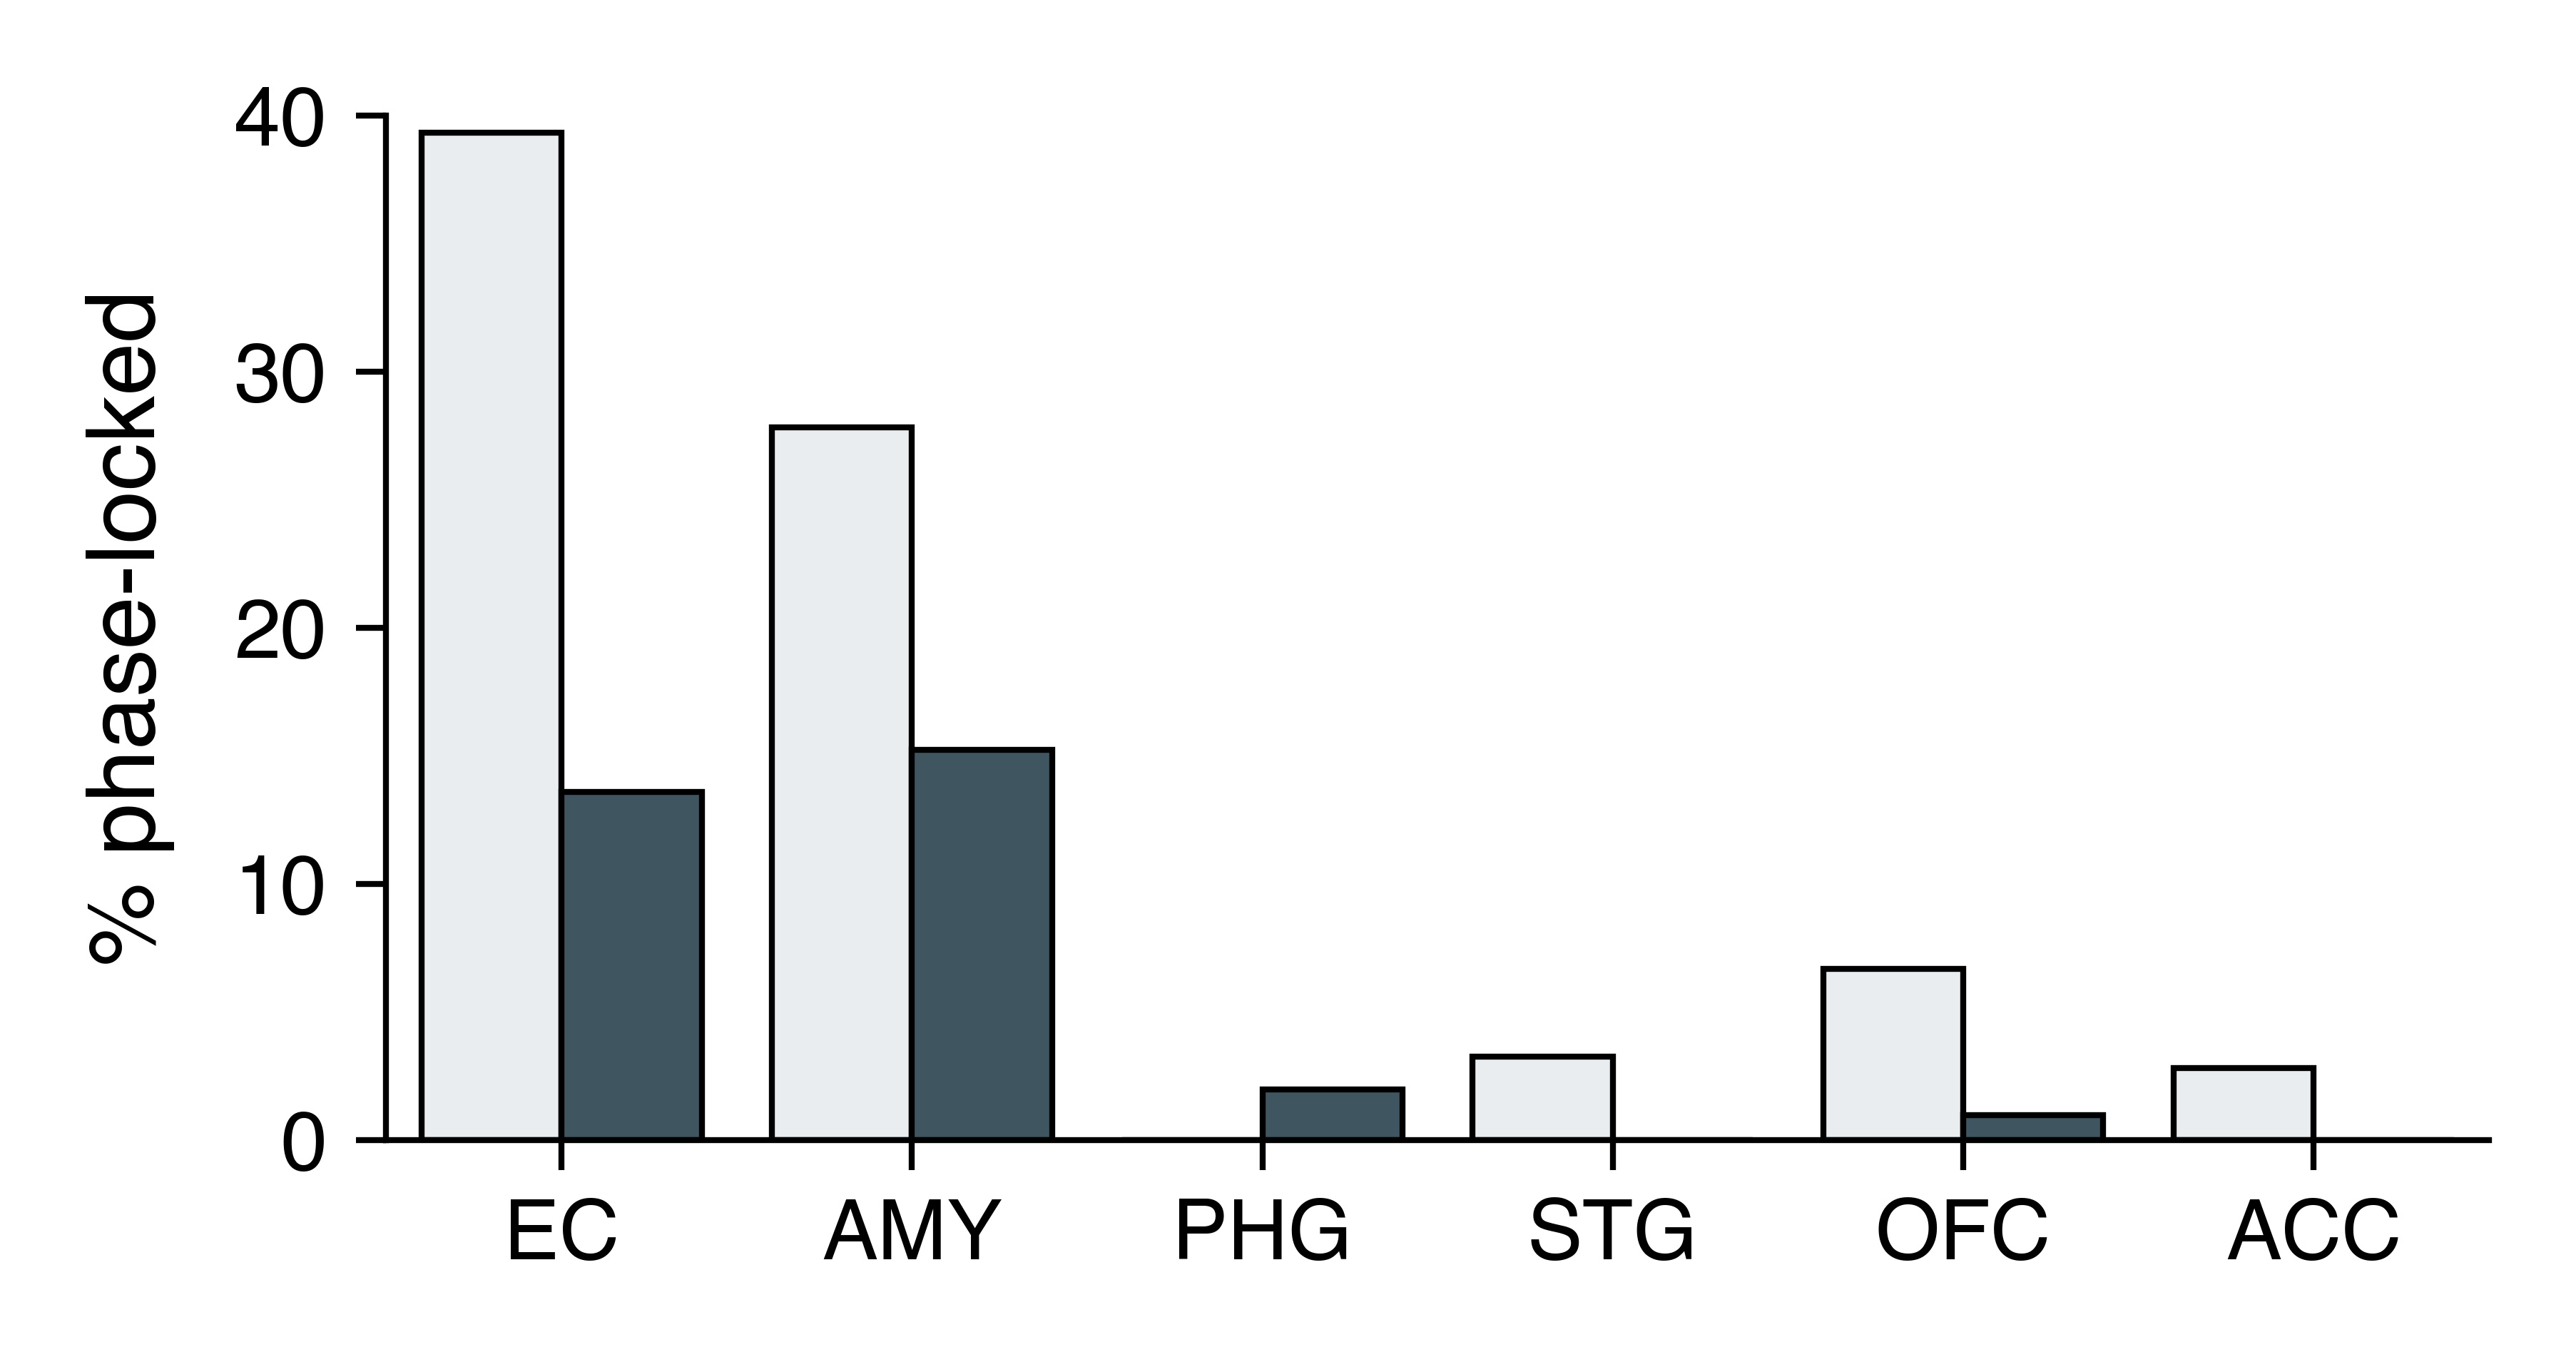

In [12]:
# Plot phase-locking percentage by region for the max phase-locking frequency.
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 40
yticks = [0, 10, 20, 30, 40]
bar_lw = 0.5
ebar_lw = 0.75
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
plot_err = False
capsize = 2.5
palette = [co['x1'], co['x4']]
is_local = False
keep_rois = ['EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
keep_masks = ['target_and_comp', 'target_not_comp']
xticklabs = keep_rois
sig_col = 'sig_fdr'

# ----------------------------
# Get the data.
qry = ("(unit_roi_gen=={}) & (is_local=={}) & (mask=={})"
       .format(keep_rois,  is_local, keep_masks))
n_units = pl_osc2_flat.query(qry)['subj_sess_unit'].nunique()
print('{} neurons'.format(n_units))

dat = roi_sigs.query(qry).copy()
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

_ax = sns.barplot(x='unit_roi_gen', y='sig_fdr', hue='mask',
                  order=keep_rois, hue_order=keep_masks,
                  data=dat, ax=_ax, palette=palette, saturation=1, alpha=bar_alpha,
                  ci=None, lw=bar_lw, ec='k')
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
if plot_err:
    for iBar, locality in enumerate(is_local):
        _dat = dat.query("(is_local=={})".format(is_local))
        xoffsets = [keep_rois.index(roi) + ((iBar - 0.5) * (0.8 / 2)) for roi in _dat['unit_roi_gen']]
        _ax.errorbar(xoffsets,
                     _dat['sig_fdr'].values,
                     yerr=np.abs(_dat['sig_fdr'].values[None, :] - np.array(_dat['ci'].tolist()).T),
                     lw=0, ecolor='k', elinewidth=ebar_lw, capthick=ebar_lw, capsize=capsize)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_rois)))
_ax.set_xticklabels(xticklabs, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% phase-locked', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       '{}_osc1v2_max-freq_pct-sig-fdr_across-{}-neurons.pdf'
                       .format('ctx-local' if is_local else 'ctx-hpc', n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# Region-to-region heatmaps

## Average across neurons

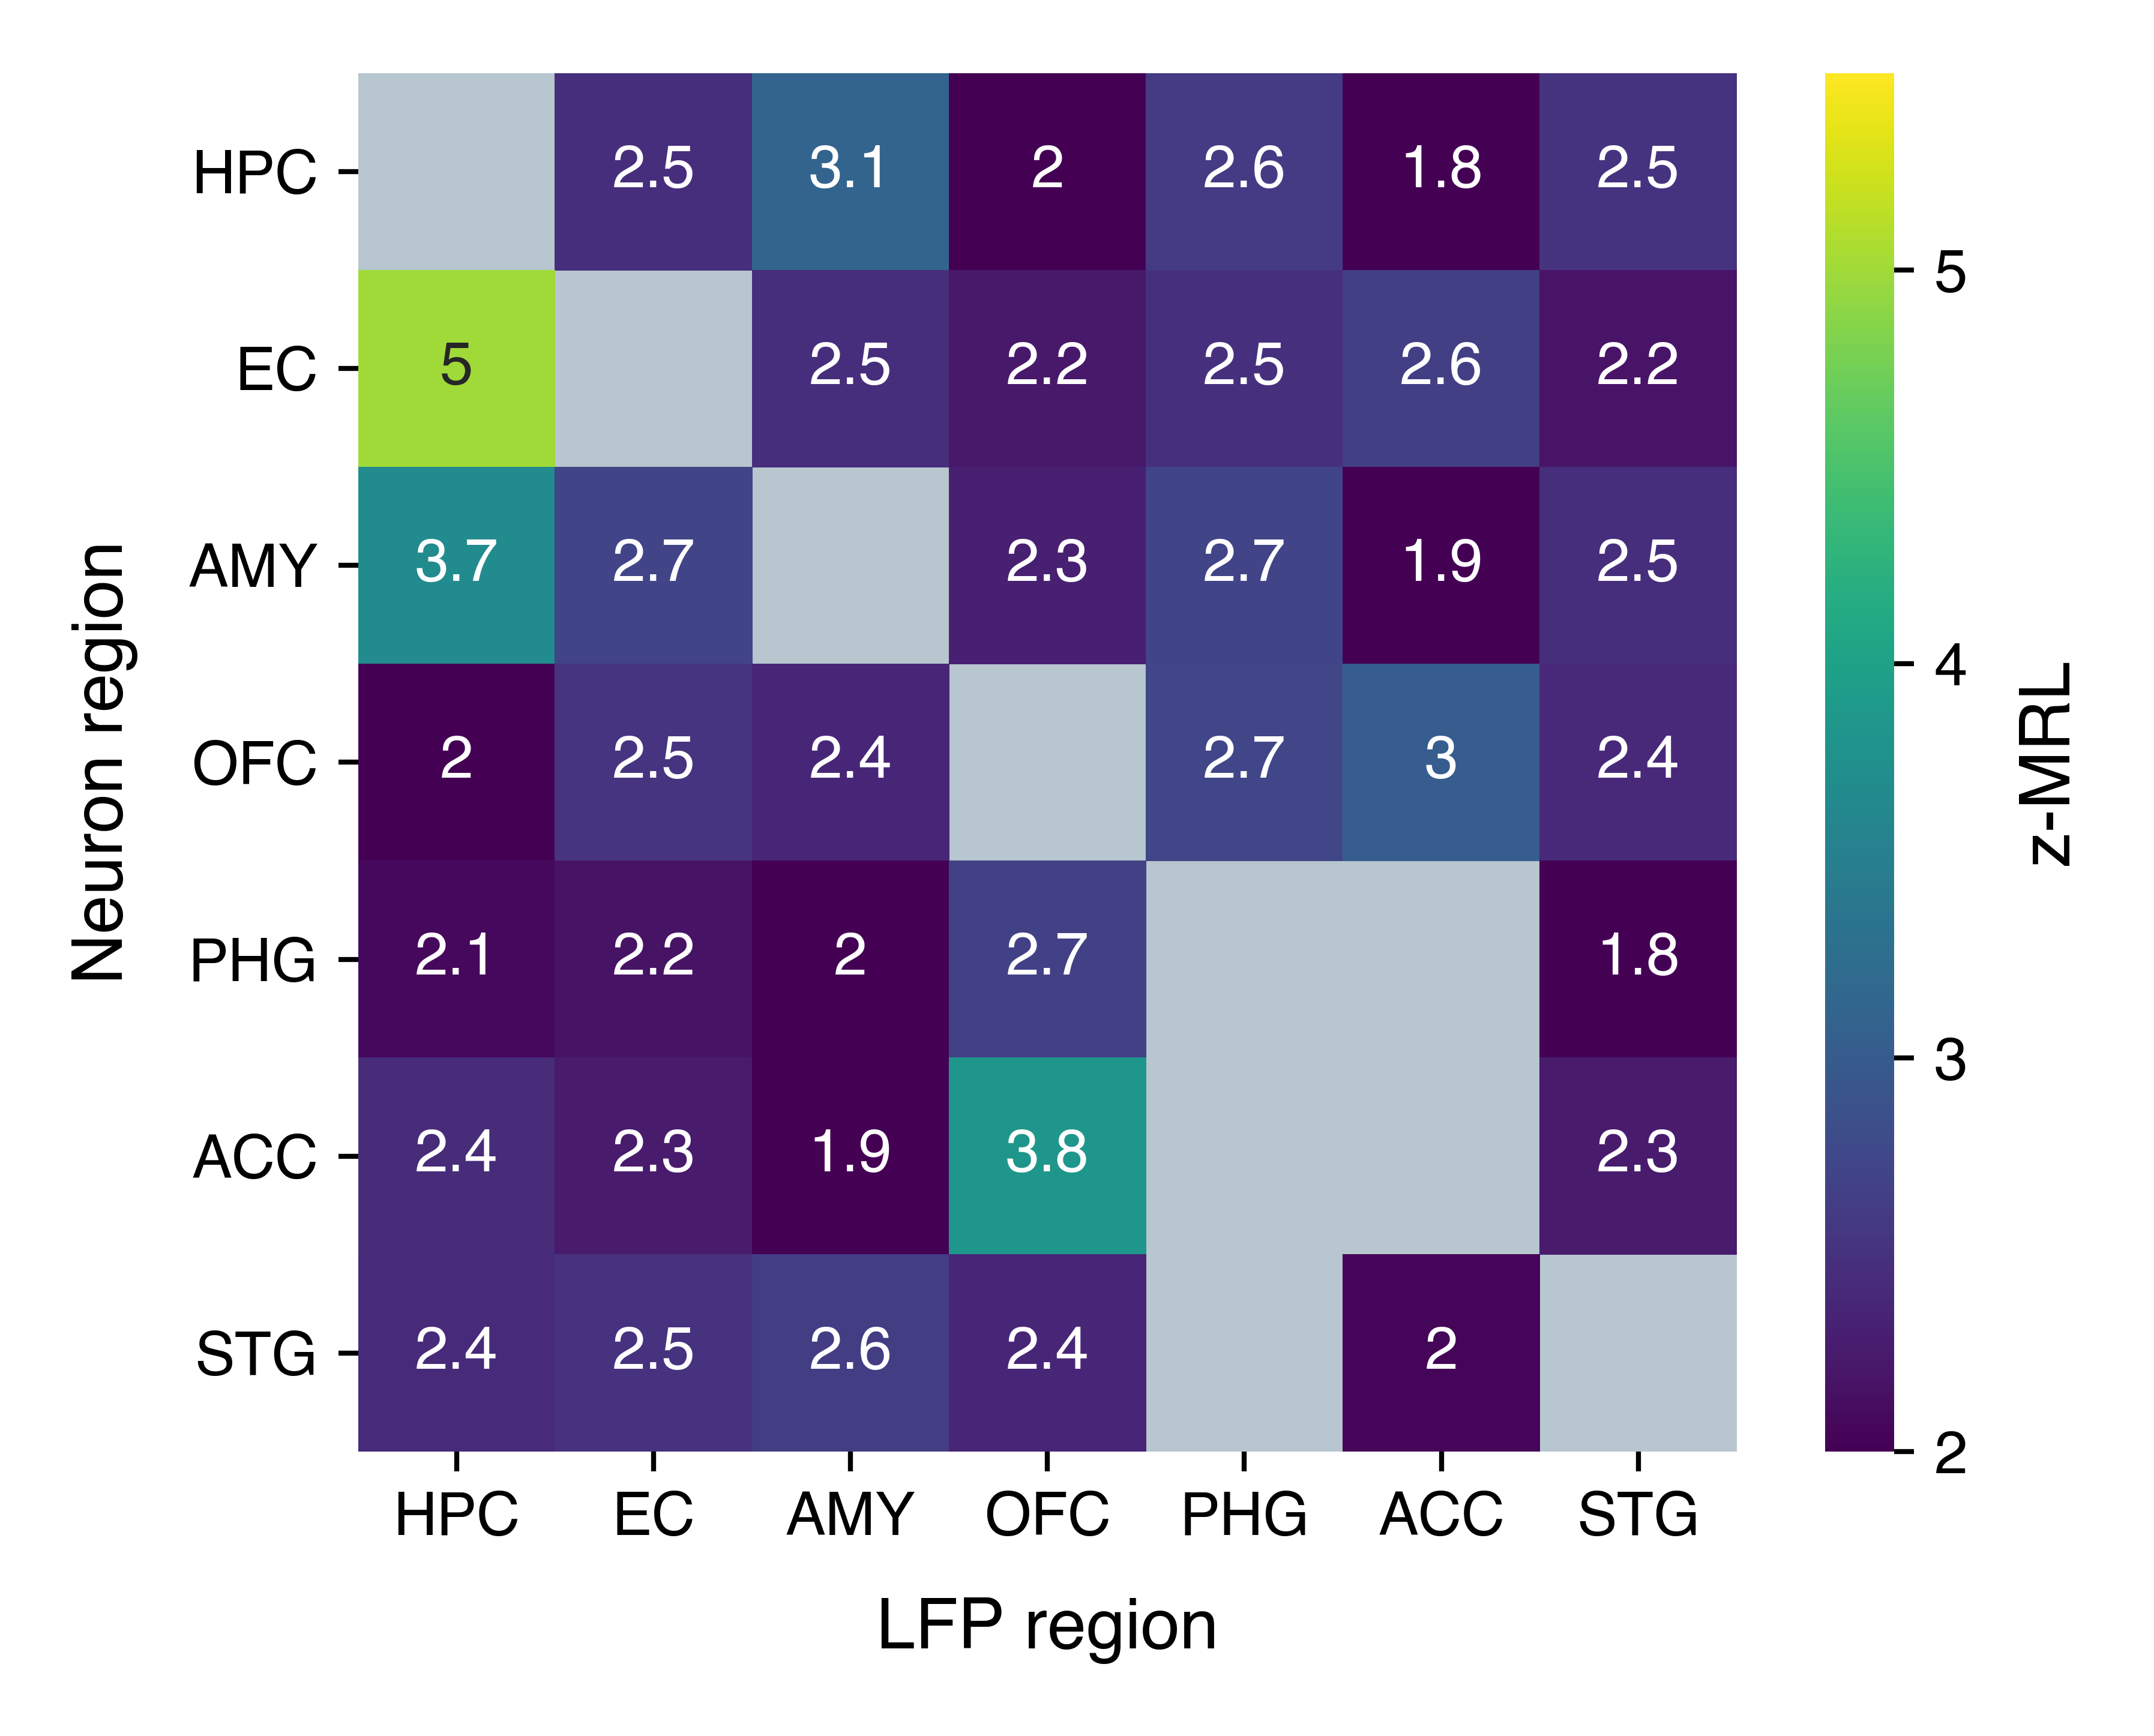

In [10]:
stat_col = 'max_z_mrl'
min_units = 5
min_subj = 4
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ax_facecolor = co['x2']
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'viridis'
vmin = 2
vmax = 5.5
cbarticks = [2, 3, 4, 5]
cbarlab = 'z-MRL'

# --------------------
# Get the data.
df = (pl_mrls
      .query("(mask=='lfp_and_unit')")
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'subj_sess_unit': lambda x: np.unique(x).size,
            stat_col: lambda x: 1 * np.mean(x)}))
df.columns = ['n_units', stat_col]
df = df.unstack('lfp_roi_gen')
dat = df[stat_col]

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, vmin=vmin, vmax=vmax, ax=_ax,
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.set_facecolor(ax_facecolor)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)

fig.show()

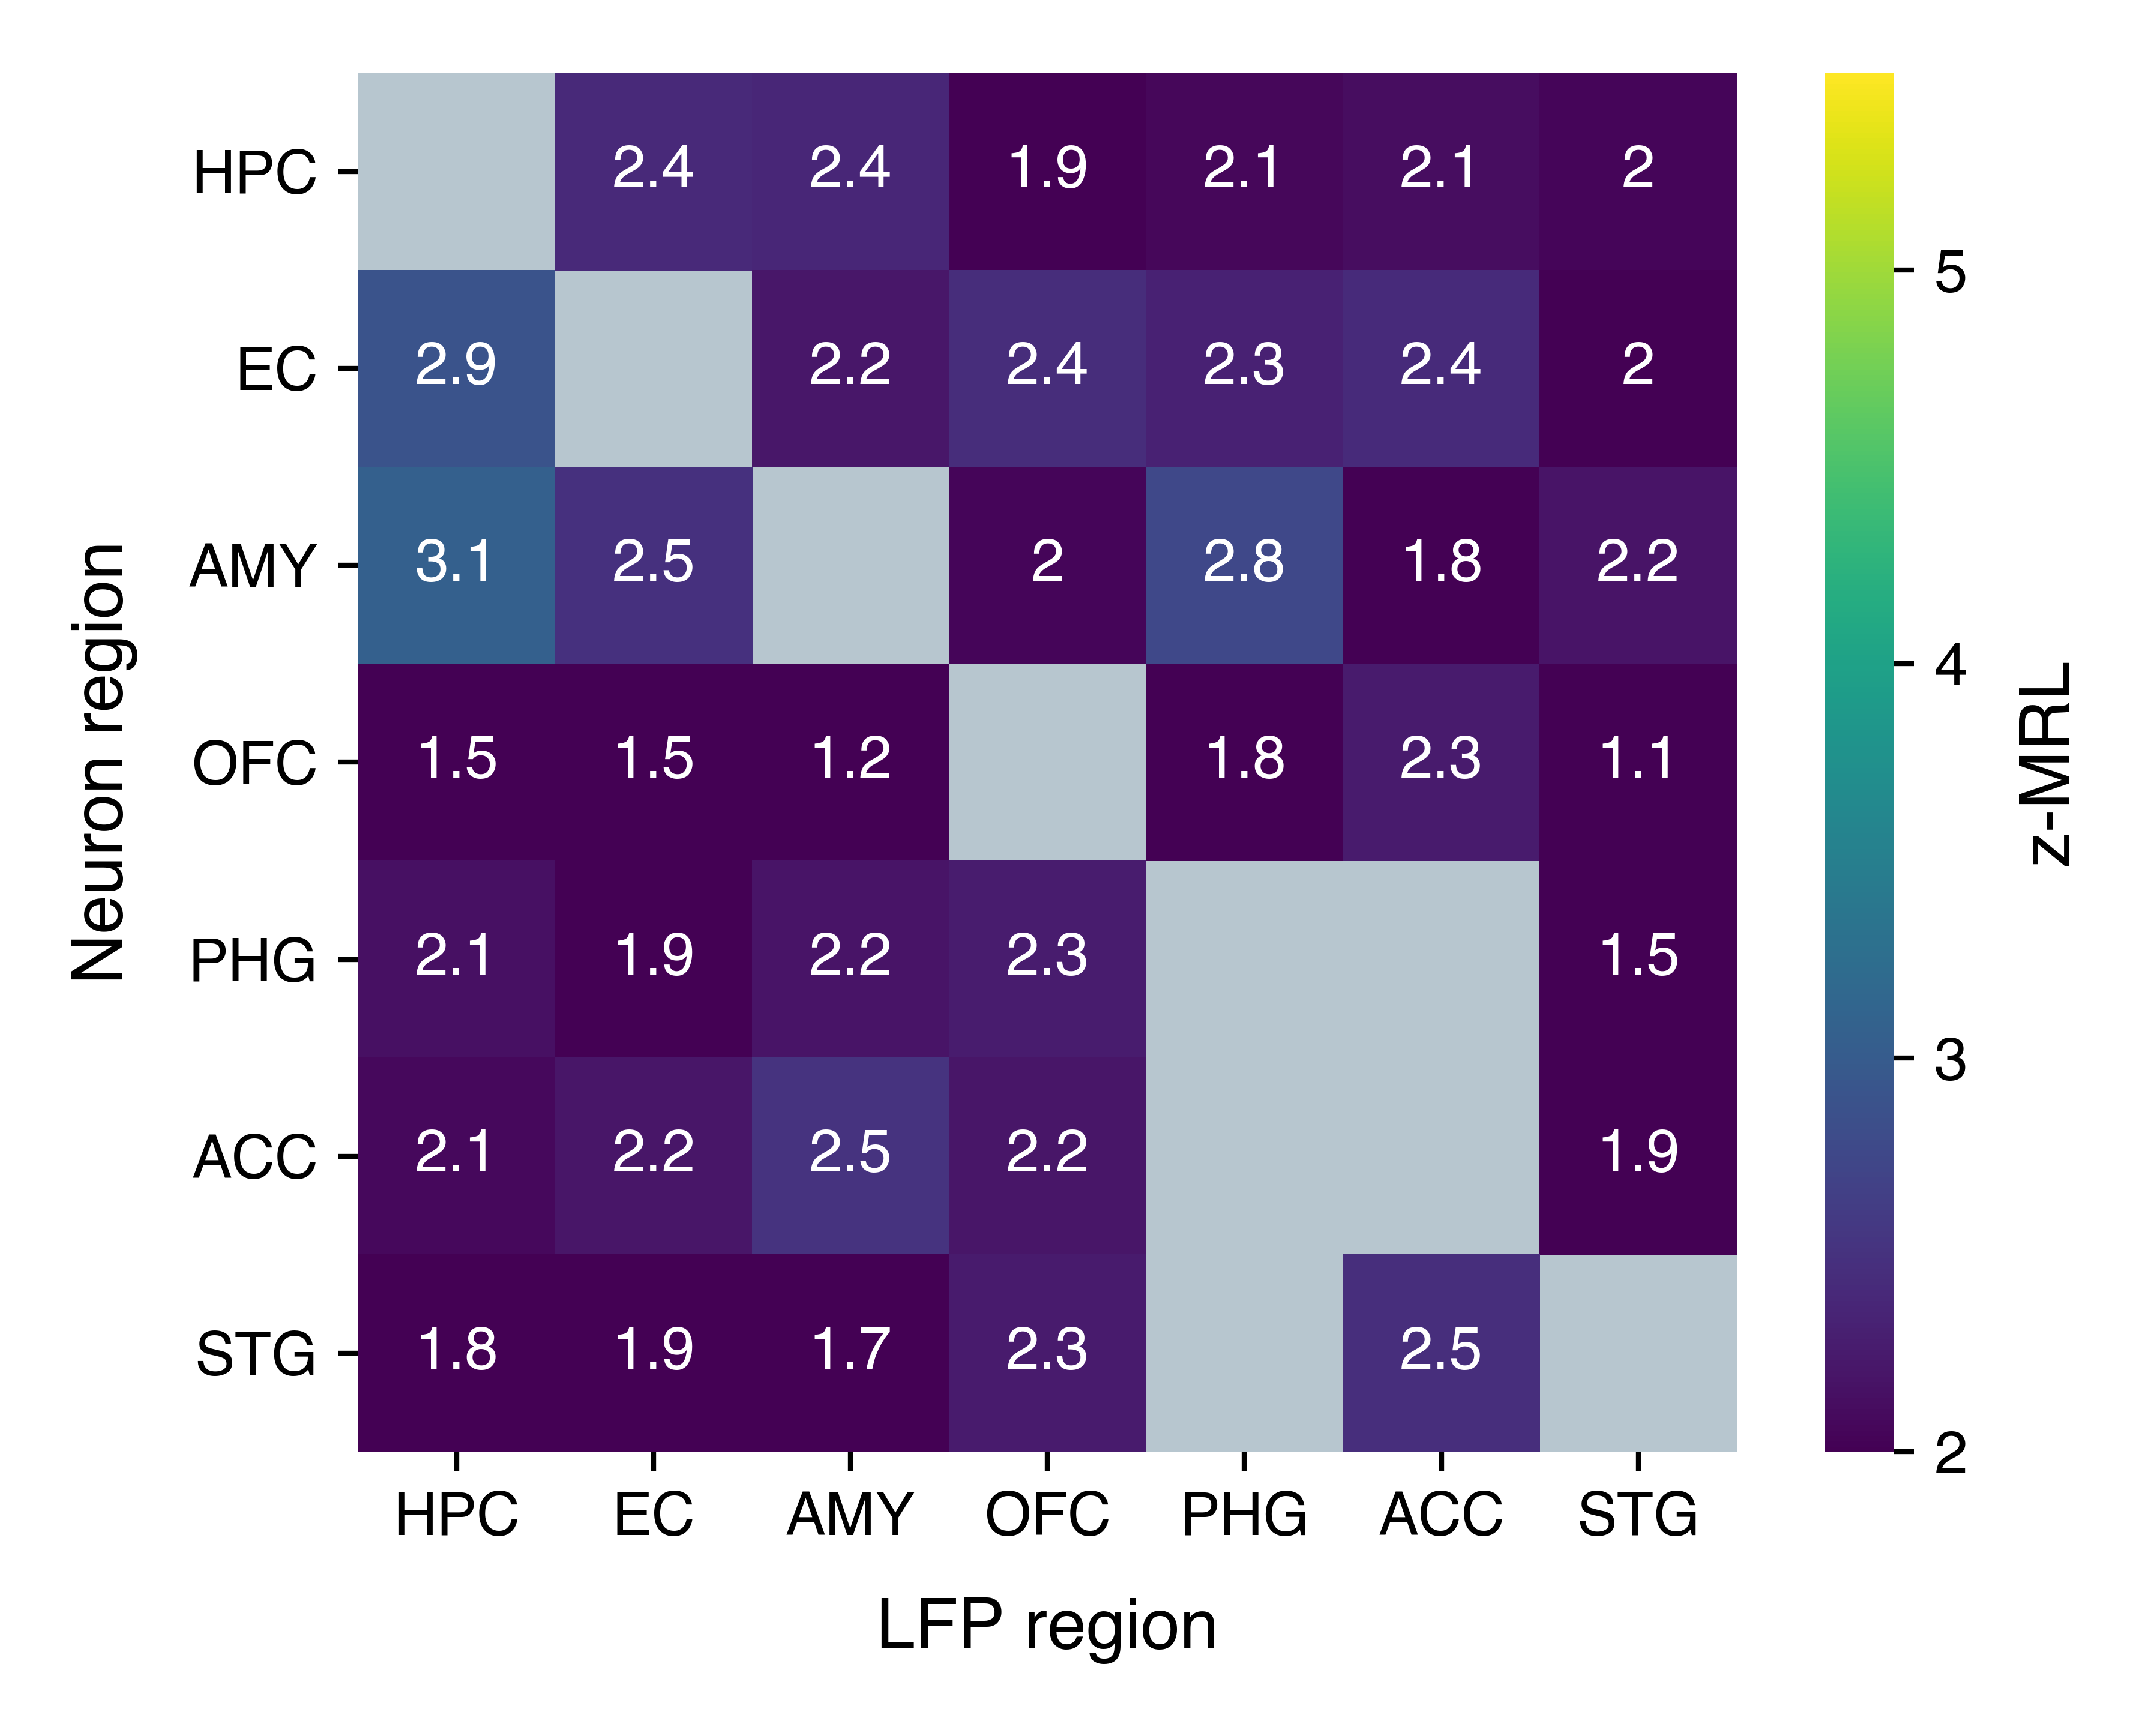

In [11]:
stat_col = 'max_z_mrl'
min_units = 5
min_subj = 4
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ax_facecolor = co['x2']
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'viridis'
vmin = 2
vmax = 5.5
cbarticks = [2, 3, 4, 5]
cbarlab = 'z-MRL'

# --------------------
# Get the data.
df = (pl_mrls
      .query("(mask=='lfp_not_unit')")
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'subj_sess_unit': lambda x: np.unique(x).size,
            stat_col: lambda x: 1 * np.mean(x)}))
df.columns = ['n_units', stat_col]
df = df.unstack('lfp_roi_gen')
dat = df[stat_col]

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, vmin=vmin, vmax=vmax, ax=_ax,
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.set_facecolor(ax_facecolor)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)

fig.show()

In [23]:
pl_osc2_flat.head()

name,expmt,subj_sess_unit,subj,subj_sess,unit,unit_hemroi,unit_roi,unit_roi_gen,unit_roi_gen2,n_spikes,fr,lfp_hemroi,lfp_hpc_div,lfp_roi,lfp_roi_gen,lfp_roi_gen2,lfp_chans,edge,is_local,same_hem,same_roi_gen,comp_hemroi,comp_roi_gen,mask,peps,max_pep,max_pep_freq,n_spikes_mask,max_n_spikes_mask,max_n_spikes_mask_null,mrls,max_mrl,max_mrl_freq,max_mrl_null,max_mrl_freq_null,mean_mrls_null,std_mrls_null,pref_phases,max_pref_phase,max_z_pref_phase,z_n_spikes_mask,z_mrls,max_z_mrl,max_z_mrl_freq,max_z_mrl_null,max_z_mrl_freq_null,pval,sig,pval_fdr,sig_fdr
0,ycab,U369_ses1-1-0,U369,U369_ses1,1-0,RA,A,AMY,MTL,1708,1.498246,RA,,A,AMY,MTL,"[2, 3, 4, 5, 6, 7, 8]",ctx-local,True,True,True,RMH,HPC,target_not_comp,"[0.2904260651629073, 2.5898370927318295, 2.432...",3.014524,5,"[4.714286, 53.285713, 56.857143, 65.85714, 90....",90.142860,52.764702,"[0.47957408, 0.16537452, 0.23341267, 0.1672304...",0.479574,1,0.603659,1,"[0.5314905165084638, 0.17368610914647578, 0.17...","[0.17314763026226748, 0.041101124145749145, 0....","[0.78010464, -0.9423785, -0.31527463, 2.971513...",0.780105,-0.315275,"[0.56484073, 2.8086648, 2.110995, 3.9129126, 4...","[-0.29983911502516297, -0.20222297755667354, 1...",1.334226,3,2.162101,3,0.851515,False,0.742795,False
1,ycab,U369_ses1-17-14,U369,U369_ses1,17-14,RST,ST,STG,CTX,22015,19.311404,RMH,post,MH,HPC,HPC,"[9, 10, 11, 12, 13, 14, 15, 16]",ctx-hpc,False,True,False,RST,LTC,target_not_comp,"[0.022028508771929824, 2.1904276315789475, 5.5...",7.914386,3,"[0.625, 153.75, 425.125, 833.125, 579.5, 236.2...",1047.125000,1021.739319,"[0.47473082, 0.073214106, 0.055328786, 0.04555...",0.474731,1,0.437286,1,"[0.42972979671005157, 0.0679967856572941, 0.04...","[0.19516947200578294, 0.013015377577063647, 0....","[-1.3463116, -0.9394948, 3.0050285, -2.9184775...",-1.346312,-2.918478,"[-3.0740445, -2.1125948, -1.0868173, -1.470742...","[0.23057408667040352, 0.40085818283369057, 1.4...",2.169824,4,2.176300,7,0.468153,False,1.000000,False
2,ycab,U369_ses1-17-14,U369,U369_ses1,17-14,RST,ST,STG,CTX,22015,19.311404,RST,,ST,STG,CTX,"[18, 20, 21, 22, 23, 24]",ctx-local,True,True,True,RMH,HPC,target_not_comp,"[0.15859649122807018, 0.7945760233918129, 1.09...",45.414371,6,"[34.166668, 143.66667, 232.0, 513.5, 1618.6666...",5090.666504,5163.851074,"[0.48734415, 0.07330972, 0.06842086, 0.1205190...",0.487344,1,0.337133,1,"[0.3359020697489381, 0.08728708207234741, 0.06...","[0.052522746303390946, 0.020911668138166153, 0...","[-2.446102, -1.5307168, 0.07426882, -0.3356313...",-2.446102,-0.517696,"[0.040208004, -1.3346188, -0.5822966, -0.38365...","[2.8833617181995277, -0.6684001686267499, 0.15...",43.188407,6,2.224078,3,0.000100,True,0.000390,True
3,ycab,U369_ses1-18-15,U369,U369_ses1,18-15,RST,ST,STG,CTX,17152,15.045614,RMH,post,MH,HPC,HPC,"[9, 10, 11, 12, 13, 14, 15, 16]",ctx-hpc,False,True,False,RST,LTC,target_not_comp,"[0.05339912280701754, 2.135877192982456, 5.546...",7.838048,3,"[6.125, 147.0, 330.0, 712.5, 432.0, 169.25, 23...",788.000000,791.591614,"[0.4717466, 0.09781644, 0.060327366, 0.0192279...",0.471747,1,0.348088,1,"[0.3322256308605894, 0.07637092830464244, 0.04...","[0.1324605371456735, 0.014503108520499472, 0.0...","[1.680169, 2.8689554, -2.219887, -2.9075878, -...",1.680169,2.138772,"[-1.2731668, -0.27775124, -1.0165381, -0.00442...","[1.0533021068737836, 1.4786836317110355, 1.215...",2.619403,7,2.170561,6,0.243476,False,1.000000,False
4,ycab,U369_ses1-18-15,U369,U369_ses1,18-15,RST,ST,STG,CTX,17152,15.045614,RST,,ST,STG,CTX,"[17, 20, 21, 22, 23, 24]",ctx-local,True,True,True,RMH,HPC,target_not_comp,"[0.15596491228070175, 0.8048245614035088, 1.04...",45.699123,6,"[23.833334, 137.5, 183.33333, 403.33334, 1264....",4053.666748,4057.106689,"[0.19646326, 0.07980352, 0.070597045, 0.059041...",0.243340,29,0.262665,1,"[0.23148130298107863, 0.09533363307956606, 0.0...","[0.06309125763888312, 0.02320013740861805, 0.0...","[2.6378183, -1.7515951, 2.7655017, 2.5947304, ...",-0.489745,1.779246,"[0.030731924, 0.362295, 1.175075, -0

In [41]:
mask = 'target_and_comp'
unit_roi_gen = 'EC'
lfp_roi_gen = 'HPC'
qry = ("(unit_roi_gen=='{}') & (lfp_roi_gen=='{}') & (sig_fdr==True)"
       .format(unit_roi_gen, lfp_roi_gen))
sig_cells = (pl_osc2_flat
             .query(qry)
             .sort_values('max_z_mrl', ascending=False)
             .drop_duplicates('subj_sess_unit')
             .sort_values('max_z_mrl_freq')
             ['subj_sess_unit'].tolist())
_pl_mrls = pl_mrls.query("(unit_roi_gen=='{}') & (lfp_roi_gen=='{}') & (subj_sess_unit=={})"
                         .format(unit_roi_gen, lfp_roi_gen, sig_cells)).copy()
_pl_mrls.insert(0, 'order', _pl_mrls['subj_sess_unit'].apply(lambda x: sig_cells.index(x)))
_pl_mrls = _pl_mrls.sort_values('order').reset_index(drop=True)

EC to HPC: 83/206 (40.3%)
target_and_comp: vmin=0.0, vmax=16.0
target_not_comp: vmin=0.0, vmax=16.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_83EC-neurons-to-HPC_osc2mask_heatmaps.pdf
AMY to HPC: 71/230 (30.9%)
target_and_comp: vmin=0.0, vmax=16.0
target_not_comp: vmin=0.0, vmax=16.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_71AMY-neurons-to-HPC_osc2mask_heatmaps.pdf
CTX to HPC: 14/370 (3.8%)
target_and_comp: vmin=0.0, vmax=16.0
target_not_comp: vmin=0.0, vmax=16.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_14CTX-neurons-to-HPC_osc2mask_heatmaps.pdf
EC to EC: 58/180 (32.2%)
target_and_comp: vmin=0.0, vmax=16.0
target_not_comp: vmin=0.0, vmax=16.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_58EC-neurons-to-EC_osc2mask_heatmaps.pdf
AMY to AMY: 94/229 (41.0%)
target_and_comp: vmin=0.0, vmax=16.0
tar

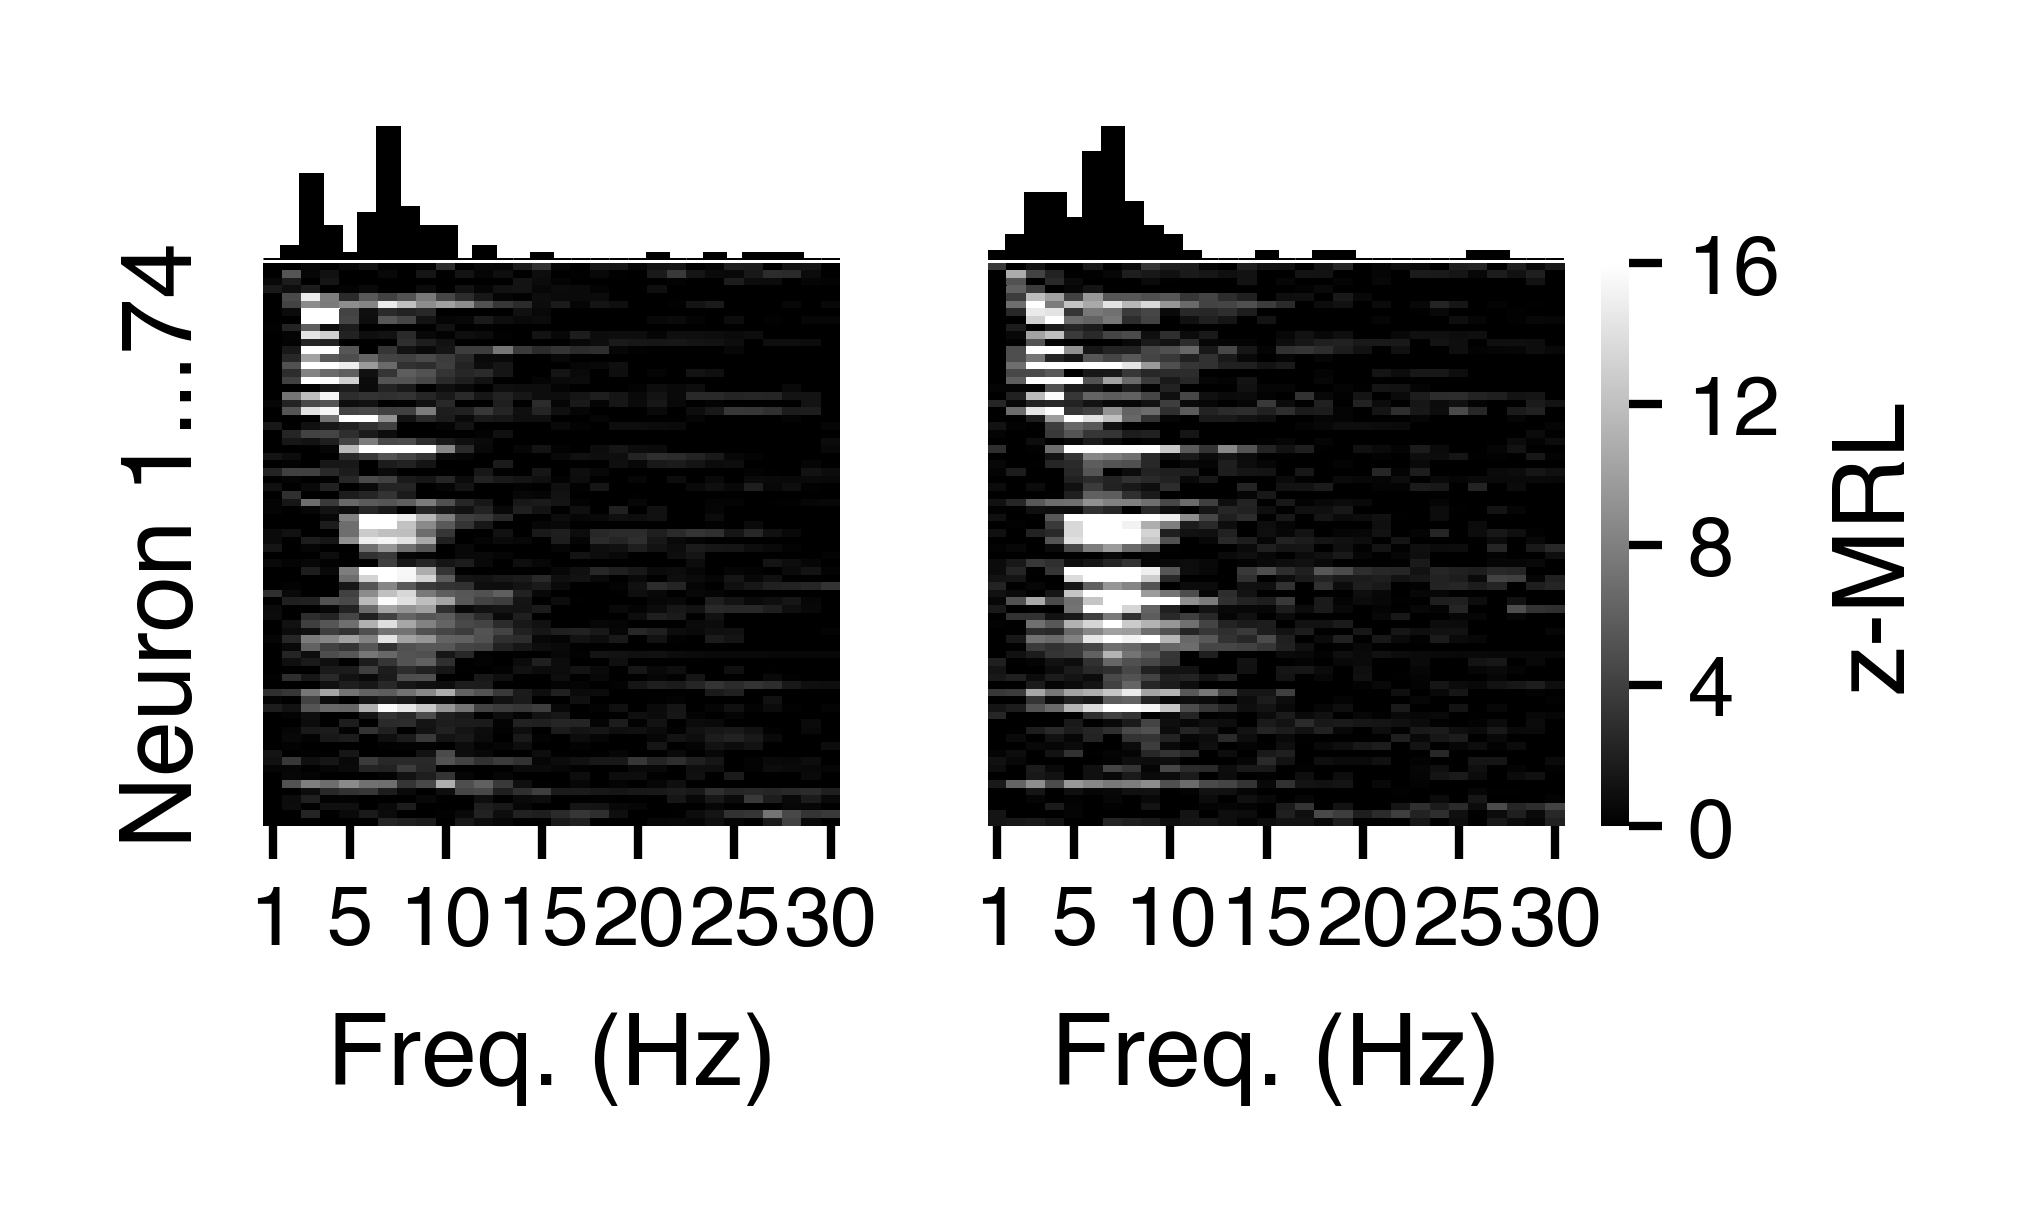

In [71]:
keep_pairs = [
    ('EC', 'HPC'),
    ('AMY', 'HPC'),
    ('CTX', 'HPC'),
    ('EC', 'EC'),
    ('AMY', 'AMY'),
    ('CTX', 'CTX'),
]
keep_masks = ['target_and_comp', 'target_not_comp']
savefig = 1
overwrite = 1
figsize = (colws[1], colws[1]*(50/100))
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
labelpad = 3
ticklen = 2
tickpad = 1.5
freqs = np.arange(1, 31)
density = True
hist_lw = 0.3
hist_ec = 'k'
hist_barcolor = 'k'
hist_spinecolor = None
xlim = [1, 30]
xticks = np.array([1, 5, 10, 15, 20, 25, 30]) - 0.5
xticklabs = (xticks + 0.5).astype(int)
cmap = 'binary_r' #'mako'
vmin = 0
vmax = 16
vticks = np.linspace(vmin, vmax, 5).astype(int)
rescale = False
redefine_vmax = True
vmax_thresh = 0.8

# -----------------------
for (unit_roi_gen, lfp_roi_gen) in keep_pairs:
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    grid_shp = [50, 100]
    ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 0), rowspan=40, colspan=50),
          plt.subplot2grid(grid_shp, (0, 50), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 50), rowspan=40, colspan=50)]
    
    if unit_roi_gen in ['CTX', 'MTL']:
        roi_col = 'roi_gen2'
    else:
        roi_col = 'roi_gen'
    qry = ("(unit_{}=='{}') & (lfp_{}=='{}') & (sig_fdr==True)"
           .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
    sig_cells = (pl_osc2_flat
                 .query(qry)
                 .sort_values('max_z_mrl', ascending=False)
                 .drop_duplicates('subj_sess_unit')
                 .sort_values('max_z_mrl_freq')
                 ['subj_sess_unit'].tolist())
    n = (pl_osc2_flat
         .query("(unit_{}=='{}') & (lfp_{}=='{}')"
                .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
         ['subj_sess_unit'].nunique())
    nsig = len(sig_cells)
    _pl_osc2_flat = pl_osc2_flat.query("(unit_{}=='{}') & (lfp_{}=='{}') & (subj_sess_unit=={})"
                                       .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen, sig_cells)).copy()
    _pl_osc2_flat.insert(0, 'order', _pl_osc2_flat['subj_sess_unit'].apply(lambda x: sig_cells.index(x)))
    _pl_osc2_flat = _pl_osc2_flat.sort_values('order').reset_index(drop=True)
    print('{} to {}: {}/{} ({:.1%})'.format(unit_roi_gen, lfp_roi_gen, nsig, n, nsig/n))
    if len(sig_cells) == 0:
        continue
        
    for iMask, mask in enumerate(keep_masks):
        # Histogram.
        iax = (2*iMask) + 0
        _ax = ax[iax]

        qry = ("(mask=='{}') & (unit_{}=='{}') & (lfp_{}=='{}')"
               .format(mask, roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
        _counts = _pl_osc2_flat.query(qry).groupby('max_z_mrl_freq').size()
        hist = np.array([_counts.get(freq, 0) for freq in freqs])
        if density:
            hist = hist / hist.sum()
        _ax.bar(freqs-0.5, hist, width=1, lw=hist_lw, color=hist_barcolor, ec=hist_ec)
        _ax.set_xlim([0, len(freqs)])
        _ax.set_xticks(np.arange(len(freqs))[::2]+0.5)
        _ax.set_xticklabels('')
        _ax.set_xticks([])
        _ax.set_yticks([])
        _ax.set_xlabel('')
        _ax.set_ylabel('')
        for spine in ['left', 'bottom']:
        #     _ax.spines[spine].set_visible(False)
            _ax.spines[spine].set_edgecolor(hist_spinecolor)
        _ax.grid(False)

        # Heatmap.
        iax += 1
        _ax = ax[iax]

        dat = np.array(_pl_osc2_flat.query(qry).sort_values('order')['z_mrls'].tolist())
        if rescale:
            dat = ((dat - np.nanmin(dat, axis=1)[:, None]) /
                   (np.nanmax(dat, axis=1)[:, None] - np.nanmin(dat, axis=1)[:, None]))
            vmin = 0
            vmax = 1
            vticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
        elif (vmin is None) or (vmax is None):
            vmin = z_thresh
            if redefine_vmax:
                vmax = np.quantile(np.nanmax(dat, axis=1), vmax_thresh)
            vticks = np.linspace(vmin, vmax, 5).astype(int)

        dat[np.isnan(dat)] = 0
        n_neurons = dat.shape[0]
        print('{}: vmin={:.1f}, vmax={:.1f}'.format(mask, vmin, vmax))

        sns.heatmap(dat, ax=_ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True)
        _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
        _ax.set_xlim([0, len(freqs)])
        _ax.set_xticks(xticks)
        _ax.set_xticklabels(xticklabs)
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_yticks([])
        if iMask == 0:
            _ax.set_ylabel('Neuron 1...{}'.format(n_neurons), fontsize=font['label'], labelpad=labelpad)
            _ax.collections[0].colorbar.remove()
        else:
            cbar = _ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
            cbar.set_ticks(vticks)
            cbar.set_ticklabels(vticks)
            cbar.set_label('z-MRL', fontsize=font['label'], labelpad=labelpad)

    if savefig:
        filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 'phase_lock_freqs',
                           'all-sig-fdr_{}{}-neurons-to-{}_osc2mask_heatmaps.pdf'
                           .format(n_neurons, unit_roi_gen, lfp_roi_gen))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
            print('Saved {}'.format(filename))
    
fig.show()

EC to HPC: 83/206 (40.3%)
EC to HPC, osc2 - osc1: 83 neurons, vmin=-4.4, vmax=10.3
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_83EC-neurons-to-HPC_osc2mask_diff_heatmaps.pdf
AMY to HPC: 71/230 (30.9%)
AMY to HPC, osc2 - osc1: 71 neurons, vmin=-5.0, vmax=10.5
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_71AMY-neurons-to-HPC_osc2mask_diff_heatmaps.pdf
CTX to HPC: 14/370 (3.8%)
CTX to HPC, osc2 - osc1: 14 neurons, vmin=-4.5, vmax=8.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_14CTX-neurons-to-HPC_osc2mask_diff_heatmaps.pdf
EC to EC: 58/180 (32.2%)
EC to EC, osc2 - osc1: 58 neurons, vmin=-4.4, vmax=7.2
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/phase_lock_freqs/all-sig-fdr_58EC-neurons-to-EC_osc2mask_diff_heatmaps.pdf
AMY to AMY: 94/229 (41.0%)
AMY to AMY, osc2 - osc1: 94 neurons, vmin=-5.3, vmax=9.3
Saved /home1/dscho/projects/unit

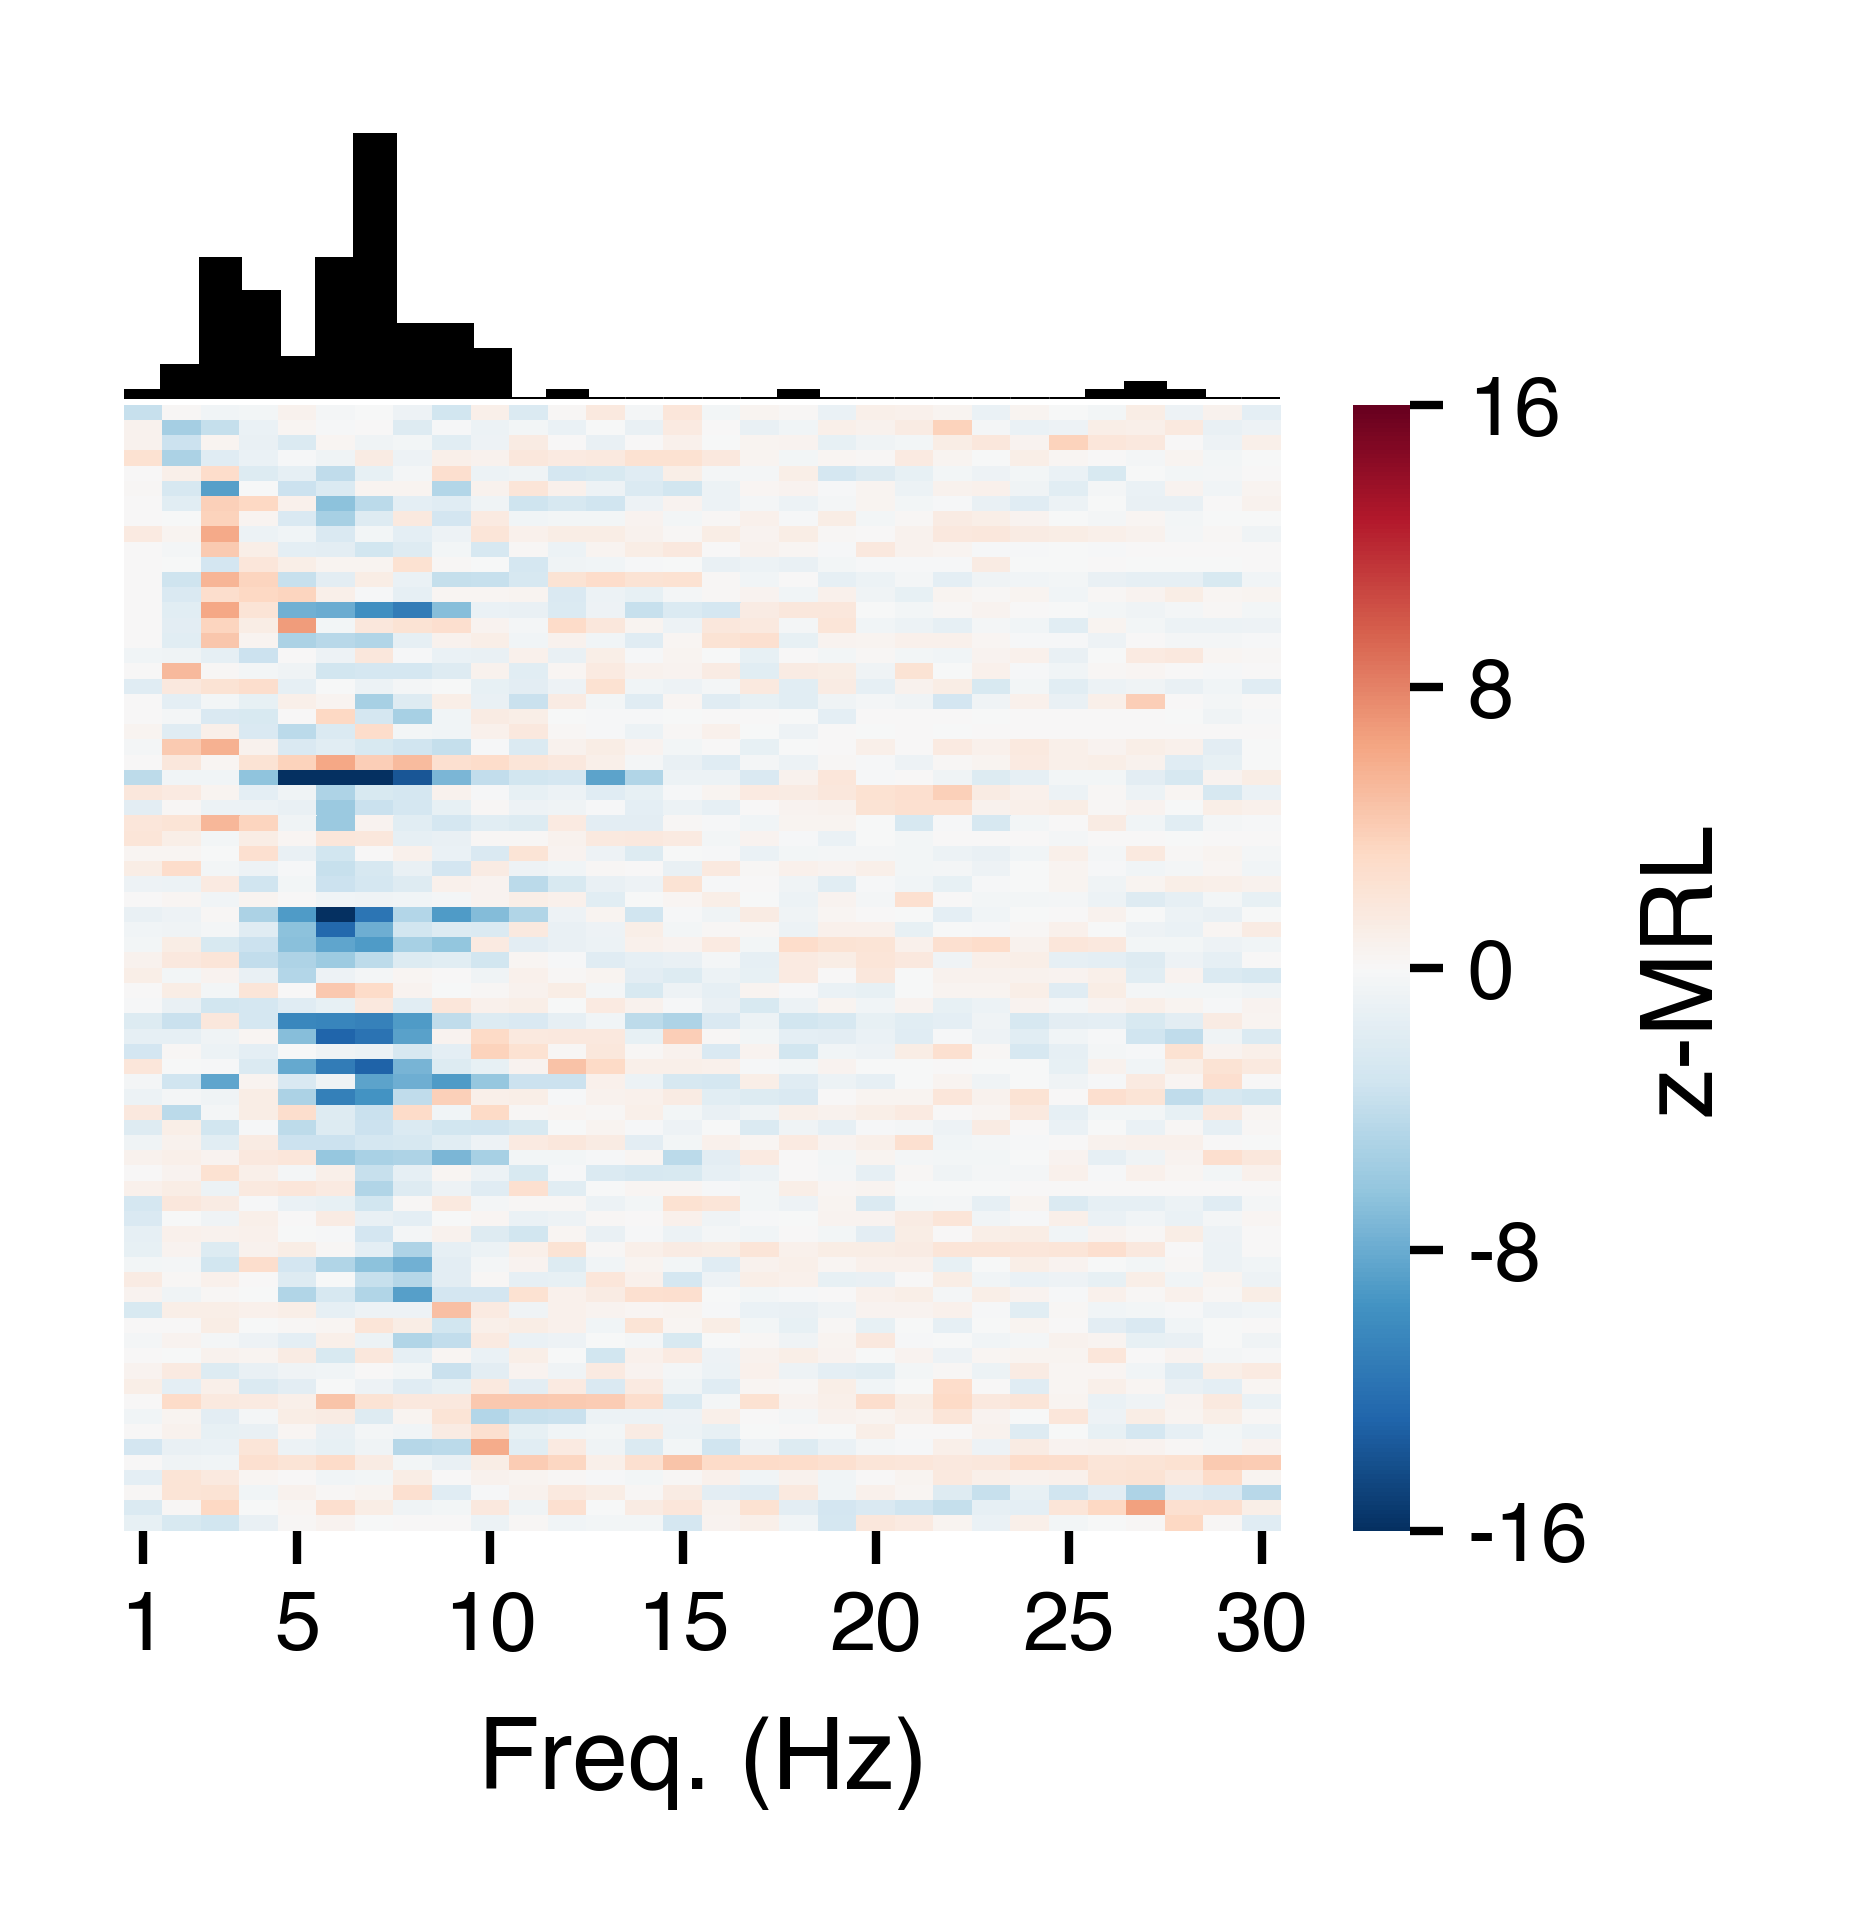

In [99]:
keep_pairs = [
    ('EC', 'HPC'),
    ('AMY', 'HPC'),
    ('CTX', 'HPC'),
    ('EC', 'EC'),
    ('AMY', 'AMY'),
    ('CTX', 'CTX'),
]
keep_masks = ['target_and_comp', 'target_not_comp']
savefig = 0
overwrite = 1
figsize = (colws[1], colws[1])
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
labelpad = 3
ticklen = 2
tickpad = 1.5
freqs = np.arange(1, 31)
density = True
hist_lw = 0.3
hist_ec = 'k'
hist_barcolor = 'k'
hist_spinecolor = None
xlim = [1, 30]
xticks = np.array([1, 5, 10, 15, 20, 25, 30]) - 0.5
xticklabs = (xticks + 0.5).astype(int)
cmap = 'RdBu_r' #'binary_r'
vmin = -16
vmax = 16
vticks = np.linspace(vmin, vmax, 5).astype(int)
rescale = False
redefine_vmax = True
vmax_thresh = 0.8

# -----------------------
for (unit_roi_gen, lfp_roi_gen) in keep_pairs:
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    grid_shp = [50, 50]
    ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 0), rowspan=40, colspan=50)]
    
    if unit_roi_gen in ['CTX', 'MTL']:
        roi_col = 'roi_gen2'
    else:
        roi_col = 'roi_gen'
    qry = ("(unit_{}=='{}') & (lfp_{}=='{}') & (sig_fdr==True)"
           .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
    sig_cells = (pl_osc2_flat
                 .query(qry)
                 .sort_values('max_z_mrl', ascending=False)
                 .drop_duplicates('subj_sess_unit')
                 .sort_values('max_z_mrl_freq')
                 ['subj_sess_unit'].tolist())
    n = (pl_osc2_flat
         .query("(unit_{}=='{}') & (lfp_{}=='{}')"
                .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
         ['subj_sess_unit'].nunique())
    nsig = len(sig_cells)
    _pl_osc2_flat = pl_osc2_flat.query("(unit_{}=='{}') & (lfp_{}=='{}') & (subj_sess_unit=={})"
                                       .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen, sig_cells)).copy()
    _pl_osc2_flat.insert(0, 'order', _pl_osc2_flat['subj_sess_unit'].apply(lambda x: sig_cells.index(x)))
    _pl_osc2_flat = _pl_osc2_flat.sort_values('order').reset_index(drop=True)
    print('{} to {}: {}/{} ({:.1%})'.format(unit_roi_gen, lfp_roi_gen, nsig, n, nsig/n))
    if len(sig_cells) == 0:
        continue
        
    # Histogram.
    iax = 0
    _ax = ax[iax]

    _counts = _pl_osc2_flat.query(qry).groupby('max_z_mrl_freq').size()
    hist = np.array([_counts.get(freq, 0) for freq in freqs])
    if density:
        hist = hist / hist.sum()
    _ax.bar(freqs-0.5, hist, width=1, lw=hist_lw, color=hist_barcolor, ec=hist_ec)
    _ax.set_xlim([0, len(freqs)])
    _ax.set_xticks(np.arange(len(freqs))[::2]+0.5)
    _ax.set_xticklabels('')
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.set_xlabel('')
    _ax.set_ylabel('')
    for spine in ['left', 'bottom']:
    #     _ax.spines[spine].set_visible(False)
        _ax.spines[spine].set_edgecolor(hist_spinecolor)
    _ax.grid(False)

    # Heatmap.
    iax += 1
    _ax = ax[iax]
    
    warnings.filterwarnings('ignore')
    qry_osc2 = ("(mask=='target_and_comp') & (unit_{}=='{}') & (lfp_{}=='{}')"
                .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
    qry_osc1 = ("(mask=='target_not_comp') & (unit_{}=='{}') & (lfp_{}=='{}')"
                .format(roi_col, unit_roi_gen, roi_col, lfp_roi_gen))
    dat_osc2 = np.array(_pl_osc2_flat
                        .query(qry_osc2)
                        .groupby(['subj_sess_unit'], sort=False)
                        ['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))
                        .tolist())
    dat_osc1 = np.array(_pl_osc2_flat
                        .query(qry_osc1)
                        .groupby(['subj_sess_unit'], sort=False)
                        ['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))
                        .tolist())
    dat = dat_osc2 - dat_osc1
    dat[np.isnan(dat)] = 0
    n_neurons = dat.shape[0]
    warnings.resetwarnings()
    if rescale:
        dat = ((dat - np.nanmin(dat, axis=1)[:, None]) /
               (np.nanmax(dat, axis=1)[:, None] - np.nanmin(dat, axis=1)[:, None]))
        vmin = 0
        vmax = 1
        vticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    elif (vmin is None) or (vmax is None):
        vmin = z_thresh
        if redefine_vmax:
            vmax = np.quantile(np.nanmax(dat, axis=1), vmax_thresh)
        vticks = np.linspace(vmin, vmax, 5).astype(int)
    print('{} to {}, osc2 - osc1: {} neurons, vmin={:.1f}, vmax={:.1f}'
          .format(unit_roi_gen, lfp_roi_gen, n_neurons,
                  np.quantile(np.nanmin(dat, axis=1), 0.1),
                  np.quantile(np.nanmax(dat, axis=1), 0.9)))
    
    sns.heatmap(dat, ax=_ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
    _ax.set_xlim([0, len(freqs)])
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_yticks([])
    if iMask == 0:
        _ax.set_ylabel('Neuron 1...{}'.format(n_neurons), fontsize=font['label'], labelpad=labelpad)
        _ax.collections[0].colorbar.remove()
    else:
        cbar = _ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
        cbar.set_ticks(vticks)
        cbar.set_ticklabels(vticks)
        cbar.set_label('z-MRL', fontsize=font['label'], labelpad=labelpad)

    if savefig:
        filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 'phase_lock_freqs',
                           'all-sig-fdr_{}{}-neurons-to-{}_osc2mask_diff_heatmaps.pdf'
                           .format(n_neurons, unit_roi_gen, lfp_roi_gen))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
            print('Saved {}'.format(filename))
    
fig.show()

# z-MRL by freq: region means

In [14]:
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']
sig_only = False
keep_rois = [x for x in gen_rois if x!='HPC']
keep_masks = ['target_and_comp', 'target_not_comp']

# -----------------------------
qry = ("(mask=={}) & (unit_roi_gen=={})"
       .format(keep_masks, keep_rois))
n_units = (pl_osc2_flat
           .query(qry)
           .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'], observed=True)
           ['subj_sess_unit'].nunique())
n_pl_units = (pl_osc2_flat
              .query(qry + " & (sig_fdr==True)")
              .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'], observed=True)
              ['subj_sess_unit'].nunique())

zmrls = []
for mask in keep_masks:
    for unit_roi in keep_rois:
        for lfp_roi in pl_osc2_flat['lfp_roi_gen'].unique():
            qry = ("(mask=='{}') & (unit_roi_gen=='{}') & (lfp_roi_gen=='{}')"
                   .format(mask, unit_roi, lfp_roi))
            if sig_only:
                qry += " & (sig_fdr==True)"
            _zmrls = np.array(pl_osc2_flat.query(qry)['z_mrls'].tolist())
            if len(_zmrls) > 0:
                _n_subjs = pl_osc2_flat.query(qry)['subj'].nunique()
                _n_units = _zmrls.shape[0]
                _n_pl_units = n_pl_units.get((mask, unit_roi, lfp_roi), 0)
                pct_pl_units = 100 * (_n_pl_units/n_units.get((mask, unit_roi, lfp_roi), 0))
                _mean_zmrls = np.nanmean(_zmrls, axis=0).tolist()
                _sem_zmrls = stats.sem(_zmrls, axis=0, nan_policy='omit').tolist()
                zmrls.append([mask, unit_roi, lfp_roi, _n_subjs, _n_units,
                              _n_pl_units, pct_pl_units, _mean_zmrls, _sem_zmrls, _zmrls.tolist()])
            
cols = ['mask', 'unit_roi', 'lfp_roi', 'subjs', 'units',
        'sig_fdr', 'pct_sig_fdr', 'mean_zmrls', 'sem_zmrls', 'zmrls']
zmrls = pd.DataFrame(zmrls, columns=cols).set_index(['mask', 'unit_roi', 'lfp_roi'])

print('sig_only = {}'.format(sig_only))
print('zmrls: {}'.format(zmrls.shape))

sig_only = False
zmrls: (24, 7)


In [15]:
zmrls

subjs  units  sig_fdr  pct_sig_fdr  \
mask            unit_roi lfp_roi                                       
target_and_comp EC       HPC         17    206       81    39.320388   
                         EC          15    180       56    31.111111   
                AMY      AMY         20    229       75    32.751092   
                         HPC         21    230       64    27.826087   
                PHG      HPC         14    102        0     0.000000   
                         PHG         14     94       17    18.085106   
                STG      HPC          5     92        3     3.260870   
                         STG          5     80       25    31.250000   
                OFC      HPC         13    105        7     6.666667   
                         OFC         13    111       10     9.009009   
                ACC      HPC          7     71        2     2.816901   
                         ACC          7     81        5     6.172840   
target_not_comp EC       HPC         17    206       28    13.592233   
                         EC          15    180       26    14.444444   
                AMY      AMY         20    229       70    30.567686   
                         HPC         21    230       35    15.217391   
                PHG      HPC         14    102        2     1.960784   
                         PHG         14     94       17    18.085106   
                STG      HPC          5     92        0     0.000000   
                         STG          5     80       30    37.500000   
                OFC      HPC         13    105        1     0.952381   
                         OFC         13    111        9     8.108108   
                ACC      HPC          7     71        0     0.000000   
                         ACC          7     81        6     7.407407   

                                                                         mean_zmrls  \
mask            unit_roi lfp_roi                                                      
target_and_comp EC       HPC      [0.02637135801641424, 0.9725196740891916, 1.16...   
                         EC       [0.01954057264851557, 0.615658637905457, 0.857...   
                AMY      AMY      [0.16873221638278219, 1.467850193543222, 1.956...   
                         HPC      [0.01122683508455425, 1.3067043058588663, 1.59...   
                PHG      HPC      [-0.012570540320758961, 0.08832468581368631, 0...   
                         PHG      [0.047430148640318484, 0.5036914172398183, 0.7...   
                STG      HPC      [-0.019518259344245465, -0.06304731264265707, ...   
                         STG      [-0.0736739384669998, 0.3065713121502074, 0.70...   
                OFC      HPC      [0.08255326483779409, 0.2880220002660378, 0.29...   
                         OFC      [-0.18645758058706544, 0.13872023322532331, 1....   
                ACC      HPC      [0.17753387914008492, 0.22663909338047256, 0.0...   
                         ACC      [0.05804715375804912, 0.10258486387169763, -0....   
target_not_comp EC       HPC      [0.05165853698054607, 0.29680260018703275, 0.3...   
                         EC       [0.18177503284451396, 0.22562294131405364, 0.4...   
                AMY      AMY      [-0.020737088757439737, 1.1406660194870808, 1....   
                         HPC      [-0.06695053094245383, 0.8987861163226575, 0.8...   
                PHG      HPC      [0.10694388143090669, 0.32797136607472427, -0....   
                         PHG      [-0.07226566804572446, 0.6437871743367292, 1.2...   
                STG      HPC      [0.053146013137607064, -0.08801309537681214, 0...   
                         STG      [0.4762946659723095, 0.10964054817672866, 0.24...   
                OFC      HPC      [-0.21814519933482135, 0.08821835890244879, -0...   
                         OFC      [0.15661015000553774, 0.2044215034037555, 1.06...   
                ACC      HPC      [-0.05888087790284389, -0.0585335761959

In [149]:
# sig_only = False
# keep_rois = [x for x in gen_rois if x!='HPC']
# keep_masks = ['target_and_comp', 'target_not_comp']

# # -----------------------------
# qry = ("(mask=={}) & (unit_roi_gen=={})"
#        .format(keep_masks, keep_rois))
# n_units = (pl_osc2_flat
#            .query(qry)
#            .groupby(['mask', 'unit_roi_gen', 'is_local'], observed=True)
#            ['subj_sess_unit'].nunique())
# n_pl_units = (pl_osc2_flat
#               .query(qry + " & (sig_fdr==True)")
#               .groupby(['mask', 'unit_roi_gen', 'is_local'], observed=True)
#               ['subj_sess_unit'].nunique())

# zmrls = []
# for mask in keep_masks:
#     for unit_roi in keep_rois:
#         for is_local in [True, False]:
#             qry = ("(mask=='{}') & (unit_roi_gen=='{}') & (is_local=={})"
#                    .format(mask, unit_roi, is_local))
#             if sig_only:
#                 qry += " & (sig_fdr==True)"
#             _zmrls = np.array(pl_osc2_flat.query(qry)['z_mrls'].tolist())
#             _n_subjs = pl_osc2_flat.query(qry)['subj'].nunique()
#             _n_units = _zmrls.shape[0]
#             _n_pl_units = n_pl_units.get((mask, unit_roi, is_local), 0)
#             pct_pl_units = 100 * (_n_pl_units/n_units.get((mask, unit_roi, is_local), 0))
#             _mean_zmrls = np.nanmean(_zmrls, axis=0).tolist()
#             _sem_zmrls = stats.sem(_zmrls, axis=0, nan_policy='omit').tolist()
#             zmrls.append([mask, unit_roi, is_local, _n_subjs, _n_units,
#                           _n_pl_units, pct_pl_units, _mean_zmrls, _sem_zmrls, _zmrls.tolist()])
            
# cols = ['mask', 'unit_roi', 'is_local', 'subjs', 'units',
#         'sig_fdr', 'pct_sig_fdr', 'mean_zmrls', 'sem_zmrls', 'zmrls']
# zmrls = pd.DataFrame(zmrls, columns=cols).set_index(['mask', 'unit_roi', 'is_local'])

# print('sig_only = {}'.format(sig_only))
# print('zmrls: {}'.format(zmrls.shape))

sig_only = False
zmrls: (24, 7)


ACC to HPC, target_and_comp, 1-30Hz:  71 neurons,  7 subjs, min=-0.44, max= 0.41
OFC to HPC, target_and_comp, 1-30Hz: 105 neurons, 13 subjs, min=-0.51, max= 0.47
STG to HPC, target_and_comp, 1-30Hz:  92 neurons,  5 subjs, min=-0.29, max= 0.41
PHG to HPC, target_and_comp, 1-30Hz: 102 neurons, 14 subjs, min=-0.48, max= 0.26
AMY to HPC, target_and_comp, 1-30Hz: 230 neurons, 21 subjs, min=-0.49, max= 1.94
 EC to HPC, target_and_comp, 1-30Hz: 206 neurons, 17 subjs, min=-0.34, max= 2.23
ACC to HPC, target_not_comp, 1-30Hz:  71 neurons,  7 subjs, min=-0.58, max= 0.08
OFC to HPC, target_not_comp, 1-30Hz: 105 neurons, 13 subjs, min=-0.85, max= 0.20
STG to HPC, target_not_comp, 1-30Hz:  92 neurons,  5 subjs, min=-0.45, max= 0.39
PHG to HPC, target_not_comp, 1-30Hz: 102 neurons, 14 subjs, min=-0.61, max= 0.44
AMY to HPC, target_not_comp, 1-30Hz: 230 neurons, 21 subjs, min=-0.86, max= 1.05
 EC to HPC, target_not_comp, 1-30Hz: 206 neurons, 17 subjs, min=-0.63, max= 1.05
Saved /home1/dscho/projects/

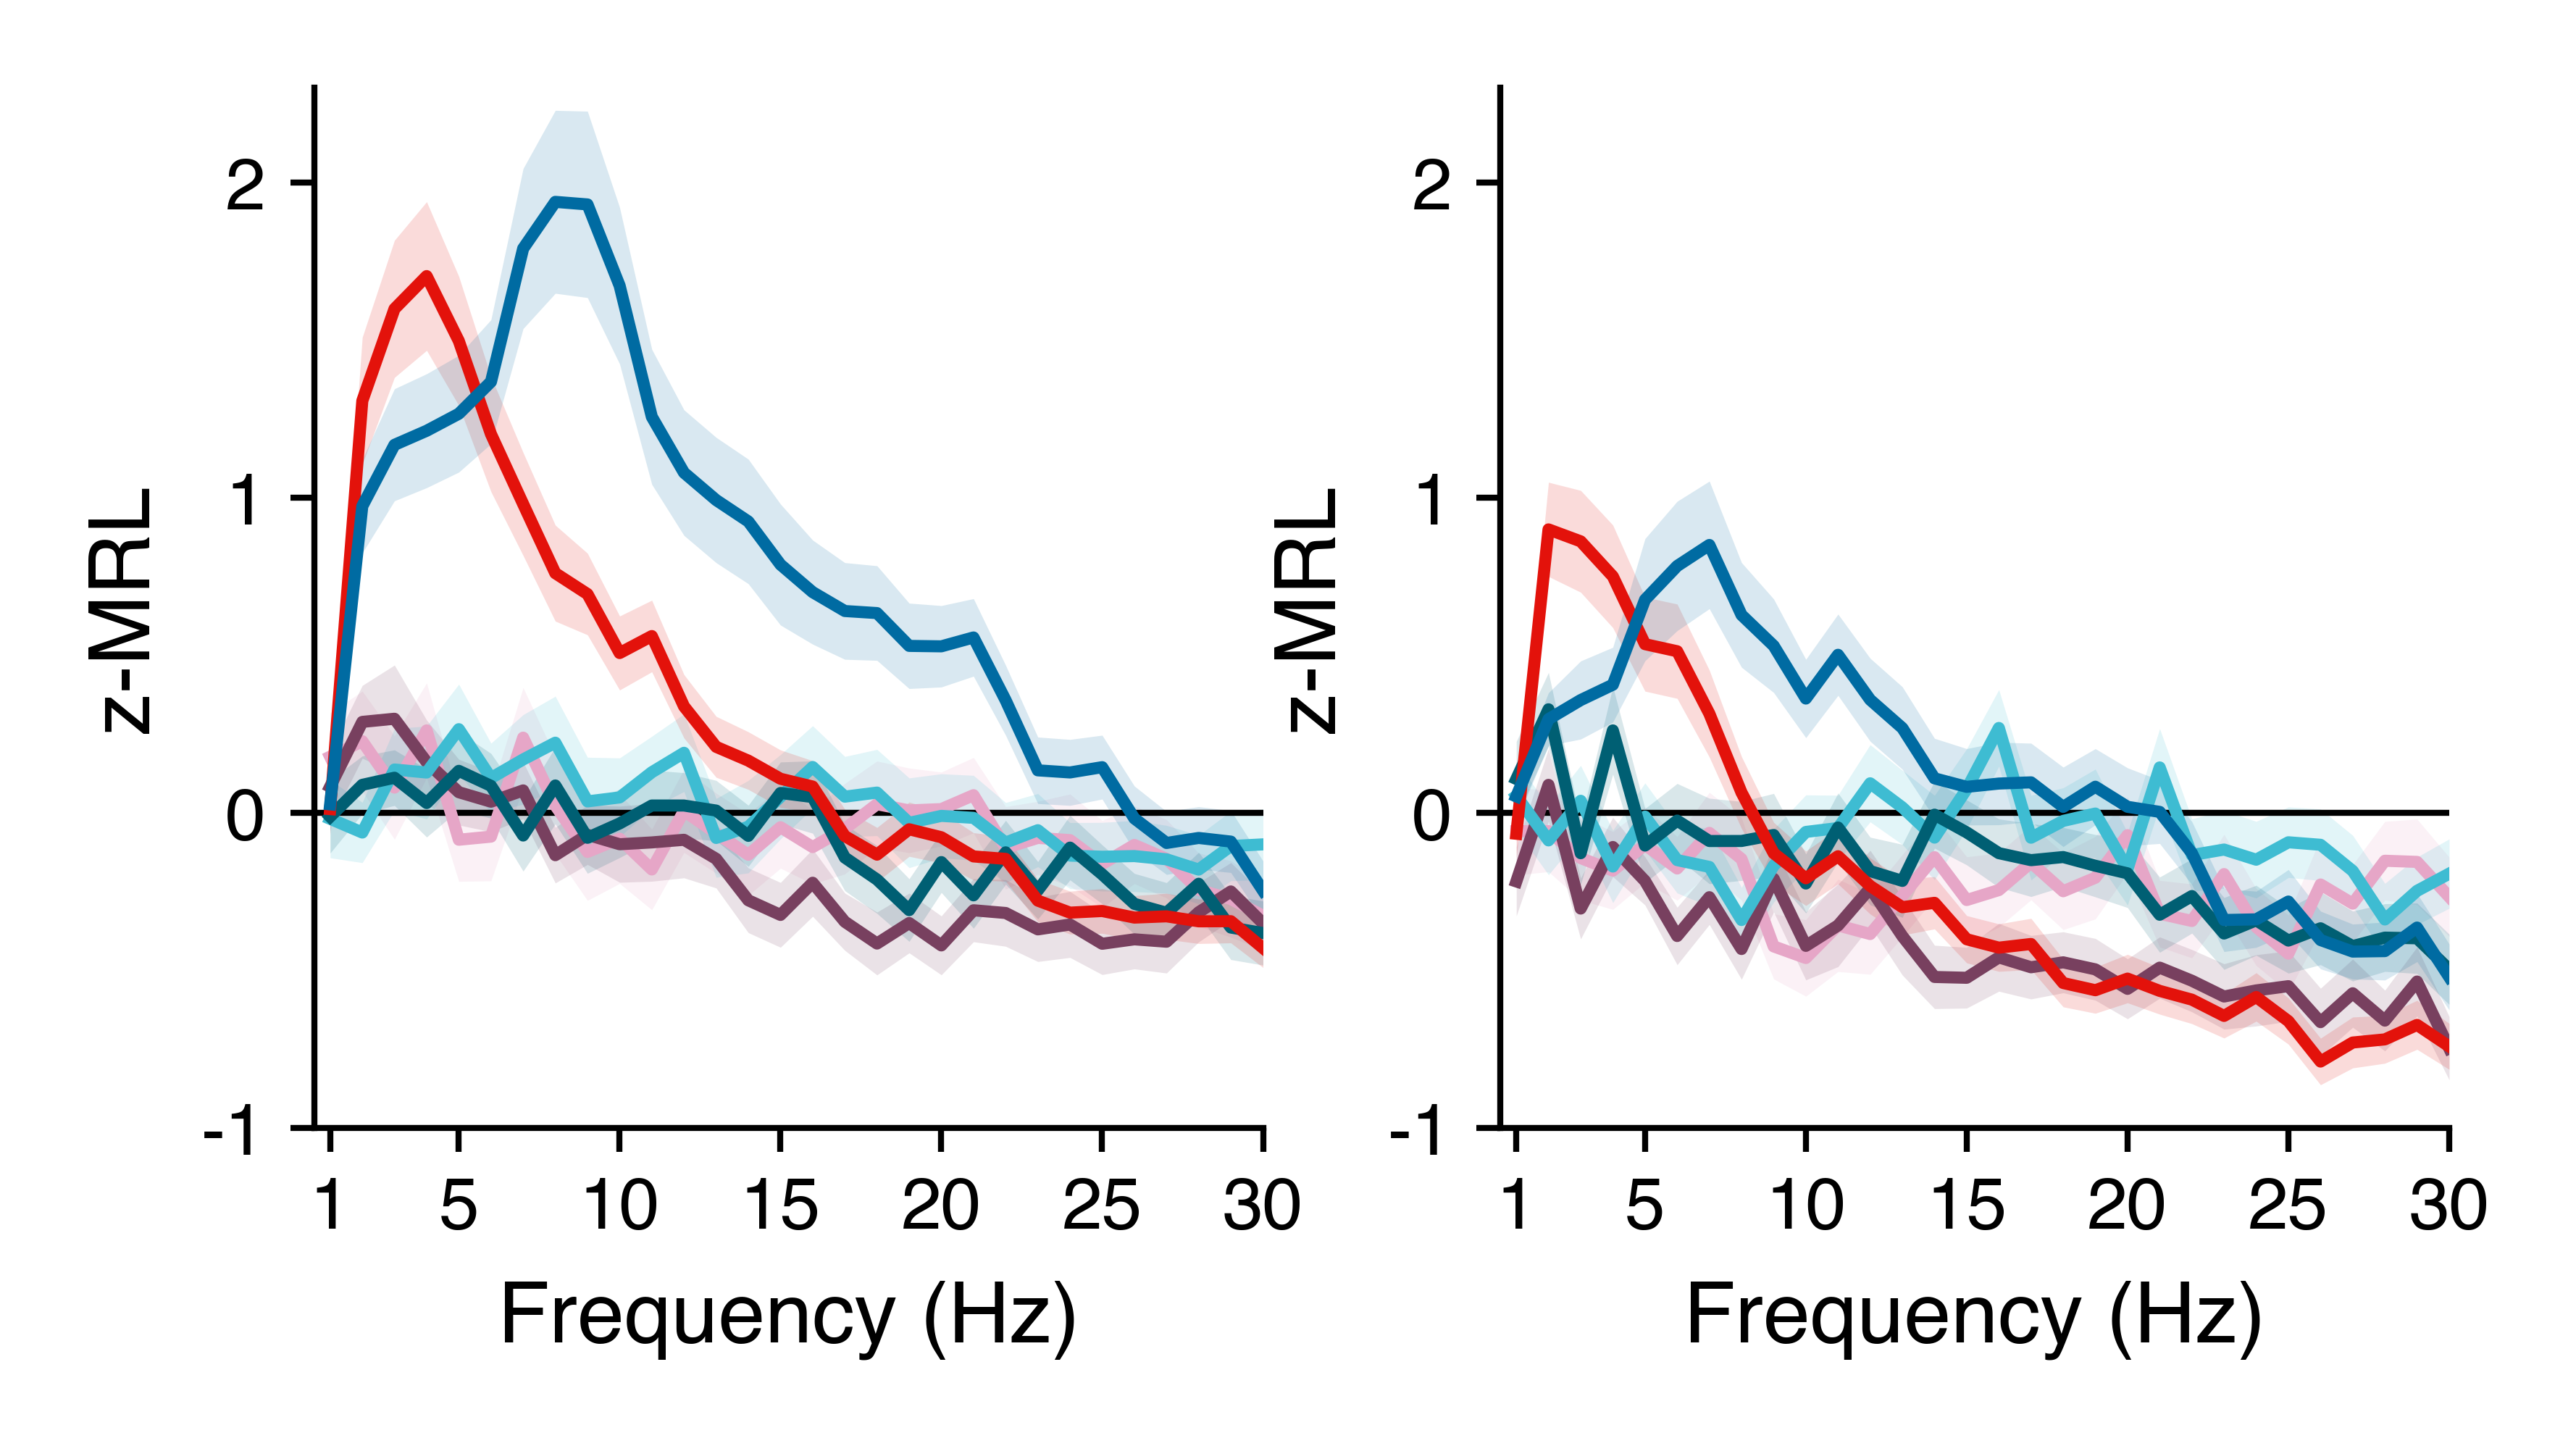

In [21]:
is_local = 0
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1, 2.3)
yticks = [-1, 0, 1, 2]
yticklabs = yticks
lw = 1
linecolor = {'HPC': co['x4'],
             'EC': co['b'],
             'AMY': co['r'],
             'PHG': co['c6'],
             'STG': co['c'],
             'OFC': co['p6'],
             'ACC': co['p2']}
linewidths = {'target_and_comp': 1,
              'target_not_comp': 1}
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax in range(len(ax)):
    _ax = ax[iax]
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw)
    
    if iax == 0:
        mask = 'target_and_comp'
    else:
        mask = 'target_not_comp'
    roi_pairs = [
        (mask, 'EC'),
        (mask, 'AMY'),
        (mask, 'PHG'),
        (mask, 'STG'),
        (mask, 'OFC'),
        (mask, 'ACC')
    ]
    rois_plotted = od([])
    for mask, unit_roi in roi_pairs[::-1]:
        if is_local:
            lfp_roi = unit_roi
        else:
            lfp_roi = 'HPC'
        rois_plotted[(unit_roi, lfp_roi)] = rois_plotted.get((unit_roi, lfp_roi), 0) + 1
        _means = np.array(zmrls.at[(mask, unit_roi, lfp_roi), 'mean_zmrls'])
        _sems = np.array(zmrls.at[(mask, unit_roi, lfp_roi), 'sem_zmrls'])
        _ax.fill_between(xvals,
                         _means + _sems,
                         _means - _sems,
                         alpha=0.15, lw=0, color=linecolor[unit_roi])
        _ax.plot(xvals, _means, lw=linewidths[mask], color=linecolor[unit_roi])

        print('{:>3} to {:>3}, {}, 1-30Hz: {:>3} neurons, {:>2} subjs, min={:>5.2f}, max={:>5.2f}'
              .format(unit_roi, lfp_roi, mask,
                      zmrls.at[(mask, unit_roi, lfp_roi), 'units'],
                      zmrls.at[(mask, unit_roi, lfp_roi), 'subjs'],
                      np.nanmin(_means - _sems), np.nanmax(_means + _sems)))

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(ax_linewidth)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'phase_lock_freqs', 
                       'zMRL-by-freq_osc1v2_1-30Hz_{}-neurons.pdf'
                       .format('_'.join(['{}{}-to-{}'
                                         .format(zmrls.at[(mask, unit_roi, lfp_roi), 'units'],
                                                 unit_roi,
                                                 lfp_roi)
                                         for (unit_roi, lfp_roi) in rois_plotted.keys()])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

ACC to HPC, target_not_comp, 1-30Hz:  71 neurons,  7 subjs, min=-0.58, max= 0.08
ACC to HPC, target_and_comp, 1-30Hz:  71 neurons,  7 subjs, min=-0.44, max= 0.41
OFC to HPC, target_not_comp, 1-30Hz: 105 neurons, 13 subjs, min=-0.85, max= 0.20
OFC to HPC, target_and_comp, 1-30Hz: 105 neurons, 13 subjs, min=-0.51, max= 0.47
STG to HPC, target_not_comp, 1-30Hz:  92 neurons,  5 subjs, min=-0.45, max= 0.39
STG to HPC, target_and_comp, 1-30Hz:  92 neurons,  5 subjs, min=-0.29, max= 0.41
PHG to HPC, target_not_comp, 1-30Hz: 102 neurons, 14 subjs, min=-0.61, max= 0.44
PHG to HPC, target_and_comp, 1-30Hz: 102 neurons, 14 subjs, min=-0.48, max= 0.26
AMY to HPC, target_not_comp, 1-30Hz: 230 neurons, 21 subjs, min=-0.86, max= 1.05
AMY to HPC, target_and_comp, 1-30Hz: 230 neurons, 21 subjs, min=-0.49, max= 1.94
 EC to HPC, target_not_comp, 1-30Hz: 206 neurons, 17 subjs, min=-0.63, max= 1.05
 EC to HPC, target_and_comp, 1-30Hz: 206 neurons, 17 subjs, min=-0.34, max= 2.23


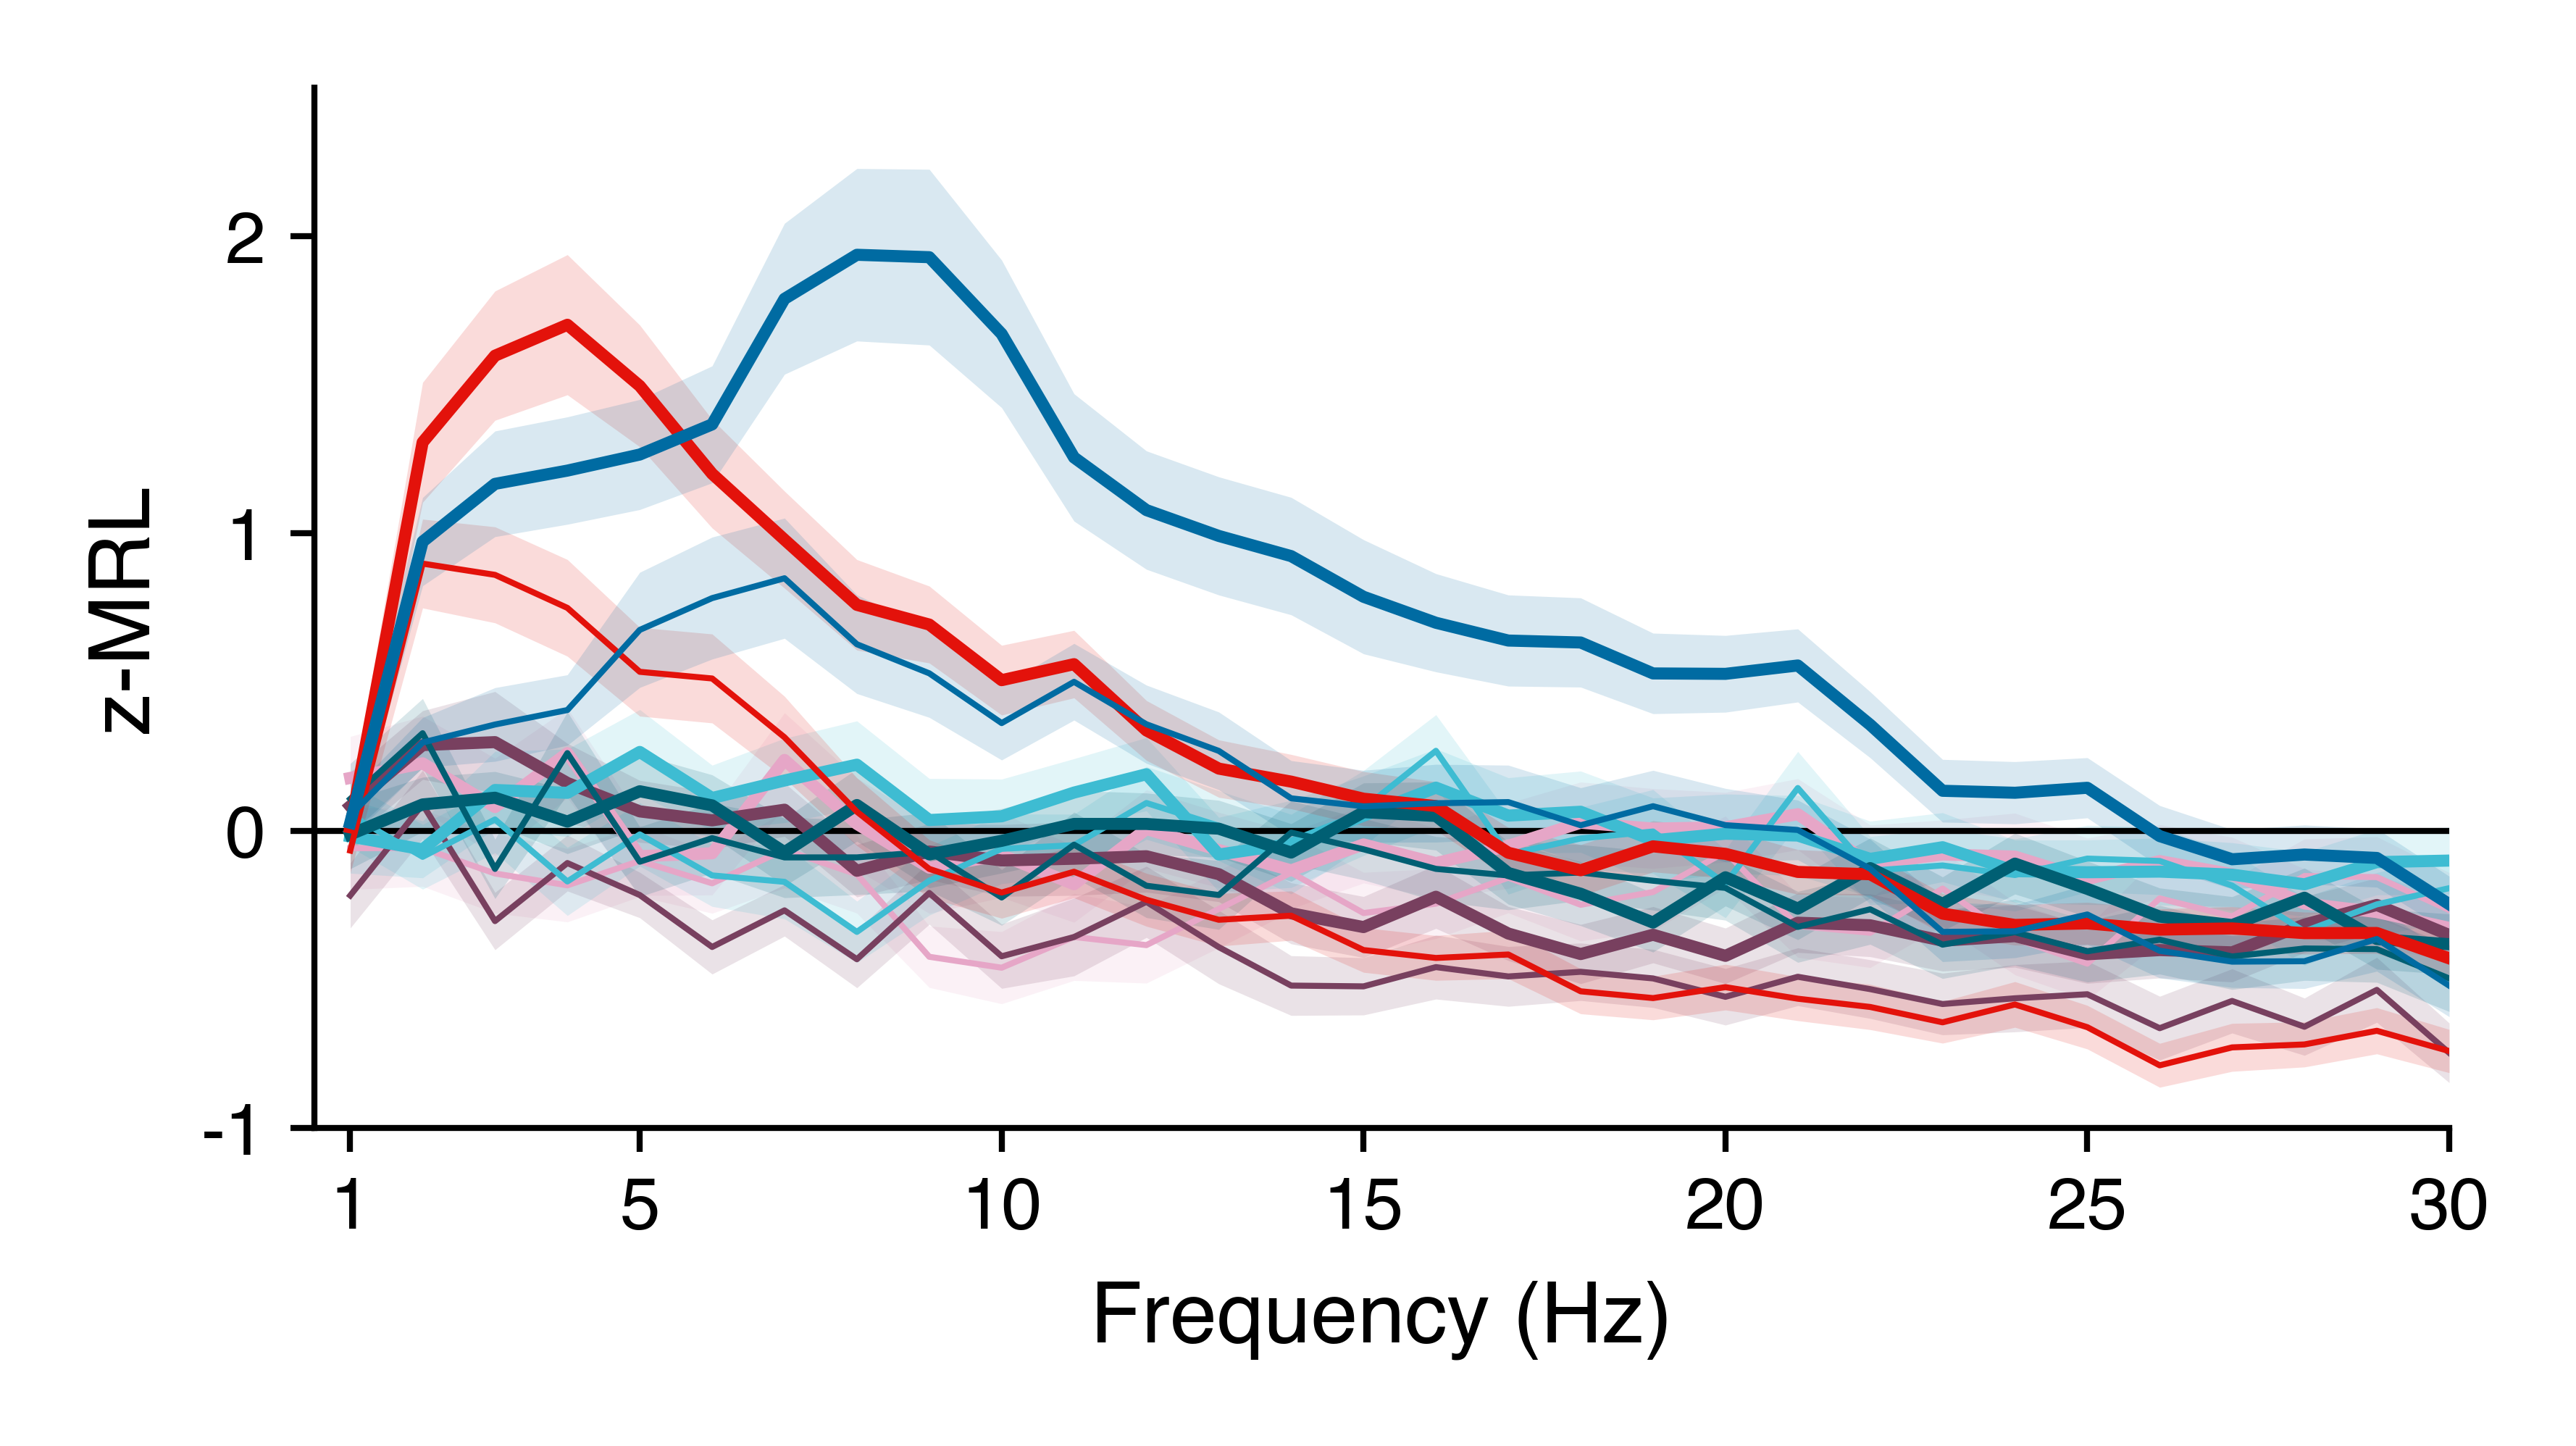

In [16]:
is_local = 0
roi_pairs = [
    ('target_and_comp', 'EC'),
    ('target_not_comp', 'EC'),
    ('target_and_comp', 'AMY'),
    ('target_not_comp', 'AMY'),
    ('target_and_comp', 'PHG'),
    ('target_not_comp', 'PHG'),
    ('target_and_comp', 'STG'),
    ('target_not_comp', 'STG'),
    ('target_and_comp', 'OFC'),
    ('target_not_comp', 'OFC'),
    ('target_and_comp', 'ACC'),
    ('target_not_comp', 'ACC'),
]
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1, 2.5)
yticks = [-1, 0, 1, 2]
yticklabs = yticks
lw = 1
linecolor = {'HPC': co['x4'],
             'EC': co['b'],
             'AMY': co['r'],
             'PHG': co['c6'],
             'STG': co['c'],
             'OFC': co['p6'],
             'ACC': co['p2']}
linewidths = {'target_and_comp': 1,
              'target_not_comp': 0.5}
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
if plot_hline:
    _ax.axhline(hline, color=hline_color, lw=spine_lw)

rois_plotted = od([])
for mask, unit_roi in roi_pairs[::-1]:
    if is_local:
        lfp_roi = unit_roi
    else:
        lfp_roi = 'HPC'
    rois_plotted[(unit_roi, lfp_roi)] = rois_plotted.get((unit_roi, lfp_roi), 0) + 1
    _means = np.array(zmrls.at[(mask, unit_roi, lfp_roi), 'mean_zmrls'])
    _sems = np.array(zmrls.at[(mask, unit_roi, lfp_roi), 'sem_zmrls'])
    _ax.fill_between(xvals,
                     _means + _sems,
                     _means - _sems,
                     alpha=0.15, lw=0, color=linecolor[unit_roi])
    _ax.plot(xvals, _means, lw=linewidths[mask], color=linecolor[unit_roi])
    
    print('{:>3} to {:>3}, {}, 1-30Hz: {:>3} neurons, {:>2} subjs, min={:>5.2f}, max={:>5.2f}'
          .format(unit_roi, lfp_roi, mask,
                  zmrls.at[(mask, unit_roi, lfp_roi), 'units'],
                  zmrls.at[(mask, unit_roi, lfp_roi), 'subjs'],
                  np.nanmin(_means - _sems), np.nanmax(_means + _sems)))
    
for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(ax_linewidth)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
_ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'phase_lock_freqs', 
                       'zMRL-by-freq_osc1v2_1-30Hz_{}-neurons.pdf'
                       .format('_'.join(['{}{}-to-{}'
                                         .format(zmrls.at[(mask, unit_roi, lfp_roi), 'units'],
                                                 unit_roi,
                                                 lfp_roi)
                                         for (unit_roi, lfp_roi) in rois_plotted.keys()])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [226]:
#pl_osc2_flat.groupby(['mask', 'unit_roi_gen', 'is_local'], observed=True).size().index

In [227]:
pd.DataFrame((pl_osc2_flat
              .groupby(['mask', 'unit_roi_gen', 'is_local'], observed=True)
              .agg({'z_n_spikes_mask': lambda x: list(np.nanmean(list(x), axis=0))})
              ['z_n_spikes_mask'].tolist()),
             index=pl_osc2_flat.groupby(['mask', 'unit_roi_gen', 'is_local'], observed=True).size().index,
             columns=freqs)

1         2         3         4   \
mask            unit_roi_gen is_local                                           
target_and_comp EC           False     0.198996  0.264197  0.254996  0.519838   
                             True      0.091758  0.211694  0.284596  0.398064   
                AMY          False     0.234422  0.623002  0.486031  0.727005   
                             True      0.484685  0.700395  0.901213  0.910720   
                PHG          False    -0.016655  0.181853  0.354695  0.175462   
                             True      0.273121 -0.082870  0.113865 -0.079843   
                STG          False     0.001241  0.237727  0.566806  0.705216   
                             True      0.036279  0.672585  1.089285  1.297210   
                OFC          False     0.294237  0.437279  0.916069  0.842957   
                             True      0.283673  0.932813  0.958680  0.805996   
                ACC          False     0.014830  0.392545  0.761171  0.400256   
                             True      0.687219  1.013500  1.412856  1.063066   
target_not_comp EC           False     0.198996  0.264197  0.254996  0.519838   
                             True      0.091758  0.211694  0.284596  0.398064   
                AMY          False     0.234422  0.623002  0.486031  0.727005   
                             True      0.484685  0.700395  0.901213  0.910720   
                PHG          False    -0.016655  0.181853  0.354695  0.175462   
                             True      0.273121 -0.082870  0.113865 -0.079843   
                STG          False     0.001241  0.237727  0.566806  0.705216   
                             True      0.036279  0.672585  1.089285  1.297210   
                OFC          False     0.294237  0.437279  0.916069  0.842957   
                             True      0.283673  0.932813  0.958680  0.805996   
                ACC          False     0.014830  0.392545  0.761171  0.400256   
                             True      0.687219  1.013500  1.412856  1.063066   

                                             5         6         7         8   \
mask            unit_roi_gen is_local                                           
target_and_comp EC           False     0.366952  0.260698  0.453969  0.489120   
                             True      0.240407  0.237784  0.133490  0.385864   
                AMY          False     0.678550  0.871380  1.291112  1.470693   
                             True      1.082104  1.403370  1.696014  1.917501   
                PHG          False     0.235288  0.220995  1.188532  0.993750   
                             True     -0.051350 -0.177097  0.058092  0.103457   
                STG          False     0.520062  0.620173  0.760464  0.648776   
                             True      0.673709  0.915362  1.253699  1.235784   
                OFC          False     0.866830  0.807752  0.939471  0.896824   
                             True      1.021463  1.338020  1.354239  1.280159   
                ACC          False     0.381170  0.579820  0.726334  1.028927   
                             True      1.123265  1.347540  1.333768  1.534657   
target_not_comp EC           False     0.366952  0.260698  0.453969  0.489120   
                             True      0.240407  0.237784  0.133490  0.385864   
                AMY          False     0.678550  0.871380  1.291112  1.470693   
                             True      1.082104  1.403370  1.696014  1.917501   
                PHG          False     0.235288  0.220995  1.188532  0.993750   
                             True     -0.051350 -0.177097  0.058092  0.103457   
                STG          False     0.520062  0.620173  0.760464  0.648776   
                             True      0.673709  0.915362  1.253699  1.235784   
                OFC          False     0.866830  0.807752  0.939471  0.896824   
                             True      1.021463  1.338020  1.354239  1.2801